In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from collections import Counter
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
import shap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from joblib import Parallel, delayed
import matplotlib.cm as cm 
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#### function in use for the next steps:

In [2]:
def count_rows_with_empty_values(df, threshold):
    num_empty_values = df.isnull().sum(axis=1)
    rows_with_empty_values = (num_empty_values > threshold).sum()
    return rows_with_empty_values

def plot_pie_chart(df, column_name):
    counts = df[column_name].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts))))
    plt.title(f'Distribution of {column_name.capitalize()}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

def plot_histogram_with_kde(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column_name, bins=30, kde=True)
    plt.title(f'Distribution of {column_name.capitalize()}')
    plt.xlabel(column_name.capitalize())
    plt.ylabel('Frequency')
    plt.show()

def plot_histogram(df, column_name):
    plt.figure(figsize=(10, 6))
    plt.hist(df[column_name].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column_name} Values')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
#פונקציה שמסירה חריגים מעל לגבול מסויים
def remove_values_greater_than(df, column_name, threshold):
    df_filtered = df[df[column_name] <= threshold]
    return df_filtered

#קורלציה לפי מתודה
def plot_correlation_heatmap(df, numeric_columns, method):
    df_numeric = df[numeric_columns]
    corr_matrix = df_numeric.corr(method=method)

    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()


def plot_pie_chart_matrix(df):
    binary_columns = [col for col in df.columns if df[col].isin([0, 1]).all()]

    num_plots = len(binary_columns)
    num_cols = 3  # Number of columns per row (adjust as needed)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.suptitle('Pie Chart Matrix for Binary Columns', fontsize=16)
    axes = axes.flatten()  # Flatten axes for easier indexing

    for i, column_name in enumerate(binary_columns):
        counts = df[column_name].value_counts()
        ax = axes[i]
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts))))
        ax.set_title(f'Distribution of {column_name.capitalize()}')
        ax.axis('equal')

    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top space for the overall title
    plt.show()

    
#גרף כינור לעמודה מספרית לפי עמודה קטגורית
def plot_violin(df, x_col, y_col):
    plt.figure(figsize=(15, 10))
    sns.violinplot(x=x_col, y=y_col, data=df)
    plt.title(f'Violin Plot of {y_col} by {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()
    
#גרף בוקפלוט לעמודה מספרית לפי עמודה קטגורית
def plot_numeric_vs_categorical(data, numeric_column, categorical_column):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=categorical_column, y=numeric_column, data=data)
    plt.title(f'Boxplot of {numeric_column} by {categorical_column}')
    plt.xlabel(categorical_column)
    plt.ylabel(numeric_column)
    plt.xticks(rotation=45) 
    plt.show()
    

# בוקספלוטים לרשימת עמודות
def plot_boxplot_matrix(df, columns):
    numeric_columns = [col for col in columns if pd.api.types.is_numeric_dtype(df[col])]
    num_plots = len(columns)
    num_cols = 3  # Number of columns per row (adjust as needed)
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    fig.suptitle('Boxplot Matrix for Selected Columns', fontsize=16)
    axes = axes.flatten()
    for i, column_name in enumerate(columns):
        ax = axes[i]
        sns.boxplot(x=df[column_name], ax=ax)
        ax.set_title(f'Boxplot of {column_name.capitalize()}')
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

#בחינה גרפית של קשר בין 2 עמודות קטגוריות
def plot_by_category(df, category_column, target_column):
    survival_data = df.groupby(category_column)[target_column].value_counts(normalize=True).unstack() * 100
    survival_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'red'])
    plt.title(f'{target_column} Percentages by {category_column}')
    plt.xlabel(category_column.capitalize())
    plt.ylabel('Percentage')
    plt.legend(title=target_column.capitalize(), labels=['0', '1'])
    plt.xticks(rotation=0)
    plt.show()

## בדיקת מובהקות קשר בין 2 משתנים מספריים
def t_test_mortality_numeric(data, numerical_column):
    died_values = data[data['mortality'] == 1][numerical_column]
    lived_values = data[data['mortality'] == 0][numerical_column]
    
    t_stat, p_value = ttest_ind(died_values, lived_values, equal_var=False)
    
    print(f"P-value for {numerical_column}: {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print("The difference in values between those who died and those who lived is statistically significant.")
    else:
        print("The difference in values between those who died and those who lived is not statistically significant.")

## בדיקת מובהקות קשר בין 2 משתנים בינאריים
def chi_square_test(data, variable1, variable2):
    contingency_table = pd.crosstab(data[variable1], data[variable2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    print(f"P-value: {p}")
    
    alpha = 0.05
    if p < alpha:
        print("There is a statistically significant association between the two variables.")
    else:
        print("There is no statistically significant association between the two variables.")

#גרף צפיפות כדי לבחון התפלגות
def plot_density_matrix(df, columns):
    fig, axes = plt.subplots(nrows=len(columns) // 3 + 1, ncols=3, figsize=(12, 14))
    fig.subplots_adjust(wspace=0.5)

    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        df[col].plot.density(ax=ax)
        ax.set_title(col)
        ax.legend(loc='upper right')

    # Hide any unused subplots
    for j in range(len(columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

#פונקציה להרצת גרפי REGPLOT
def plot_regression(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.regplot(x=data[x_col], y=data[y_col])
    plt.title(f'Regression Plot: {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


def standardize_data(df, numerical_cols):
    df_standardized = df.copy()
    scaler = StandardScaler()
    df_standardized[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df_standardized

#עצים להורדת מימדים
def tree_based_feature_importance(X, y):
    model = RandomForestClassifier()
    model.fit(X, y)
    feature_importance = pd.Series(model.feature_importances_, index=X.columns)
    selected_features = feature_importance[feature_importance > 0]
    print("Tree-based Feature Importance:")
    print(selected_features)
    plt.figure(figsize=(10, 6))
    selected_features.plot(kind='bar', color='c')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Tree-based Feature Importance')
    plt.xticks(rotation=45)
    plt.show()
    return selected_features


#מבחן חי בריבוע להורדת מימדים
def chi_square_feature_selection(X, y, k=10):
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest = chi2_selector.fit_transform(X, y)
    selected_features = X.columns[chi2_selector.get_support()]
    print("Chi-Square Selected Features:")
    print(selected_features)
    chi2_scores = chi2_selector.scores_[chi2_selector.get_support()]
    colors = plt.cm.Paired(np.arange(len(selected_features)))
    plt.figure(figsize=(10, 6))
    plt.bar(selected_features, chi2_scores, color=colors)
    plt.xlabel('Features')
    plt.ylabel('Chi-Square Score')
    plt.title('Chi-Square Feature Selection')
    plt.xticks(rotation=45)
    plt.show()
    return selected_features

## אנובה להורדת מימדים
def anova_f_test_feature_selection(X, y, k=10):
    f_selector = SelectKBest(f_classif, k=k)
    X_kbest = f_selector.fit_transform(X, y)
    selected_features = X.columns[f_selector.get_support()]
    print("ANOVA F-test Selected Features:")
    print(selected_features)
    f_scores = f_selector.scores_[f_selector.get_support()]
    colors = plt.cm.Paired(np.arange(len(selected_features)))
    plt.figure(figsize=(10, 6))
    plt.bar(selected_features, f_scores, color=colors)
    plt.xlabel('Features')
    plt.ylabel('F-Score')
    plt.title('ANOVA F-test Feature Selection')
    plt.xticks(rotation=45)
    plt.show()
    return selected_features

## אר אף אי להורדת מימדים
def rfe_feature_selection(X, y, n_features_to_select=10, max_iter=1000):
    model = LogisticRegression(max_iter=max_iter)
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(X, y)
    rfe_support = rfe.get_support()
    rfe_features = X.columns[rfe_support].tolist()
    print("Top features selected by RFE:")
    print(rfe_features)
    rfe_ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rfe_ranking.values, y=rfe_ranking.index, palette="Paired")
    plt.title('Feature Ranking by RFE')
    plt.xlabel('Ranking')
    plt.ylabel('Features')
    plt.show()
    return rfe_features

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print("Original class distribution:")
    print(y_train.value_counts())
    print("\nResampled class distribution:")
    print(pd.Series(y_resampled).value_counts())
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.pie(pd.Series(y_resampled).value_counts(), labels=pd.Series(y_resampled).value_counts().index, autopct='%1.1f%%')
    plt.title('Class Distribution After SMOTE')
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled, palette="Set2")
    plt.title('Class Count After SMOTE')
    plt.show()
    return X_resampled, y_resampled

def apply_random_over_sampling(X_train, y_train):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    original_distribution = y_train.value_counts().reset_index()
    original_distribution.columns = ['Class', 'Count']
    resampled_distribution = pd.Series(y_resampled).value_counts().reset_index()
    resampled_distribution.columns = ['Class', 'Count']
    print("Original class distribution:")
    print(original_distribution)
    print("\nResampled class distribution:")
    print(resampled_distribution)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.pie(pd.Series(y_resampled).value_counts(), labels=pd.Series(y_resampled).value_counts().index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title('Class Distribution After Random Over-Sampling')
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled, palette='Set2')
    plt.title('Class Count After Random Over-Sampling')
    plt.show()
    return X_resampled, y_resampled, original_distribution, resampled_distribution

def cluster_and_evaluate(data, cluster_range=[2, 3,4,5,6,7,8]):
    results_df = pd.DataFrame(columns=['Clusters', 'SSE', 'Silhouette', 'Sample Count', 'Min Count', 'Max Count'])
    elbow_df = pd.DataFrame(columns=['Clusters', 'Inertia'])
    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit(data)
        labels = kmeans.labels_
        sample_count = pd.Series(labels).value_counts()
        sse = kmeans.inertia_
        silhouette_avg = silhouette_score(data, labels)
        results_df = pd.concat([results_df, pd.DataFrame({'Clusters': [num_clusters], 'SSE': [sse], 'Silhouette': [silhouette_avg], 'Sample Count': [sample_count], 'Min Count': [sample_count.min()], 'Max Count': [sample_count.max()]})], ignore_index=True)
        elbow_df = pd.concat([elbow_df, pd.DataFrame({'Clusters': [num_clusters], 'Inertia': [sse]})], ignore_index=True)
    plt.plot(elbow_df['Clusters'], elbow_df['Inertia'], marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum of Squared Errors)')
    plt.show()
    return results_df

def kMeansRes(scaled_data, k, alpha_k):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range, alpha_k=0.02):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k, alpha_k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns=['k', 'Scaled Inertia']).set_index('k')
    return results



#scaled inertia
def cluster_and_evaluate1(data, cluster_range=[2, 3, 4, 5, 6, 7, 8 , 9]):
    scaled_data = np.asarray(data).astype(float)
    Scaled_Inertia_df = chooseBestKforKMeans(scaled_data, cluster_range, 0.02)
    results_df = pd.DataFrame(columns=['Clusters', 'SSE','Scaled Inertia','Silhouette', 'Sample Count', 'Min Count', 'Max Count'])
    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit(data)
        labels = kmeans.labels_
        sample_count = pd.Series(labels).value_counts()
        scaled_inertia = kMeansRes(scaled_data, num_clusters, 0.02)
        sse = kmeans.inertia_
        silhouette_avg = silhouette_score(data, labels)
        results_df = pd.concat([results_df, pd.DataFrame({'Clusters': [num_clusters], 'SSE': [sse],'Scaled Inertia' : [scaled_inertia], 'Silhouette': [silhouette_avg], 'Sample Count': [sample_count], 'Min Count': [sample_count.min()], 'Max Count': [sample_count.max()]})], ignore_index=True)
    plt.figure(figsize=(7, 4))
    plt.plot(Scaled_Inertia_df, 'o')
    plt.title('Scaled Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Scaled Inertia')
    plt.xticks(range(2, 10))
    plt.show()
    return results_df



def plot_silhouette(data, n_clusters, ax):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title(f"Silhouette plot for {n_clusters} clusters")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    return silhouette_avg


def apply_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(data)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"Silhouette Score: {silhouette_avg:.2f}")
    else:
        silhouette_avg = "N/A"
        print("Silhouette Score: N/A (only one cluster or all noise)")
    plt.figure(figsize=(10, 5))
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (cluster_labels == k)
        xy = data[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    print(f'Number of clusters: {n_clusters}')
    return None

def compare_agglomerative_clustering(data):
    linkage_methods = ['ward']
    for method in linkage_methods:
        Z = linkage(data, method)
        plt.figure(figsize=(20, 10))
        dendrogram(Z, orientation='top', leaf_rotation=90, leaf_font_size=8)
        plt.title(f'Dendrogram - Linkage Method: {method.capitalize()}')
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.show()
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage=method, distance_threshold=0)
        cluster_labels = cluster.fit_predict(data)
        print(f'Cluster labels using {method.capitalize()} linkage:\n{cluster_labels}\n{"="*40}\n')

def plot_hierarchical_dendrogram(data, method='ward', p=5, figsize=(10, 7), title='Hierarchical Clustering Dendrogram'):
    Z = linkage(data, method=method)
    plt.figure(figsize=figsize)
    plt.title(title)
    dendrogram(Z, truncate_mode='lastp', p=p, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
    plt.xlabel('Cluster size')
    plt.ylabel('Distance')
    plt.show()
    
def kmeans_cluster_to_dfs(data, K):
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    data['Cluster'] = cluster_labels
    cluster_dfs = {}
    for cluster in range(K):
        cluster_dfs[cluster] = data[data['Cluster'] == cluster].drop('Cluster', axis=1)
    return cluster_dfs

def plot_pie_chart_comparison5(df1, df2, df3, df4, df5):
    binary_columns = [col for col in df1.columns if df1[col].isin([0, 1]).all() and col in df2.columns and col in df3.columns and col in df4.columns and col in df5.columns]
    if len(binary_columns) == 0:
        print("No binary columns found in all DataFrames.")
        return
    num_plots = len(binary_columns)
    num_rows = 13  
    num_cols = 5 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
    axes = axes.flatten()  # Flatten axes for easier indexing
    for i, column_name in enumerate(binary_columns):
        counts1 = df1[column_name].value_counts()
        ax1 = axes[5 * i]
        ax1.pie(counts1, labels=counts1.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts1))))
        ax1.set_title(f'DF1: {column_name.capitalize()}')
        ax1.axis('equal')
        counts2 = df2[column_name].value_counts()
        ax2 = axes[5 * i + 1]
        ax2.pie(counts2, labels=counts2.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts2))))
        ax2.set_title(f'DF2: {column_name.capitalize()}')
        ax2.axis('equal')
        counts3 = df3[column_name].value_counts()
        ax3 = axes[5 * i + 2]
        ax3.pie(counts3, labels=counts3.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts3))))
        ax3.set_title(f'DF3: {column_name.capitalize()}')
        ax3.axis('equal')
        counts4 = df4[column_name].value_counts()
        ax4 = axes[5 * i + 3]
        ax4.pie(counts4, labels=counts4.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts4))))
        ax4.set_title(f'DF4: {column_name.capitalize()}')
        ax4.axis('equal')
        counts5 = df5[column_name].value_counts()
        ax5 = axes[5 * i + 4]
        ax5.pie(counts5, labels=counts5.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts5))))
        ax5.set_title(f'DF5: {column_name.capitalize()}')
        ax5.axis('equal')
    for j in range(num_plots * num_cols, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top space for the overall title
    plt.show()



def plot_numerical_distributions5(df1, df2, df3, df4, df5):
    fig, axes = plt.subplots(len(numerical_columns), 5, figsize=(25, 5 * len(numerical_columns)))
    fig.suptitle('Distribution of Numerical Columns', fontsize=16)
    axes = axes.flatten()
    for i, column_name in enumerate(numerical_columns):
        if column_name in df1.columns and column_name in df2.columns and column_name in df3.columns and column_name in df4.columns and column_name in df5.columns:
            ax1 = axes[5 * i]
            df1[column_name].plot(kind='hist', ax=ax1, bins=30, color='blue', alpha=0.7)
            ax1.set_title(f'DF1: {column_name}')
            ax1.set_xlabel('Value')
            ax1.set_ylabel('Frequency')
            ax2 = axes[5 * i + 1]
            df2[column_name].plot(kind='hist', ax=ax2, bins=30, color='green', alpha=0.7)
            ax2.set_title(f'DF2: {column_name}')
            ax2.set_xlabel('Value')
            ax2.set_ylabel('Frequency')
            ax3 = axes[5 * i + 2]
            df3[column_name].plot(kind='hist', ax=ax3, bins=30, color='red', alpha=0.7)
            ax3.set_title(f'DF3: {column_name}')
            ax3.set_xlabel('Value')
            ax3.set_ylabel('Frequency')
            ax4 = axes[5 * i + 3]
            df4[column_name].plot(kind='hist', ax=ax4, bins=30, color='purple', alpha=0.7)
            ax4.set_title(f'DF4: {column_name}')
            ax4.set_xlabel('Value')
            ax4.set_ylabel('Frequency')
            ax5 = axes[5 * i + 4]
            df5[column_name].plot(kind='hist', ax=ax5, bins=30, color='orange', alpha=0.7)
            ax5.set_title(f'DF5: {column_name}')
            ax5.set_xlabel('Value')
            ax5.set_ylabel('Frequency')
    for j in range(len(numerical_columns) * 5, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap
    plt.show()

    

def tsne_visualization(X_transformed, labels_pca):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_transformed)
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors[:6]):
        plt.scatter(X_tsne[labels_pca == i, 0], X_tsne[labels_pca == i, 1], color=color, lw=2, label=f'Cluster {i}')
    plt.title('Clustering of the dataset after PCA with TSNE visualization')
    plt.legend()
    plt.show()
    
def plot_pie_chart_comparison2(df1, df2):
    # Identify binary columns that are present in both data frames
    binary_columns = [col for col in df1.columns if df1[col].isin([0, 1]).all() and col in df2.columns]
    
    if len(binary_columns) == 0:
        print("No binary columns found in both DataFrames.")
        return

    num_plots = len(binary_columns)
    num_rows = 13  # 13 rows to accommodate all binary columns
    num_cols = 2   # 2 columns: one for each DataFrame

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten axes for easier indexing

    for i, column_name in enumerate(binary_columns):
        # Plot for df1
        counts1 = df1[column_name].value_counts()
        ax1 = axes[2 * i]
        ax1.pie(counts1, labels=counts1.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts1))))
        ax1.set_title(f'DF1: {column_name.capitalize()}')
        ax1.axis('equal')

        # Plot for df2
        counts2 = df2[column_name].value_counts()
        ax2 = axes[2 * i + 1]
        ax2.pie(counts2, labels=counts2.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(counts2))))
        ax2.set_title(f'DF2: {column_name.capitalize()}')
        ax2.axis('equal')

    # Remove any unused axes if there are fewer plots than rows*columns
    for j in range(num_plots * num_cols, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top space for the overall title
    plt.show()

def plot_numerical_distributions2(df1, df2):
    fig, axes = plt.subplots(10, 2, figsize=(15, 50))
    fig.suptitle('Distribution of Numerical Columns', fontsize=16)
    axes = axes.flatten()
    for i, column_name in enumerate(numerical_columns):
        if column_name in df1.columns and column_name in df2.columns:
            ax1 = axes[2 * i]
            df1[column_name].plot(kind='hist', ax=ax1, bins=30, color='blue', alpha=0.7)
            ax1.set_title(f'DF1: {column_name}')
            ax1.set_xlabel('Value')
            ax1.set_ylabel('Frequency')
            ax2 = axes[2 * i + 1]
            df2[column_name].plot(kind='hist', ax=ax2, bins=30, color='green', alpha=0.7)
            ax2.set_title(f'DF2: {column_name}')
            ax2.set_xlabel('Value')
            ax2.set_ylabel('Frequency')
    for j in range(len(numerical_columns) * 2, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap
    plt.show()

In [3]:
file_path = "C:\\Users\\amitf\\Desktop\\amit\\Machine learning in medicine\\CKD dataset.xlsx"
data = pd.read_excel(file_path)

In [4]:
data.head()

StudyID  Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  \
0        1       0           64                 1                0   
1        2       0           52                 1                0   
2        3       0           56                 1                0   
3        4       0           58                 1                0   
4        5       0           63                 1                1   

   HistoryCHD  HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  ...  \
0           0                0               0            1           1  ...   
1           0                0               0            1           1  ...   
2           0                0               0            1           1  ...   
3           0                0               0            0           1  ...   
4           0                0               0            1           1  ...   

   CholesterolBaseline  TriglyceridesBaseline  HgbA1C  CreatnineBaseline  \
0                  4.8                   0.92    5.90               59.0   
1                  6.4                   1.84    6.00               52.0   
2                  6.4                   1.75    5.90               57.0   
3                  5.1                   1.22    5.50               65.0   
4                  5.0                   1.11    7.46               70.0   

   eGFRBaseline  sBPBaseline  dBPBaseline  BMIBaseline  TimeToEventMonths  \
0     93.319050          144           87    40.161842                 98   
1    105.833836          148           91    44.536941                106   
2     99.839823          149           86    40.543437                 88   
3     90.315159          116           68    32.025584                103   
4     79.725199          132           63    30.757401                105   

   EventCKD35  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 25 columns]

In [5]:
data = data.drop(columns=['StudyID'])

In [6]:
data.shape

(491, 24)

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 491 non-null    int64  
 1   AgeBaseline            491 non-null    int64  
 2   Age.3.categories       491 non-null    int64  
 3   HistoryDiabetes        491 non-null    int64  
 4   HistoryCHD             491 non-null    int64  
 5   HistoryVascular        491 non-null    int64  
 6   HistorySmoking         491 non-null    int64  
 7   HistoryHTN             491 non-null    int64  
 8   HistoryDLD             491 non-null    int64  
 9   HistoryObesity         491 non-null    int64  
 10  DLDmeds                491 non-null    int64  
 11  DMmeds                 491 non-null    int64  
 12  HTNmeds                491 non-null    int64  
 13  ACEIARB                491 non-null    int64  
 14  CholesterolBaseline    491 non-null    float64
 15  Trigly

In [8]:
data.columns

Index(['Gender', 'AgeBaseline', 'Age.3.categories', 'HistoryDiabetes',
       'HistoryCHD', 'HistoryVascular', 'HistorySmoking', 'HistoryHTN ',
       'HistoryDLD', 'HistoryObesity', 'DLDmeds', 'DMmeds', 'HTNmeds',
       'ACEIARB', 'CholesterolBaseline', 'TriglyceridesBaseline', 'HgbA1C',
       'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline', 'dBPBaseline',
       'BMIBaseline', 'TimeToEventMonths', 'EventCKD35'],
      dtype='object')

In [9]:
data.isnull().sum().sort_values()

Gender                    0
BMIBaseline               0
dBPBaseline               0
sBPBaseline               0
eGFRBaseline              0
CreatnineBaseline         0
CholesterolBaseline       0
ACEIARB                   0
HTNmeds                   0
TimeToEventMonths         0
DMmeds                    0
HistoryObesity            0
HistoryDLD                0
HistoryHTN                0
HistorySmoking            0
HistoryVascular           0
HistoryCHD                0
HistoryDiabetes           0
Age.3.categories          0
AgeBaseline               0
DLDmeds                   0
EventCKD35                0
TriglyceridesBaseline     6
HgbA1C                   15
dtype: int64

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Data Exploration and Preprocessing**
<ul>
<li>missing values</li>
<li>outliers</li>
<li>EDA</li>
<li>Description of preliminary conclusions</li>
<li>Coding of categorical variables & standardization of numerical variables</li>
</ul>

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## missing values

### <blockquote> 'TriglyceridesBaseline'</blockquote>

blood fat level

In [10]:
data['TriglyceridesBaseline'].isna().sum()

6

In [11]:
data[data['TriglyceridesBaseline'].isna()]

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
311       0           55                 1                0           0   
352       0           29                 0                0           0   
364       0           37                 0                0           0   
366       0           39                 0                0           0   
427       1           35                 0                0           0   
473       1           31                 0                0           0   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
311                0               0            0           0               0   
352                0               0            1           0               0   
364                0               0            0           0               0   
366                0               0            1           0               0   
427                0               1            0           0               0   
473                0               0            0           0               1   

     ...  CholesterolBaseline  TriglyceridesBaseline  HgbA1C  \
311  ...                 5.90                    NaN     5.4   
352  ...                 4.00                    NaN     5.2   
364  ...                 5.40                    NaN     4.4   
366  ...                 3.95                    NaN     5.6   
427  ...                 5.45                    NaN     5.3   
473  ...                 4.60                    NaN     5.7   

     CreatnineBaseline  eGFRBaseline  sBPBaseline  dBPBaseline  BMIBaseline  \
311               63.0     95.790498          122           77    28.065417   
352               56.0    121.395632          103           60    19.098346   
364               63.0    108.701605          118           79    23.191095   
366               30.0    138.955747          117           68    21.183281   
427               67.0    118.359014          108           67    28.596539   
473              102.0     84.033433          120           64    30.405293   

     TimeToEventMonths  EventCKD35  
311                 88           0  
352                 64           0  
364                 77           0  
366                104           0  
427                  0           0  
473                 49           0  

[6 rows x 24 columns]

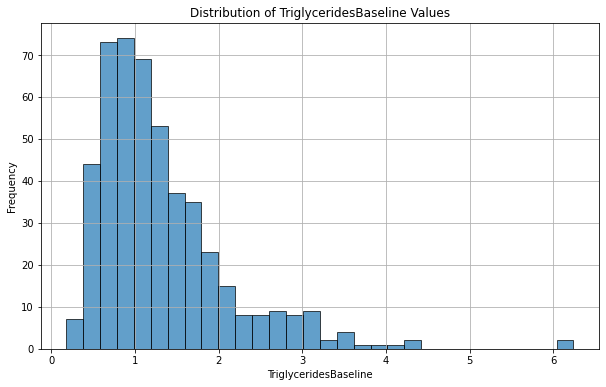

In [12]:
plot_histogram(data, 'TriglyceridesBaseline')

In [13]:
data[['TriglyceridesBaseline']].describe()

TriglyceridesBaseline
count             485.000000
mean                1.315127
std                 0.793141
min                 0.180000
25%                 0.780000
50%                 1.110000
75%                 1.620000
max                 6.240000

In [14]:
data[data['TriglyceridesBaseline']> 3]

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
6         0           71                 2                1           0   
7         0           44                 0                0           0   
10        0           49                 0                0           0   
43        0           47                 0                0           0   
48        1           45                 0                0           0   
52        1           38                 0                1           0   
61        0           32                 0                0           0   
89        0           49                 0                1           0   
96        1           61                 1                1           1   
194       0           63                 1                0           0   
231       1           50                 1                0           0   
260       1           77                 2                1           0   
270       0           53                 1                1           0   
274       0           31                 0                0           0   
276       0           58                 1                1           0   
278       1           73                 2                1           0   
299       0           54                 1                1           0   
377       1           42                 0                0           0   
395       1           55                 1                1           0   
413       1           30                 0                0           0   
425       1           44                 0                0           0   
429       1           69                 2                1           1   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
6                  0               0            1           1               1   
7                  0               0            0           1               1   
10                 0               0            1           1               1   
43                 0               0            1           1               0   
48                 0               0            1           1               1   
52                 0               0            1           1               1   
61                 0               0            0           1               1   
89                 0               0            0           1               1   
96                 0               1            1           1               1   
194                0               0            1           1               0   
231                0               0            1           1               1   
260                0               1            1           1               0   
270                0               0            0           1               1   
274                0               0            0           1               1   
276                0               0            1           1               1   
278                0               0            0           1               0   
299                0               0            1           1               1   
377                0               1            1           1               0   
395                0               0            1           1               1   
413                0               0            1           1               1   
425                0               1            0           1               1   
429                0               0            1           1               1   

     ...  CholesterolBaseline  TriglyceridesBaseline  HgbA1C  \
6    ...                  5.6                 6.1900    6.50   
7    ...                  6.6                 3.9000    5.80   
10   ...                  6.8                 3.0600    6.20   
43   ...                  5.2                 3.0800    5.90   
48   ...                  6.8                 3.3800    6.40   
52   ...                  4.5  

In [15]:
cleaned_data = remove_values_greater_than(data, 'TriglyceridesBaseline', 3.5)
cleaned_data[['TriglyceridesBaseline']].describe()

TriglyceridesBaseline
count             478.000000
mean                1.265788
std                 0.674578
min                 0.180000
25%                 0.780000
50%                 1.110000
75%                 1.600000
max                 3.480000

In [16]:
mean = cleaned_data[['TriglyceridesBaseline']].mean()
data = remove_values_greater_than(data, 'TriglyceridesBaseline', 5)
data['TriglyceridesBaseline'].fillna(mean, inplace=True)

### <blockquote>'HgbA1C'</blockquote>

hemoglobin level

In [17]:
data['HgbA1C'].isna().sum()

15

In [18]:
data[data['HgbA1C'].isna()]

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
216       1           48                 0                0           0   
251       0           59                 1                0           0   
252       1           58                 1                0           0   
286       1           59                 1                0           0   
325       0           50                 1                0           0   
398       1           33                 0                0           0   
401       1           56                 1                0           0   
413       1           30                 0                0           0   
418       1           60                 1                1           0   
452       1           27                 0                0           0   
454       1           27                 0                0           0   
458       1           30                 0                0           0   
466       1           30                 0                0           0   
486       1           25                 0                0           0   
489       1           41                 0                0           0   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
216                0               0            1           1               0   
251                0               0            1           0               0   
252                0               0            0           1               0   
286                0               1            0           1               0   
325                0               0            0           0               0   
398                0               1            0           1               0   
401                1               1            1           0               0   
413                0               0            1           1               1   
418                0               0            1           1               0   
452                0               0            0           0               0   
454                0               0            0           0               0   
458                0               0            0           0               0   
466                0               1            0           0               1   
486                0               0            0           0               0   
489                1               1            1           1               0   

     ...  CholesterolBaseline  TriglyceridesBaseline  HgbA1C  \
216  ...                 3.40                 1.5700     NaN   
251  ...                 6.10                 1.1100     NaN   
252  ...                 5.10                 0.6000     NaN   
286  ...                 6.40                 1.2500     NaN   
325  ...                 3.60                 0.2800     NaN   
398  ...                 6.60                 1.6100     NaN   
401  ...                 3.00                 0.4200     NaN   
413  ...                 5.90                 3.0100     NaN   
418  ...                 4.30                 0.5200     NaN   
452  ...                 4.10                 1.1299     NaN   
454  ...                 5.60                 1.0400     NaN   
458  ...                 4.94                 1.3000     NaN   
466  ...                 3.90                 0.6700     NaN   
486  ...                 5.30                 0.6000     NaN   
489  ...                 4.00                 1.1299     NaN   

     CreatnineBaseline  eGFRBaseline  sBPBaseline  dBPBaseline  BMIBaseline  \
216               91.0     85.606333          180          100    27.979422   
251               53.0    100.126173          151           74    24.761679   
252               71.0     98.329451          124           65    23.836735   
286               47.0    115.682543          128           74    18.507766   
325               49.0    109.450218          125           75    22.518210   
398     

In [19]:
data[['HgbA1C']].describe()

HgbA1C
count  468.000000
mean     6.602692
std      1.703099
min      3.900000
25%      5.700000
50%      6.100000
75%      6.915000
max     18.100000

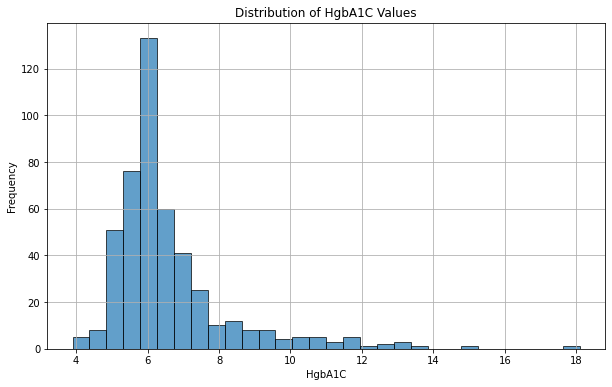

In [20]:
plot_histogram(data, 'HgbA1C')

In [21]:
data[data['HgbA1C']> 10]

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
69        1           57                 1                1           1   
86        0           58                 1                1           0   
105       1           44                 0                1           0   
132       0           53                 1                1           1   
157       1           56                 1                1           1   
222       1           64                 1                1           0   
226       0           52                 1                1           0   
227       0           64                 1                1           0   
268       0           61                 1                1           0   
301       0           74                 2                1           0   
302       1           64                 1                1           0   
307       0           56                 1                1           0   
309       0           65                 2                1           0   
318       1           61                 1                1           0   
322       1           55                 1                1           1   
355       0           53                 1                1           0   
356       1           54                 1                1           0   
371       1           51                 1                1           0   
373       1           75                 2                1           1   
386       1           39                 0                1           0   
421       1           56                 1                1           0   
429       1           69                 2                1           1   
440       1           58                 1                1           0   
460       1           66                 2                1           1   
468       1           55                 1                1           0   
479       1           58                 1                1           1   
488       1           44                 0                1           0   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
69                 1               1            1           1               0   
86                 0               0            1           1               1   
105                0               0            1           1               1   
132                0               0            1           1               1   
157                0               0            1           1               0   
222                0               0            1           1               0   
226                0               0            1           1               1   
227                0               0            0           1               0   
268                0               0            1           1               1   
301                0               0            1           1               0   
302                0               0            1           1               1   
307                0               0            1           1               1   
309                0               0            1           1               1   
318                0               1            1           1               1   
322                0               0            1           1               1   
355                0               0            1           1               1   
356                0               0            0           0               0   
371                0               1            0           1               1   
373                0               1            1           1               1   
386                0               1            1           1               0   
421                0               1            1           1               0   
429                0               0            1           1               1   
440                0               0     

#### It can be seen that all patients whose hemoglobin level in their blood is greater than 10 had diabetes in the past according to the HistoryDiabetes column (is there a history of diabetes patients, binary column).

In [22]:
Diabetes = data[data['HistoryDiabetes']== 1]
Diabetes[['HgbA1C']].describe()

HgbA1C
count  212.000000
mean     7.710802
std      1.972590
min      4.440000
25%      6.565000
50%      7.050000
75%      8.400000
max     18.100000

In [23]:
No_Diabetes = data[data['HistoryDiabetes']== 0]
No_Diabetes[['HgbA1C']].describe()

HgbA1C
count  256.000000
mean     5.685039
std      0.475437
min      3.900000
25%      5.400000
50%      5.800000
75%      6.000000
max      6.430000

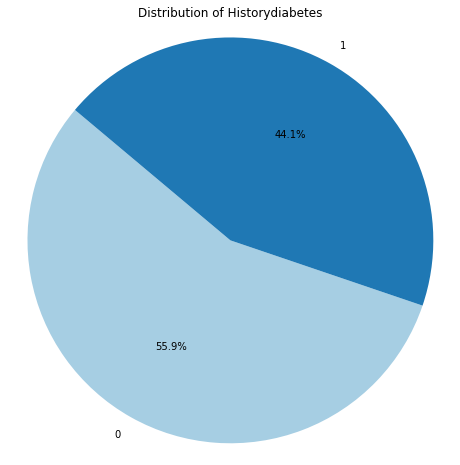

In [24]:
 plot_pie_chart(data,'HistoryDiabetes')

#### After we divided the values ​​according to the patient's history of diabetes, we saw that the standard deviation decreased significantly for each cluster separately, so we fill in the average according to the division (first cluster - positive past for diabetes, second cluster - negative past).

In [25]:
mean1 = Diabetes['HgbA1C'].mean()
mean0 = No_Diabetes['HgbA1C'].mean()
data.loc[(data['HgbA1C'].isna()) & (data['HistoryDiabetes'] == 1), 'HgbA1C'] = mean1
data.loc[(data['HgbA1C'].isna()) & (data['HistoryDiabetes'] == 0), 'HgbA1C'] = mean0

In [26]:
data.isnull().sum().sort_values()

Gender                   0
BMIBaseline              0
dBPBaseline              0
sBPBaseline              0
eGFRBaseline             0
CreatnineBaseline        0
HgbA1C                   0
TriglyceridesBaseline    0
CholesterolBaseline      0
ACEIARB                  0
HTNmeds                  0
DMmeds                   0
DLDmeds                  0
HistoryObesity           0
HistoryDLD               0
HistoryHTN               0
HistorySmoking           0
HistoryVascular          0
HistoryCHD               0
HistoryDiabetes          0
Age.3.categories         0
AgeBaseline              0
TimeToEventMonths        0
EventCKD35               0
dtype: int64

In [27]:
data.dtypes

Gender                     int64
AgeBaseline                int64
Age.3.categories           int64
HistoryDiabetes            int64
HistoryCHD                 int64
HistoryVascular            int64
HistorySmoking             int64
HistoryHTN                 int64
HistoryDLD                 int64
HistoryObesity             int64
DLDmeds                    int64
DMmeds                     int64
HTNmeds                    int64
ACEIARB                    int64
CholesterolBaseline      float64
TriglyceridesBaseline    float64
HgbA1C                   float64
CreatnineBaseline        float64
eGFRBaseline             float64
sBPBaseline                int64
dBPBaseline                int64
BMIBaseline              float64
TimeToEventMonths          int64
EventCKD35                 int64
dtype: object

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## outliers

#### As part of the research process we will examine unusual values ​​in numerical columns. We will try to examine whether there are unusual values ​​that can characterize homogeneous groups in the data and thus we can use them and come to conclusions later regarding the explanatory variables.

In [28]:
numeric_col = ['AgeBaseline','CholesterolBaseline', 'TriglyceridesBaseline','HgbA1C', 'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline','dBPBaseline', 'BMIBaseline', 'TimeToEventMonths']

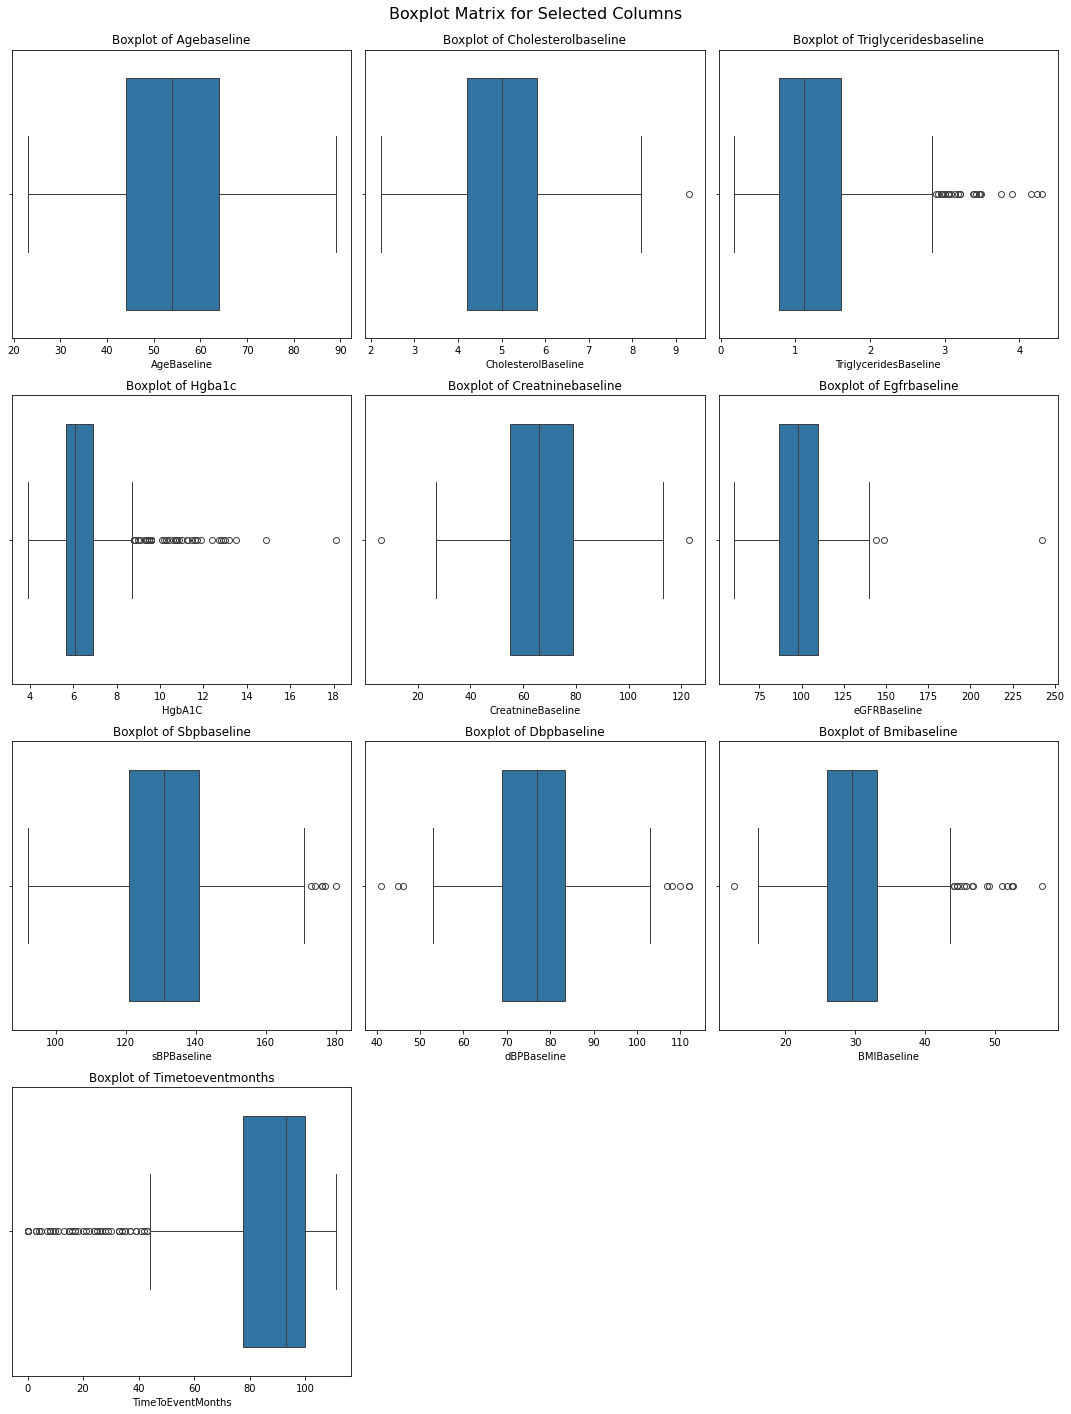

In [29]:
plot_boxplot_matrix(data, numeric_col)

In [30]:
data = data[data['eGFRBaseline'] <= 200]

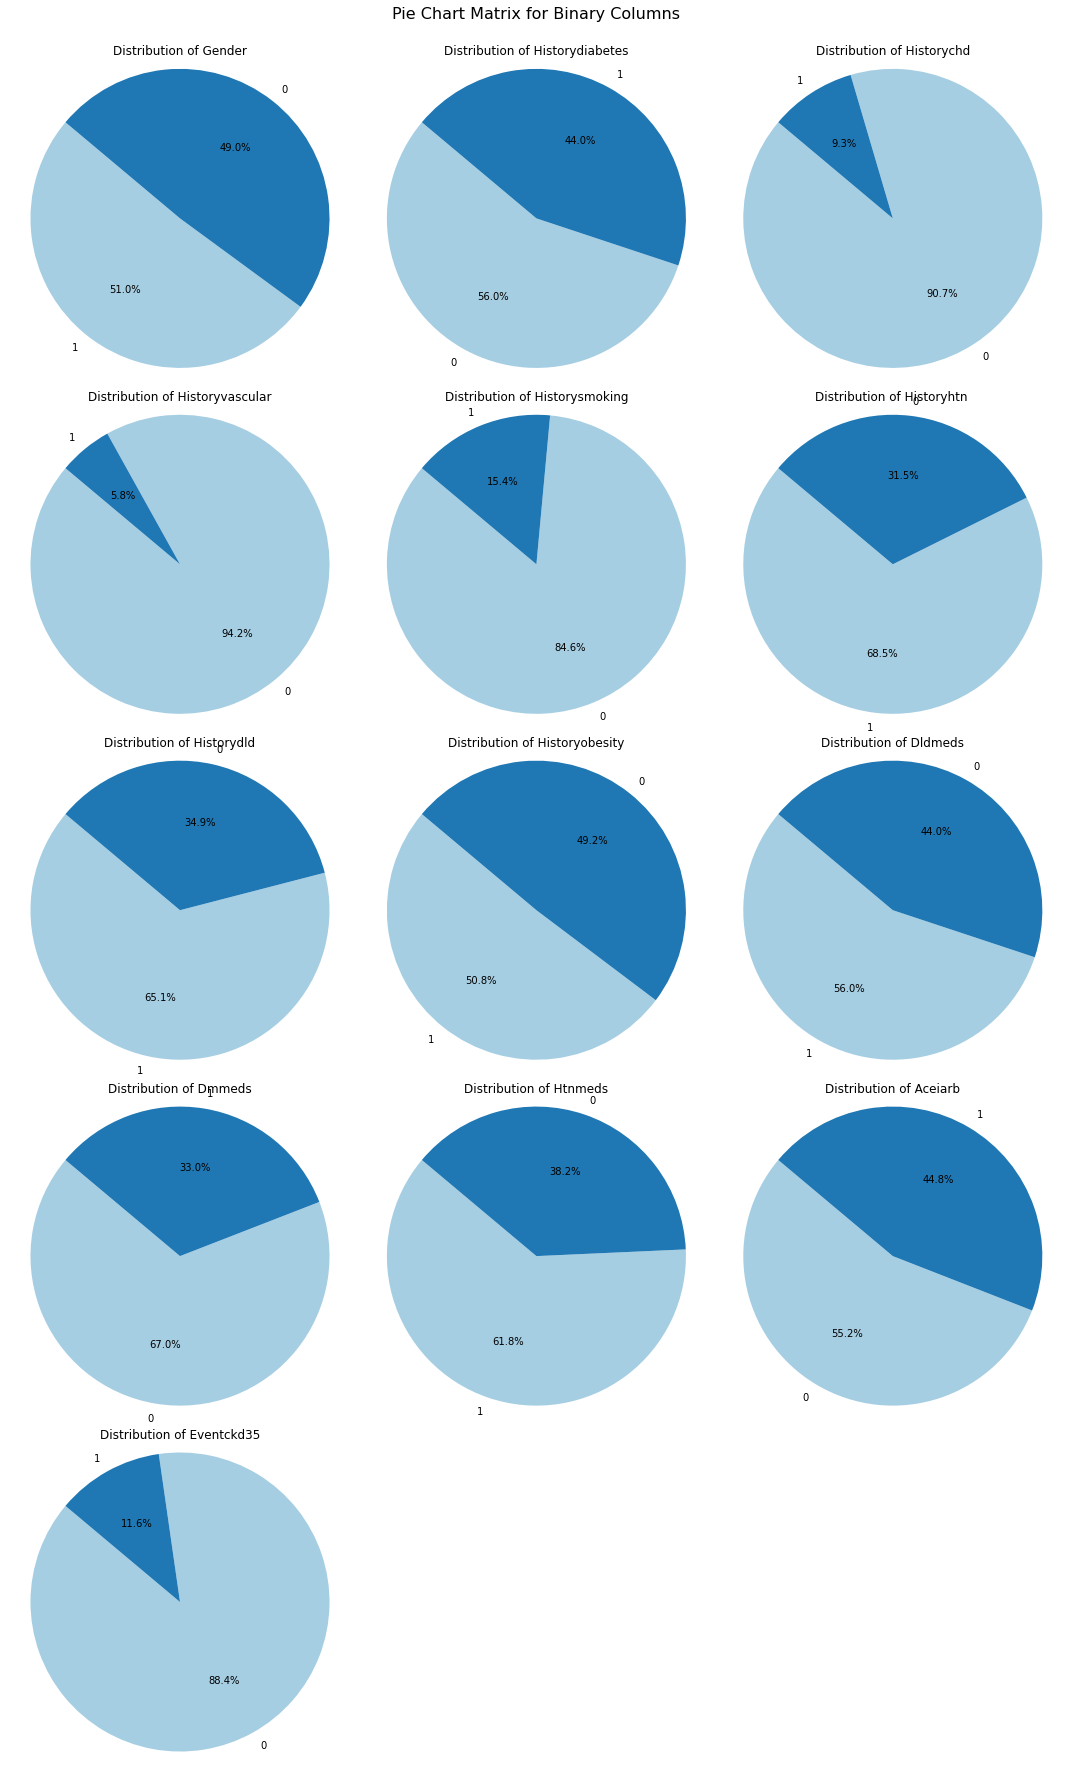

In [31]:
plot_pie_chart_matrix(data)

### <blockquote> 'TriglyceridesBaseline' </blockquote>

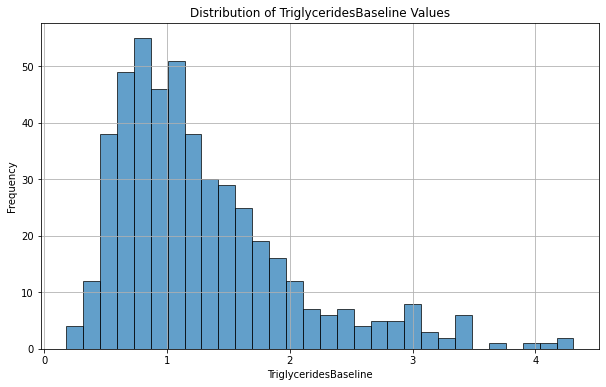

In [32]:
plot_histogram(data, 'TriglyceridesBaseline')

In [33]:
data[data['TriglyceridesBaseline']> 3]

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
7         0           44                 0                0           0   
10        0           49                 0                0           0   
43        0           47                 0                0           0   
48        1           45                 0                0           0   
52        1           38                 0                1           0   
61        0           32                 0                0           0   
89        0           49                 0                1           0   
96        1           61                 1                1           1   
194       0           63                 1                0           0   
231       1           50                 1                0           0   
260       1           77                 2                1           0   
270       0           53                 1                1           0   
274       0           31                 0                0           0   
276       0           58                 1                1           0   
278       1           73                 2                1           0   
299       0           54                 1                1           0   
377       1           42                 0                0           0   
413       1           30                 0                0           0   
425       1           44                 0                0           0   
429       1           69                 2                1           1   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
7                  0               0            0           1               1   
10                 0               0            1           1               1   
43                 0               0            1           1               0   
48                 0               0            1           1               1   
52                 0               0            1           1               1   
61                 0               0            0           1               1   
89                 0               0            0           1               1   
96                 0               1            1           1               1   
194                0               0            1           1               0   
231                0               0            1           1               1   
260                0               1            1           1               0   
270                0               0            0           1               1   
274                0               0            0           1               1   
276                0               0            1           1               1   
278                0               0            0           1               0   
299                0               0            1           1               1   
377                0               1            1           1               0   
413                0               0            1           1               1   
425                0               1            0           1               1   
429                0               0            1           1               1   

     ...  CholesterolBaseline  TriglyceridesBaseline     HgbA1C  \
7    ...                  6.6                 3.9000   5.800000   
10   ...                  6.8                 3.0600   6.200000   
43   ...                  5.2                 3.0800   5.900000   
48   ...                  6.8                 3.3800   6.400000   
52   ...                  4.5                 3.4700   7.200000   
61   ...                  4.4                 4.1600   6.100000   
89   ...                  4.2                 3.3900   5.860000   
96   ...                  4.6                 3.4200   7.500000   
194  ...                  5.3                 3.0600   5.000000   
231  ...                  5.1                 4.2400   5.

> #### After extracting abnormal values (greater than 3) you can see that the HistoryVascular and HistoryDLD columns have the same values for all the abnormal rows.
> #### We will try to divide the data according to the HistoryDLD binary column and see if there is a certain group that defines the abnormal values in the TriglyceridesBaseline column.
> #### We will not divide the data by the HistoryVascular column. It can be seen that most of the absolute values are in the same class according to his pie chart, so it makes sense that all the outliers would contain the same value.

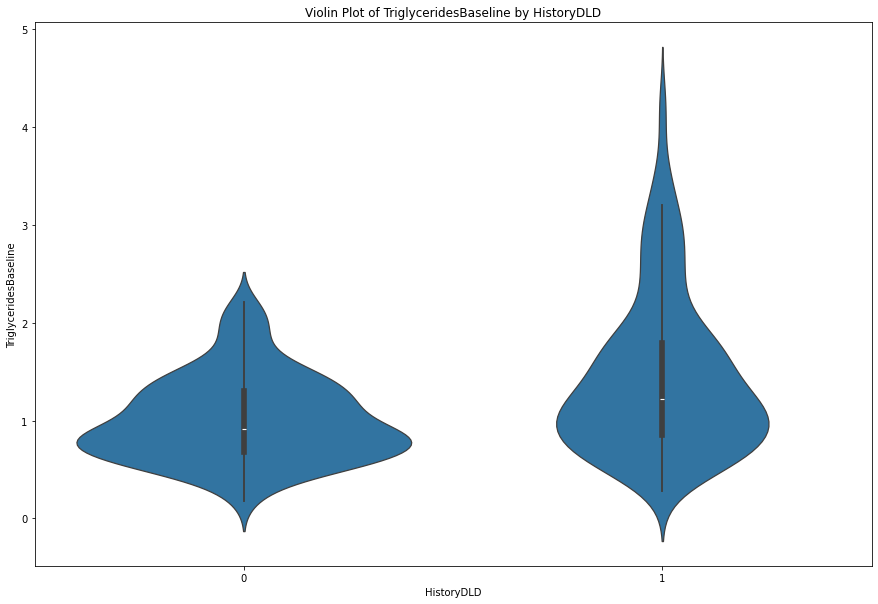

In [34]:
plot_violin(data, 'HistoryDLD', 'TriglyceridesBaseline')

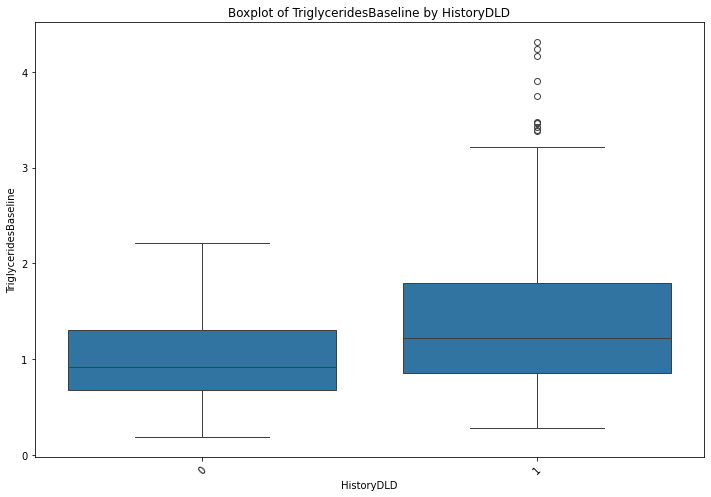

In [35]:
plot_numeric_vs_categorical(data,'TriglyceridesBaseline', 'HistoryDLD')

---
> ### Conclusion 1.1:
> #### The 'HistoryDLD' column has an effect on the range of values in the 'TriglyceridesBaseline' column. It can be seen that **there are abnormal values in size for those whose value in the 'HistoryDLD' column is equal to 1.**
---

### <blockquote> 'HgbA1C' </blockquote>

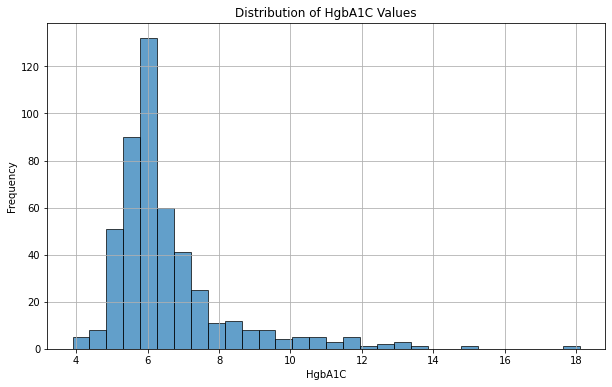

In [36]:
plot_histogram(data, 'HgbA1C')

In [37]:
data[data['HgbA1C']> 10]

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
69        1           57                 1                1           1   
86        0           58                 1                1           0   
105       1           44                 0                1           0   
132       0           53                 1                1           1   
157       1           56                 1                1           1   
222       1           64                 1                1           0   
226       0           52                 1                1           0   
227       0           64                 1                1           0   
268       0           61                 1                1           0   
301       0           74                 2                1           0   
302       1           64                 1                1           0   
307       0           56                 1                1           0   
309       0           65                 2                1           0   
318       1           61                 1                1           0   
322       1           55                 1                1           1   
355       0           53                 1                1           0   
356       1           54                 1                1           0   
371       1           51                 1                1           0   
373       1           75                 2                1           1   
386       1           39                 0                1           0   
421       1           56                 1                1           0   
429       1           69                 2                1           1   
440       1           58                 1                1           0   
460       1           66                 2                1           1   
468       1           55                 1                1           0   
479       1           58                 1                1           1   
488       1           44                 0                1           0   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
69                 1               1            1           1               0   
86                 0               0            1           1               1   
105                0               0            1           1               1   
132                0               0            1           1               1   
157                0               0            1           1               0   
222                0               0            1           1               0   
226                0               0            1           1               1   
227                0               0            0           1               0   
268                0               0            1           1               1   
301                0               0            1           1               0   
302                0               0            1           1               1   
307                0               0            1           1               1   
309                0               0            1           1               1   
318                0               1            1           1               1   
322                0               0            1           1               1   
355                0               0            1           1               1   
356                0               0            0           0               0   
371                0               1            0           1               1   
373                0               1            1           1               1   
386                0               1            1           1               0   
421                0               1            1           1               0   
429                0               0            1           1               1   
440                0               0     

> #### We can see that there are quite a few exceptions in the 'HgbA1C' column. After examining the abnormal data it can be seen that:

> #### In the 'HistoryDLD' and 'HistoryDiabetes' columns the vast majority of exceptions belong to the same class.

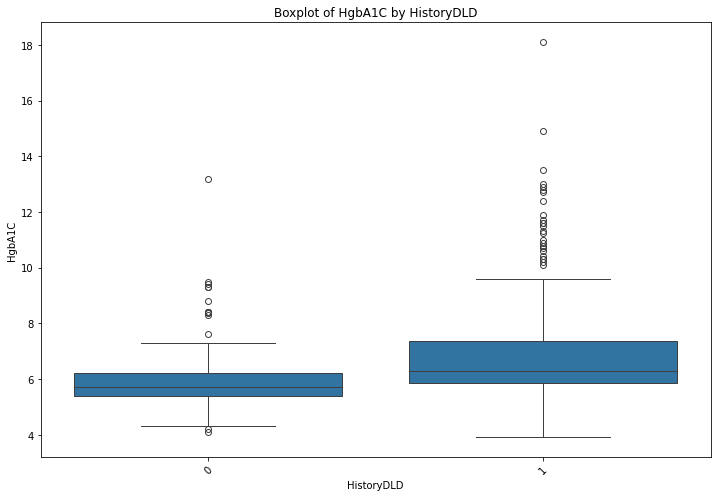

In [38]:
plot_numeric_vs_categorical(data,'HgbA1C', 'HistoryDLD')

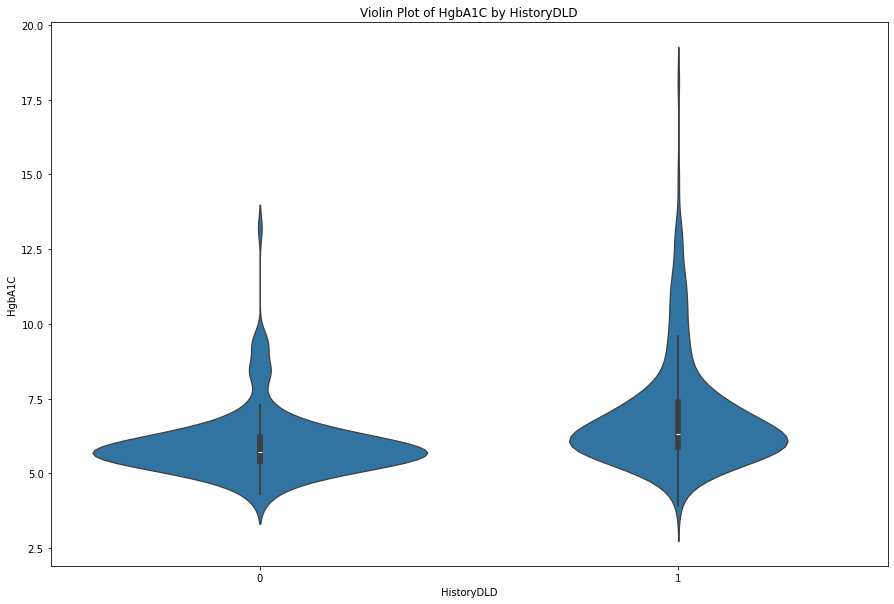

In [39]:
plot_violin(data, 'HistoryDLD', 'HgbA1C')

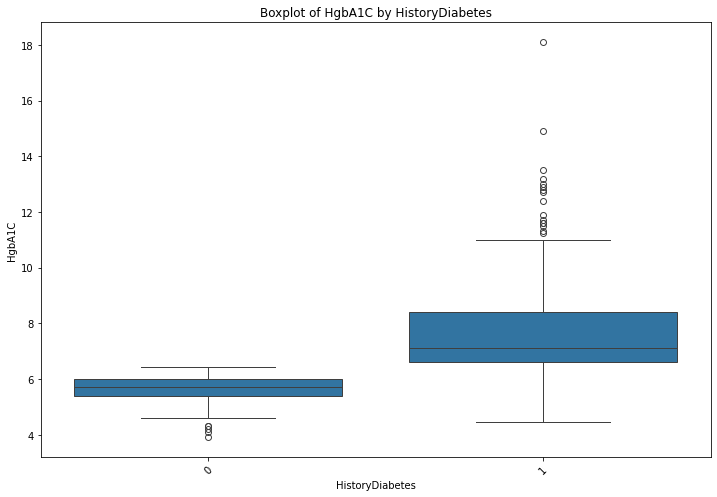

In [40]:
plot_numeric_vs_categorical(data,'HgbA1C', 'HistoryDiabetes')

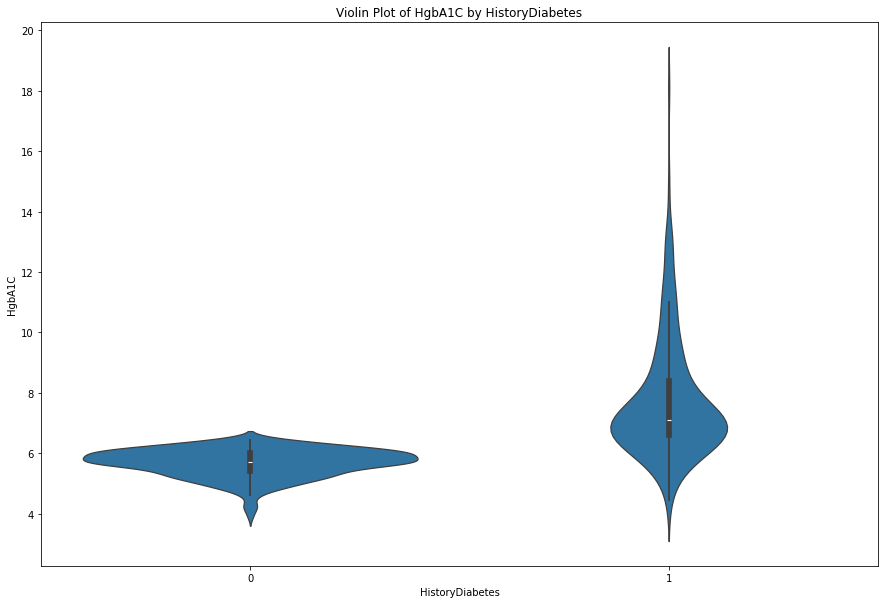

In [41]:
plot_violin(data, 'HistoryDiabetes', 'HgbA1C')

### We will examine whether there is a significant relationship between the 'HistoryDLD' and 'HistoryDiabetes' columns using a chi-square test and a graphical test

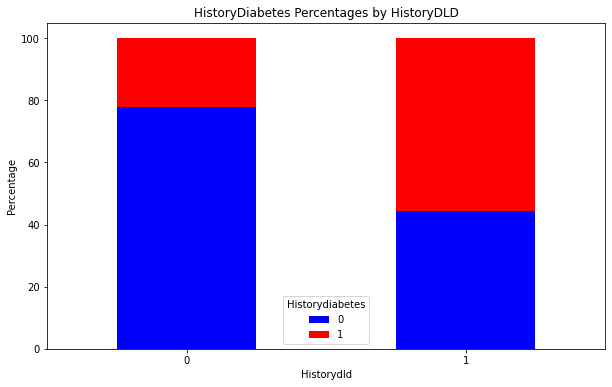

In [42]:
plot_by_category(data, 'HistoryDLD','HistoryDiabetes')

In [43]:
chi_square_test(data,'HistoryDLD','HistoryDiabetes')

P-value: 2.4134503944434205e-12
There is a statistically significant association between the two variables.


---
> ### Conclusion 1.2:
> #### After segmenting the column 'HgbA1C' according to the columns 'HistoryDLD' and 'HistoryDiabetes' it can be seen that **the abnormal values clearly characterize only one of the categories ('HistoryDLD' = 0, 'HistoryDLD' = 0).**
> #### After examining the dependence between the 2 explanatory variables 'HistoryDLD' and 'HistoryDiabetes' it can be seen that there is a statistically significant relationship between them (chi-square test).
---

### <blockquote> 'BMIBaseline' </blockquote>

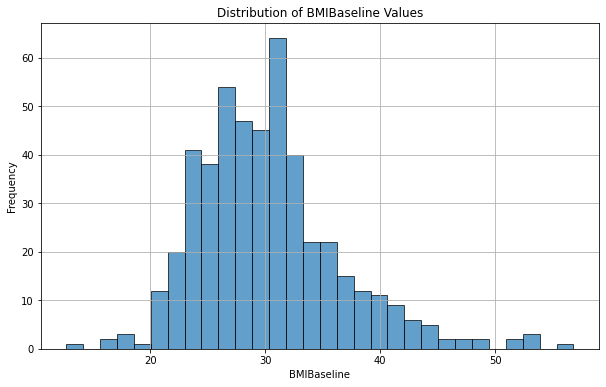

In [44]:
plot_histogram(data, 'BMIBaseline')

In [45]:
data[data['BMIBaseline']> 45]

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
50        0           50                 1                0           0   
54        0           51                 1                1           0   
86        0           58                 1                1           0   
135       0           44                 0                0           0   
145       0           58                 1                0           0   
196       1           64                 1                1           0   
274       0           31                 0                0           0   
371       1           51                 1                1           0   
410       1           33                 0                0           0   
425       1           44                 0                0           0   
459       1           29                 0                0           0   
480       1           50                 1                1           0   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
50                 0               0            1           1               1   
54                 0               0            0           1               1   
86                 0               0            1           1               1   
135                0               0            1           1               1   
145                0               0            1           1               1   
196                0               1            1           0               1   
274                0               0            0           1               1   
371                0               1            0           1               1   
410                0               1            0           0               1   
425                0               1            0           1               1   
459                0               1            1           1               1   
480                0               1            1           0               1   

     ...  CholesterolBaseline  TriglyceridesBaseline  HgbA1C  \
50   ...                  7.3                 1.8400    6.20   
54   ...                  4.5                 1.1900    6.90   
86   ...                  6.9                 1.5500   11.60   
135  ...                  6.0                 1.4900    5.90   
145  ...                  3.9                 1.0200    5.91   
196  ...                  4.2                 1.2300    7.60   
274  ...                  4.5                 3.7500    6.20   
371  ...                  6.4                 2.1100   10.70   
410  ...                  5.5                 1.8700    5.60   
425  ...                  5.0                 3.0500    6.00   
459  ...                  6.3                 1.6200    5.50   
480  ...                  5.2                 1.1299    6.60   

     CreatnineBaseline  eGFRBaseline  sBPBaseline  dBPBaseline  BMIBaseline  \
50                62.0    101.152672          161           89    46.921475   
54                48.0    109.423858          129           82    50.988694   
86                45.0    106.408963          144           82    48.849525   
135               56.0    109.255118          132           88    56.797436   
145               47.0    104.897451          146           82    49.125693   
196               63.0     99.018723          152           90    51.790634   
274               55.0    120.413753          120           70    46.648301   
371               64.0    107.786926          132           86    52.393186   
410               71.0    117.206690          111           75    45.847751   
425               82.0     99.859410          118           79    45.632774   
459               63.0    126.617468          136           93    52.392375   
480               81.0     97.168847          130           88    52.525253   

     TimeToEventMonths  EventCKD35  
50                  95           0  
54                  65           0  
86 

#### We will examine the values from the 'BMIBaseline' column divided by the 'HistoryCHD' column.

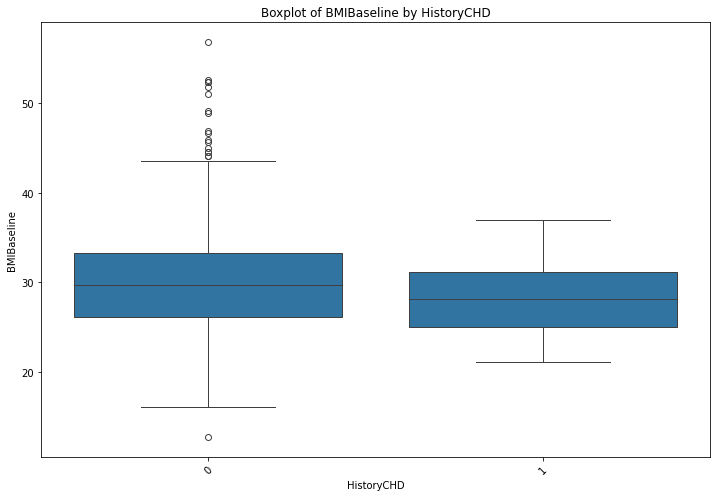

In [46]:
plot_numeric_vs_categorical(data,'BMIBaseline', 'HistoryCHD')

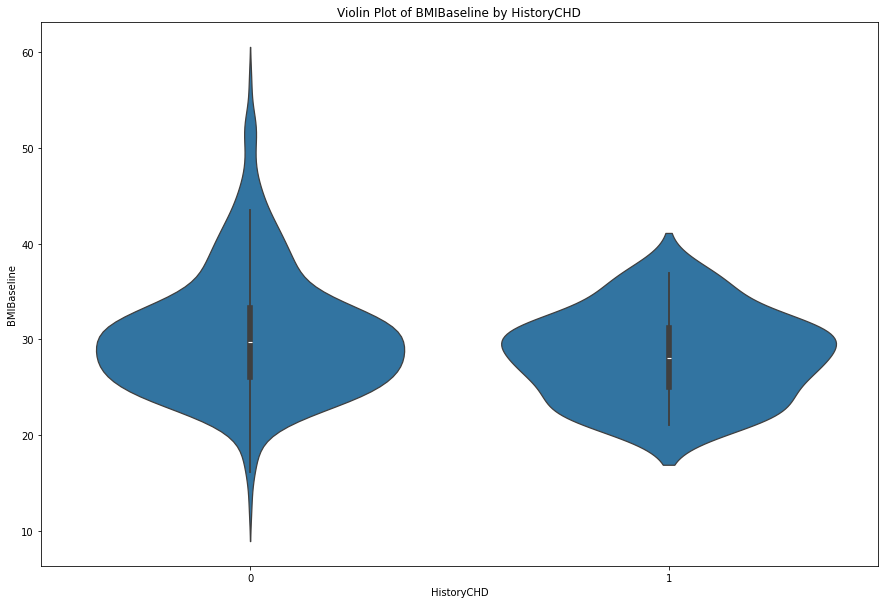

In [47]:
plot_violin(data, 'HistoryCHD', 'BMIBaseline')

---
> ### Conclusion 1.3:
> #### It can be seen that all the outlier values ​​from the column 'BMIBaseline' belong to the class 'HistoryCHD' = 0.
---

### <blockquote> 'TimeToEventMonths' </blockquote>

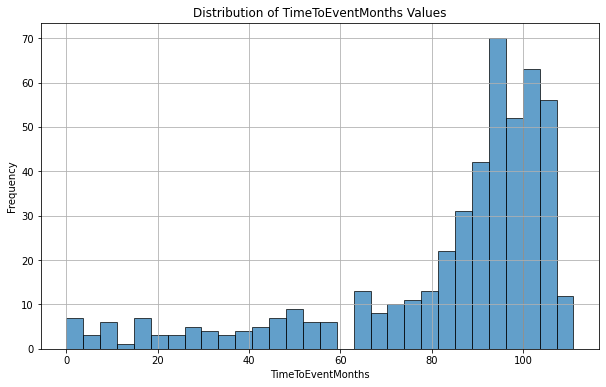

In [48]:
plot_histogram(data, 'TimeToEventMonths')

In [49]:
data[data['TimeToEventMonths']<45].head(20)

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
67        0           61                 1                1           0   
73        1           69                 2                0           0   
96        1           61                 1                1           1   
97        0           46                 0                0           0   
111       0           55                 1                1           1   
115       0           68                 2                1           0   
166       0           41                 0                0           0   
173       0           66                 2                1           1   
191       0           47                 0                0           0   
204       0           78                 2                1           0   
211       1           75                 2                0           0   
214       1           56                 1                1           0   
216       1           48                 0                0           0   
228       1           71                 2                1           1   
241       1           73                 2                1           1   
245       1           79                 2                1           0   
251       0           59                 1                0           0   
254       0           26                 0                0           0   
256       0           45                 0                1           0   
281       1           60                 1                1           1   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
67                 0               0            1           1               0   
73                 0               1            1           0               0   
96                 0               1            1           1               1   
97                 0               0            1           1               1   
111                0               0            1           1               1   
115                0               0            1           1               1   
166                0               0            0           1               1   
173                0               0            1           1               0   
191                0               0            1           0               1   
204                0               0            1           1               1   
211                0               1            1           1               0   
214                0               0            1           0               1   
216                0               0            1           1               0   
228                0               0            1           1               0   
241                0               0            1           1               1   
245                0               0            1           1               0   
251                0               0            1           0               0   
254                0               0            0           0               0   
256                0               0            1           1               1   
281                0               1            1           1               1   

     ...  CholesterolBaseline  TriglyceridesBaseline    HgbA1C  \
67   ...                  4.1                 1.6500  9.600000   
73   ...                  5.7                 1.6900  6.100000   
96   ...                  4.6                 3.4200  7.500000   
97   ...                  6.8                 0.7800  6.100000   
111  ...                  3.0                 1.0700  6.870000   
115  ...                  5.8                 1.9100  7.100000   
166  ...                  4.3                 0.6700  5.400000   
173  ...                  2.9                 0.8900  8.500000   
191  ...                  5.3                 1.4500  6.400000   
204  ...                  5.7                 1.2500  6.860000   
2

#### We were unable to find a common denominator for the anomalous values in the 'TimeToEventMonths' column, even after eliminating them from the analysis.

## ---------------------------------------------------------------------------------------------------------------------
### **Interim conclusions after checking for exceptions:**
> #### Examine the columns with the most outliers to see if the outliers can be characterized by some common denominator to facilitate the future machine learning process. The conclusions we reached are:

> ##### The outlier values in the 'TriglyceridesBaseline' column belong to the 'HistoryDLD' class equal to 1.

> ##### The outlier values in the 'HgbA1C' column belong to the 'HistoryDLD' = 1, 'HistoryDiabetes' = 1 classes.

> ##### There is a statistically significant dependence according to the chi-square test between the categorical variables 'HistoryDLD' and 'HistoryDiabetes'.

> ##### The outlier values from the column 'BMIBaseline' belong to the class 'HistoryCHD' = 0.

## ---------------------------------------------------------------------------------------------------------------------

## Coding of categorical variables & standardization of numerical variables

In [50]:
numeric_col = ['AgeBaseline','CholesterolBaseline', 'TriglyceridesBaseline','HgbA1C', 'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline','dBPBaseline', 'BMIBaseline', 'TimeToEventMonths']

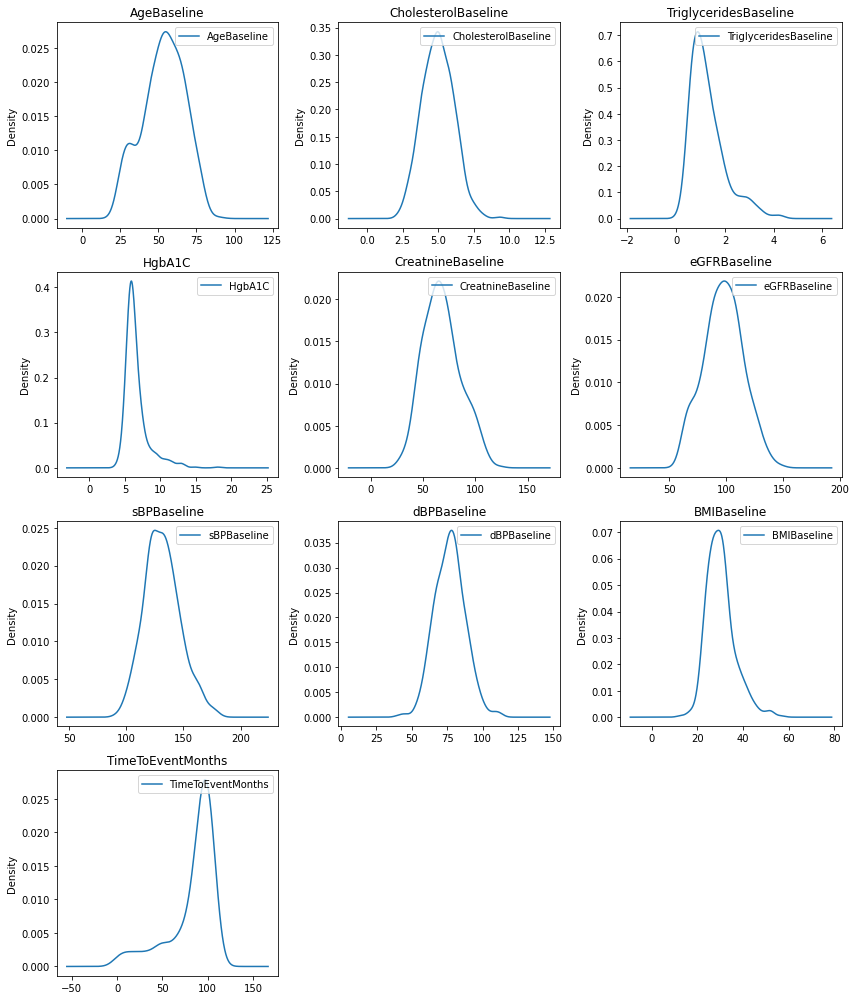

In [51]:
plot_density_matrix(data, numeric_col) 

In [52]:
original_data = data
data = standardize_data(data, numeric_col)
data

Gender  AgeBaseline  Age.3.categories  HistoryDiabetes  HistoryCHD  \
0         0     0.777901                 1                0           0   
1         0    -0.095595                 1                0           0   
2         0     0.195570                 1                0           0   
3         0     0.341153                 1                0           0   
4         0     0.705110                 1                1           0   
..      ...          ...               ...              ...         ...   
486       1    -2.060962                 0                0           0   
487       1    -0.605135                 0                0           0   
488       1    -0.677926                 0                1           0   
489       1    -0.896300                 0                0           0   
490       1    -2.133754                 0                0           0   

     HistoryVascular  HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity  \
0                  0               0            1           1               1   
1                  0               0            1           1               1   
2                  0               0            1           1               1   
3                  0               0            0           1               1   
4                  0               0            1           1               1   
..               ...             ...          ...         ...             ...   
486                0               0            0           0               0   
487                0               0            1           0               1   
488                0               0            0           1               1   
489                1               1            1           1               0   
490                0               0            0           0               0   

     ...  CholesterolBaseline  TriglyceridesBaseline    HgbA1C  \
0    ...            -0.165977              -0.514873 -0.403407   
1    ...             1.290569               0.747047 -0.344028   
2    ...             1.290569               0.623599 -0.403407   
3    ...             0.107126              -0.103377 -0.640921   
4    ...             0.016092              -0.254259  0.522900   
..   ...                  ...                    ...       ...   
486  ...             0.289194              -0.953801 -0.531048   
487  ...             0.835398               0.047505 -0.284649   
488  ...             1.299672              -0.034794  2.803039   
489  ...            -0.894249              -0.226963 -0.531048   
490  ...            -2.505552              -0.871502 -1.353465   

     CreatnineBaseline  eGFRBaseline  sBPBaseline  dBPBaseline  BMIBaseline  \
0            -0.513883     -0.250900     0.789369     0.935993     1.599933   
1            -0.910035      0.474167     1.044465     1.308766     2.304983   
2            -0.627069      0.126893     1.108239     0.842800     1.661427   
3            -0.174323     -0.424936    -0.996303    -0.834679     0.288770   
4             0.108643     -1.038485     0.024081    -1.300645     0.084402   
..                 ...           ...          ...          ...          ...   
486           0.278422      1.444065    -0.294789    -0.275520    -0.996929   
487          -0.061137      0.734664     1.172013     3.265825     0.473612   
488          -0.100752      0.807571    -0.358563     0.563220     0.800498   
489           1.410286     -0.582919    -0.804981    -1.021066    -1.320738   
490          -0.174323      1.843569    -0.677433    -2.046192    -1.451317   

     TimeToEventMonths  EventCKD35  
0             0.570378           0  
1             0.879757           0  
2             0.183654           0  
3             0.763740           0  
4             0.841084           0  
..                 ...         ...  
486           0.725067           0  
487           0.415688           0  
488          -3.219517           0  
489          -1.865

## EDA

#### we can see a Gaussian distribution in the columns, 'HgbA1C', 'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline', 'dBPBaseline', 'BMIBaseline' therefore according to linear assumptions we will examine relationships in correlation according to the Pearson methodology

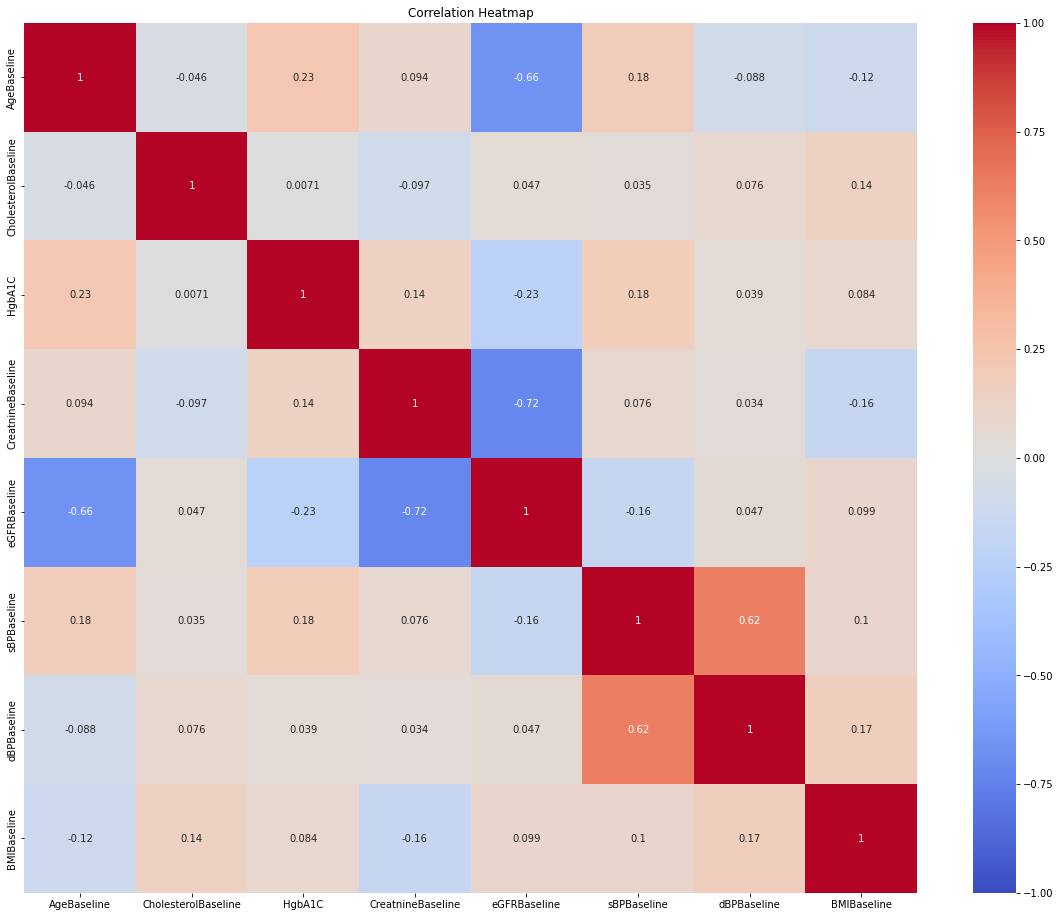

In [53]:
numeric_col_p = ['AgeBaseline','CholesterolBaseline','HgbA1C', 'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline','dBPBaseline', 'BMIBaseline']
plot_correlation_heatmap(data, numeric_col_p, "pearson")

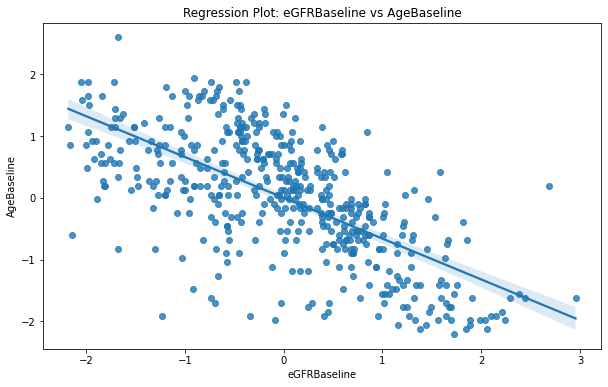

In [54]:
plot_regression(data, 'eGFRBaseline', 'AgeBaseline')

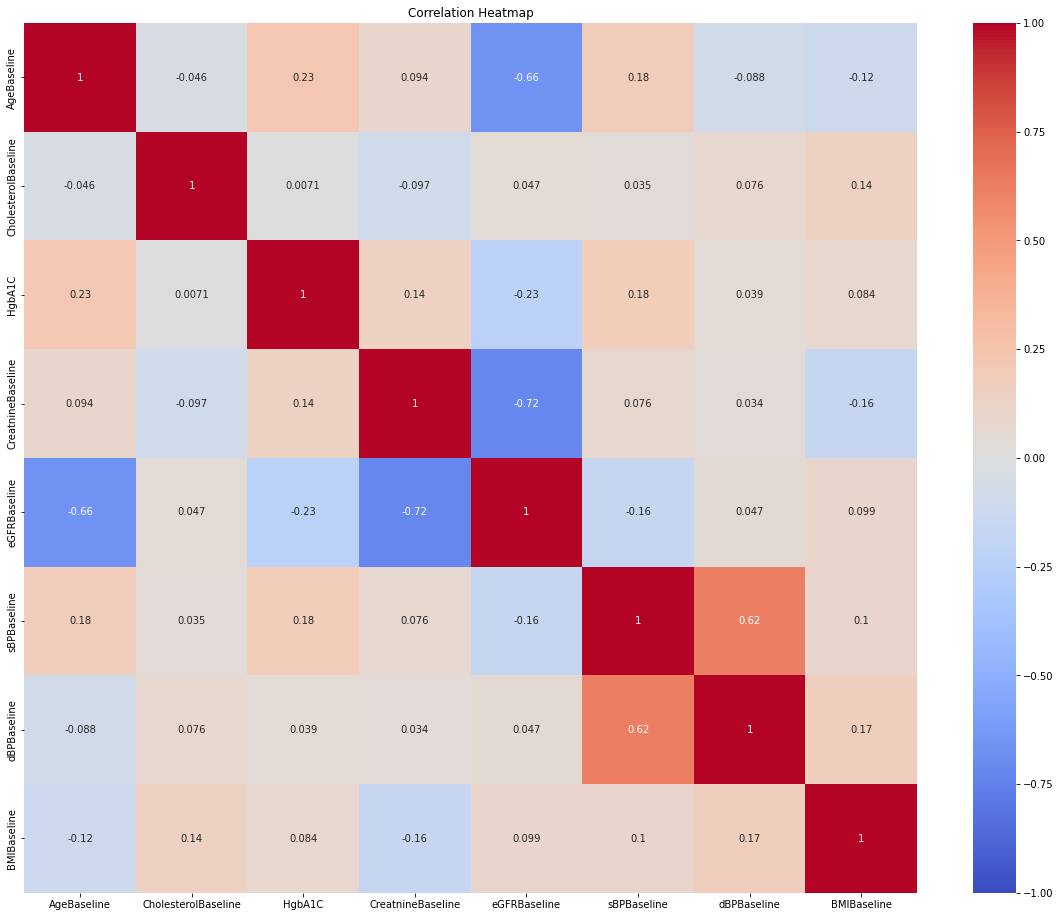

In [55]:
plot_correlation_heatmap(data, numeric_col_p, "pearson")

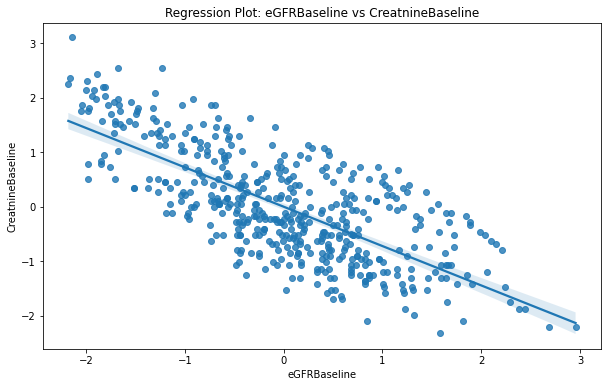

In [56]:
plot_regression(data, 'eGFRBaseline', 'CreatnineBaseline')

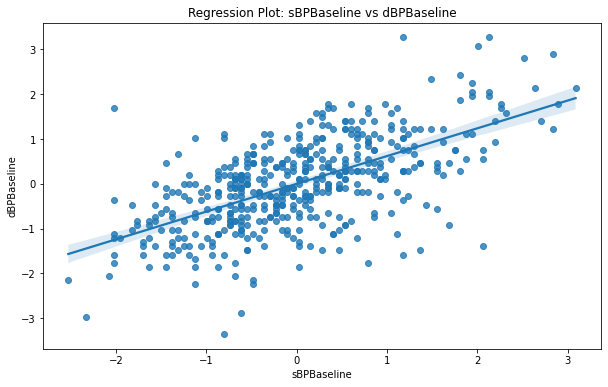

In [57]:
plot_regression(data, 'sBPBaseline','dBPBaseline')

#### For numerical columns with a non-Gaussian distribution we will check correlation using

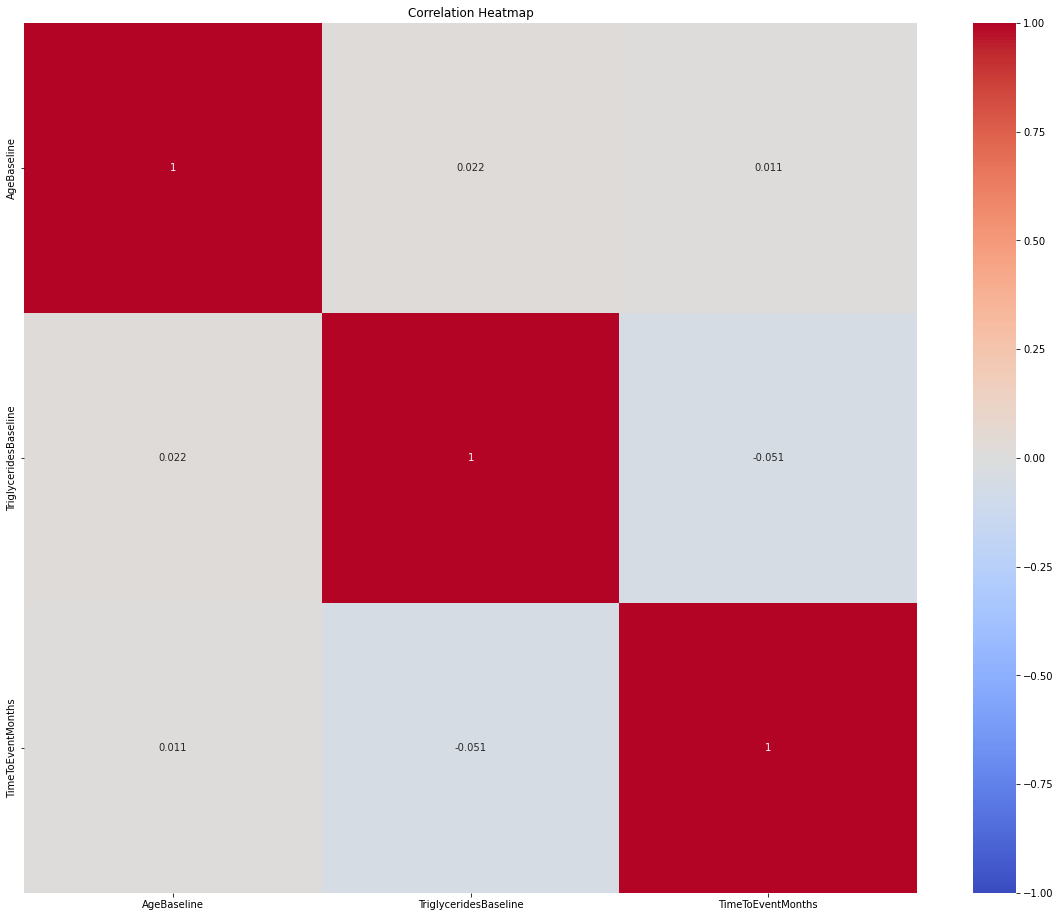

In [58]:
numeric_col_s = ['AgeBaseline','TriglyceridesBaseline','TimeToEventMonths']
plot_correlation_heatmap(data, numeric_col_s, "kendall")

#### There are moderate negative linear relationships (according to Pearson) between the columns 'eGFRBaseline' and 'AgeBaseline' & 'eGFRBaseline' and 'CreatnineBaseline'.
#### There is a moderately positive linear relationship (according to Pearson) between the columns 'dBPBaseline' and 'sBPBaseline'.
### We will examine whether dividing the data according to the insights from the outliers can help.

#### Data division using 'HistoryCHD'

In [59]:
data_1 = data[data['HistoryCHD'] == 1]
data_0 = data[data['HistoryCHD'] == 0]

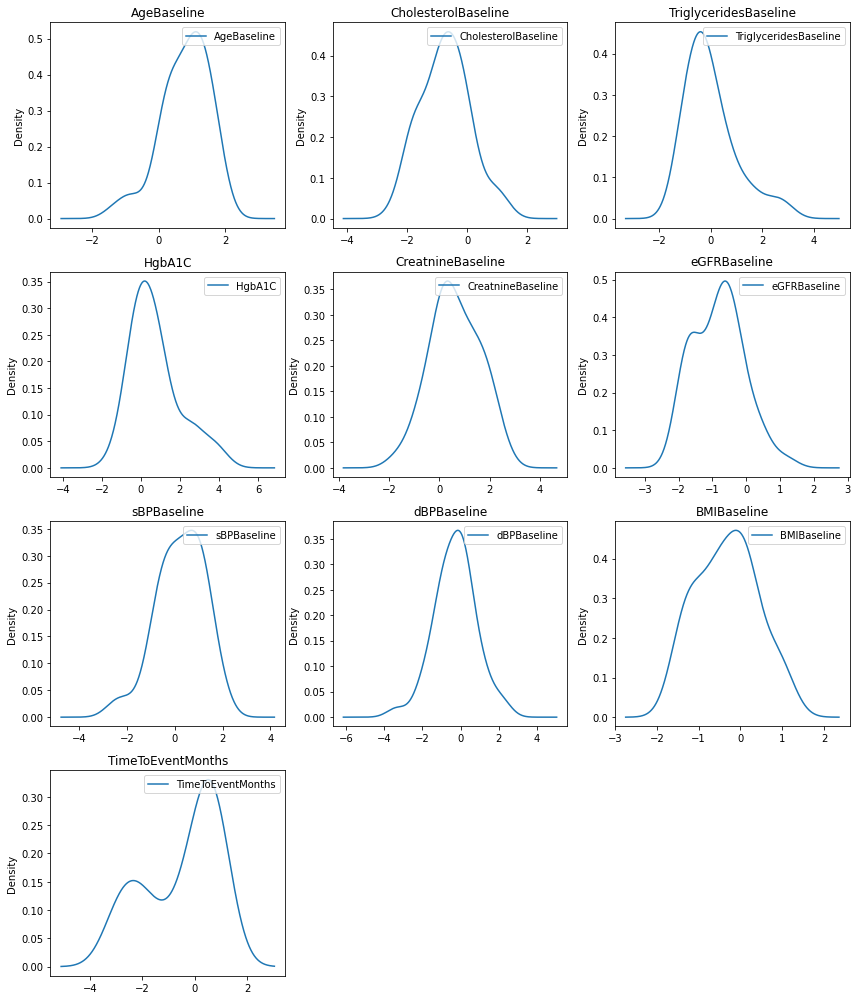

In [60]:
plot_density_matrix(data_1, numeric_col)

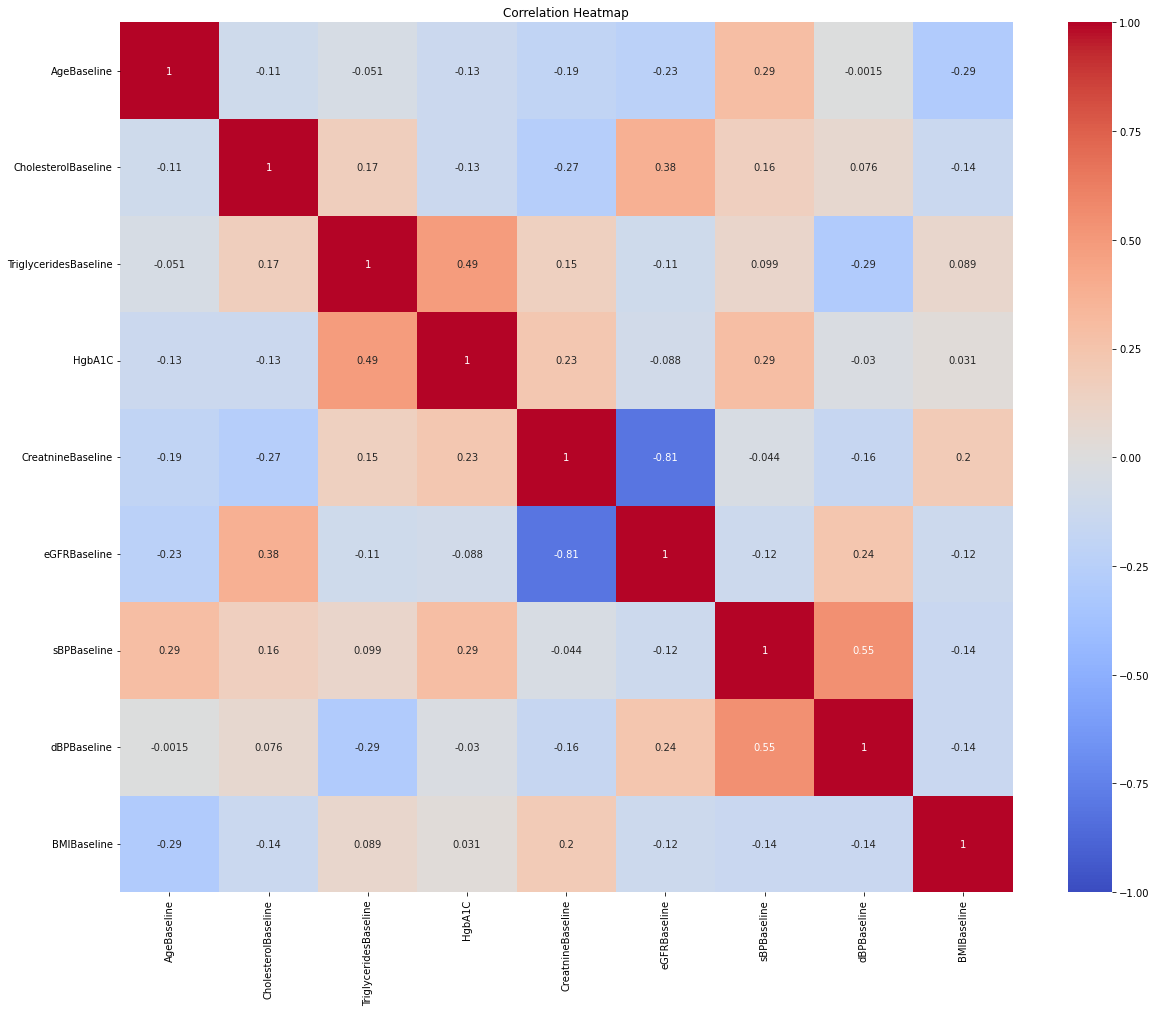

In [61]:
numeric_col_p = ['AgeBaseline','CholesterolBaseline', 'TriglyceridesBaseline','HgbA1C', 'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline','dBPBaseline', 'BMIBaseline']
plot_correlation_heatmap(data_1, numeric_col_p, "pearson")

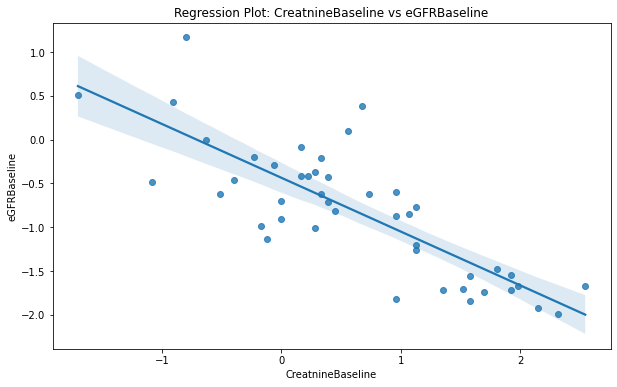

In [62]:
plot_regression(data_1, 'CreatnineBaseline', 'eGFRBaseline')

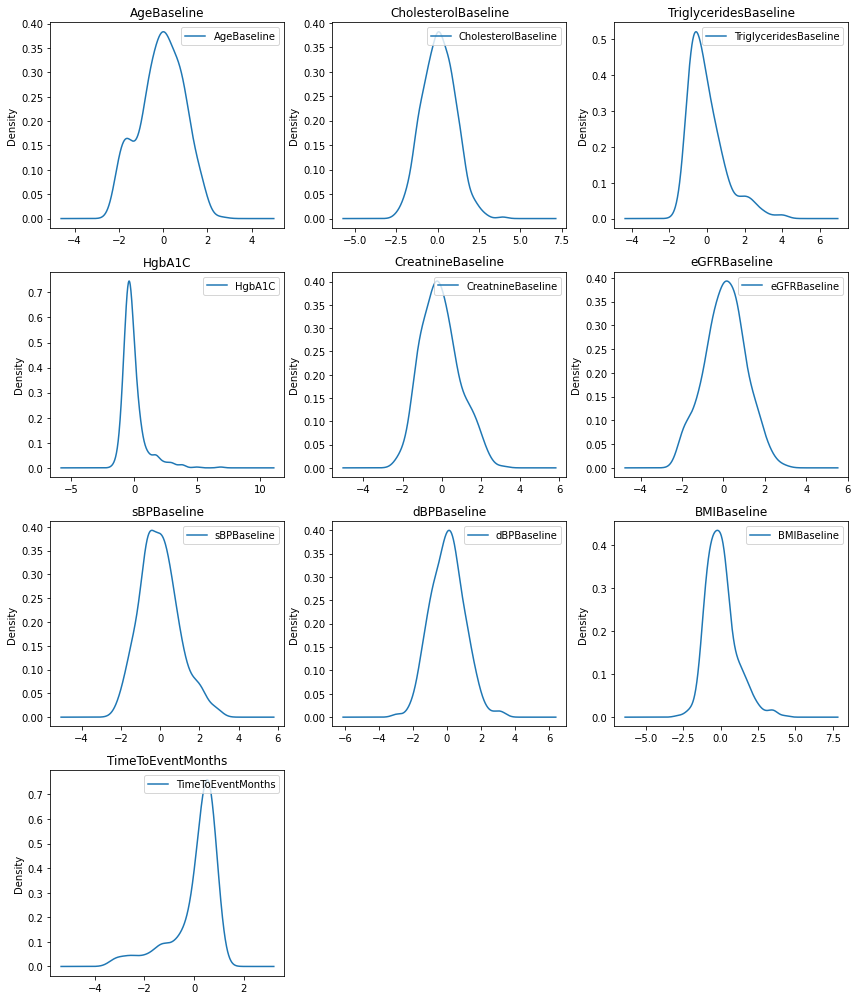

In [63]:
plot_density_matrix(data_0, numeric_col)

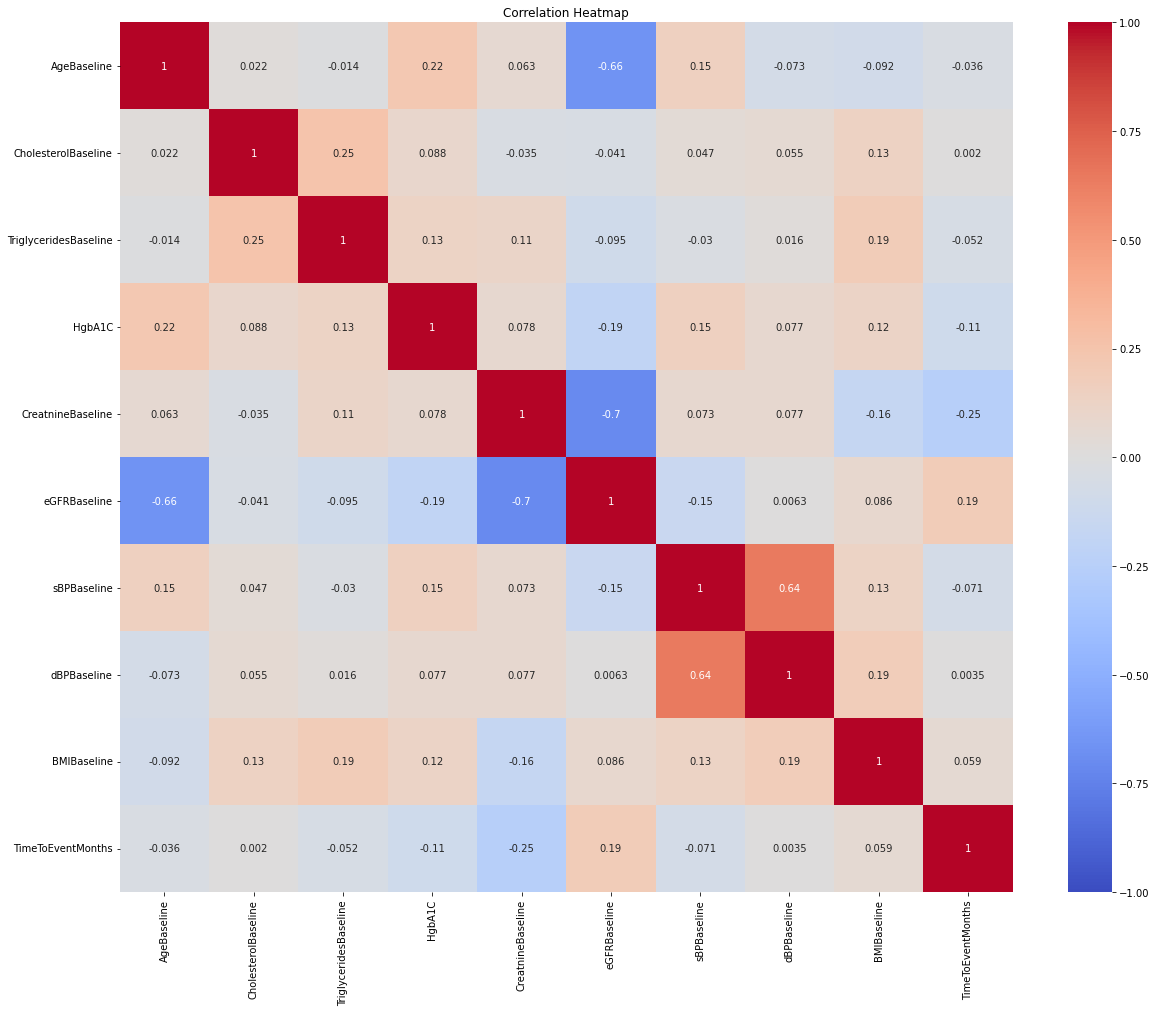

In [64]:
plot_correlation_heatmap(data_0, numeric_col, "pearson")

#### Data division using 'EventCKD35'

In [65]:
data_1 = data[data['EventCKD35'] == 1]
data_0 = data[data['EventCKD35'] == 0]

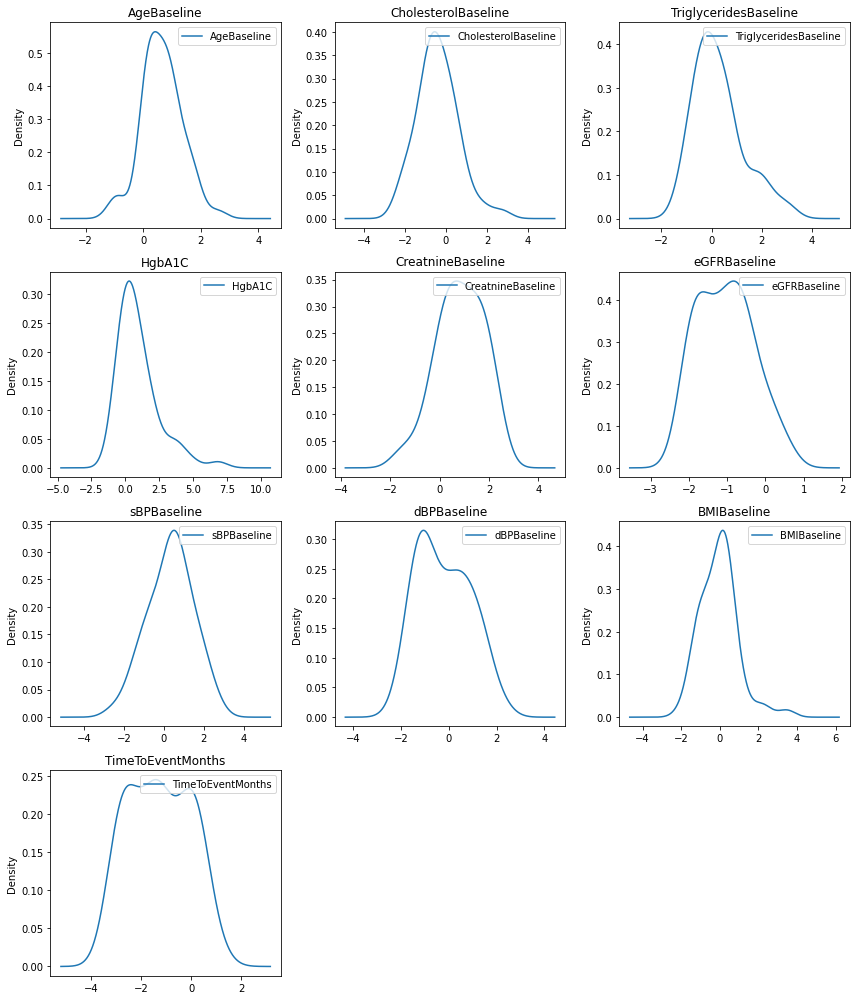

In [66]:
plot_density_matrix(data_1, numeric_col)

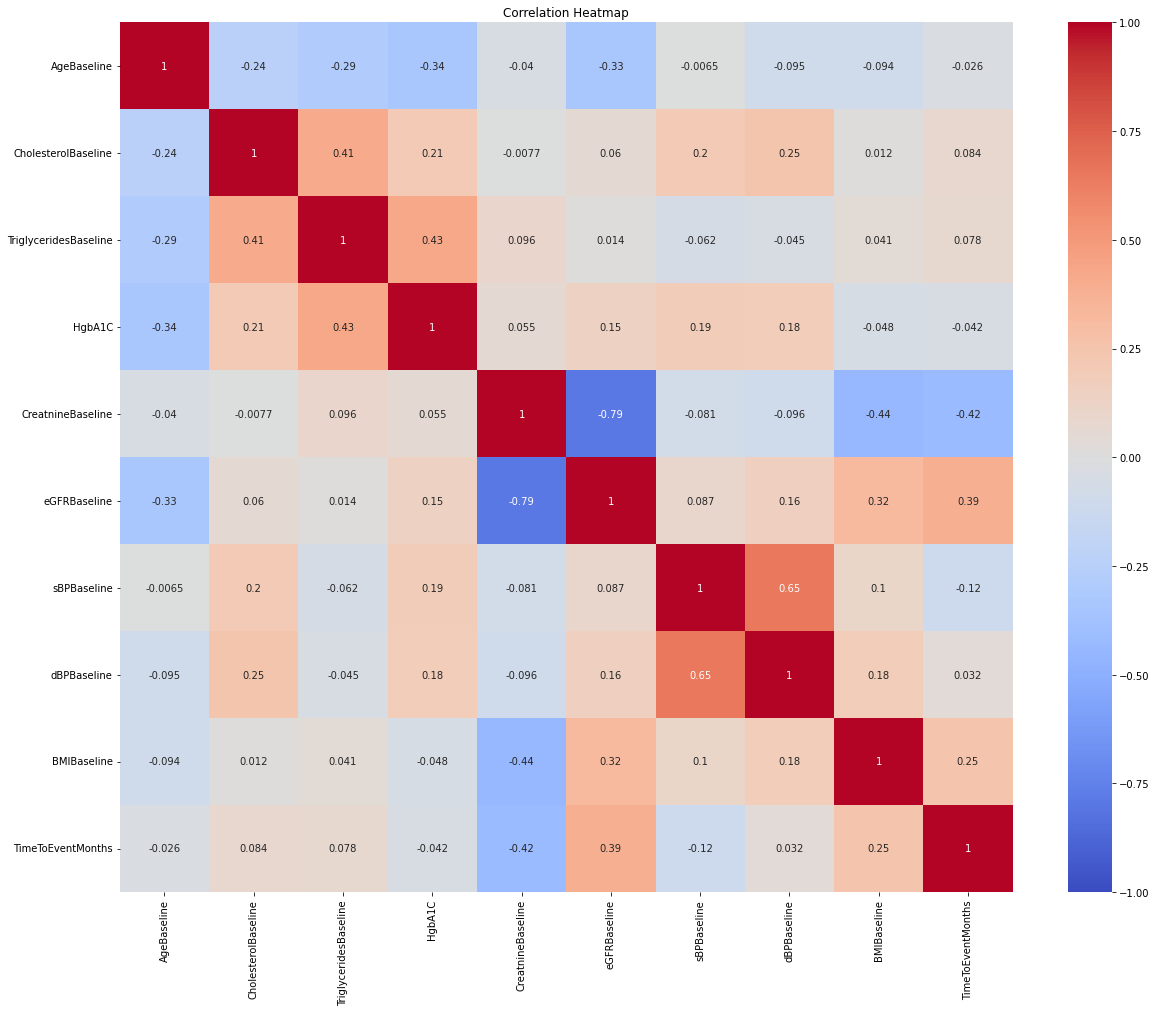

In [67]:
plot_correlation_heatmap(data_1, numeric_col, "pearson")

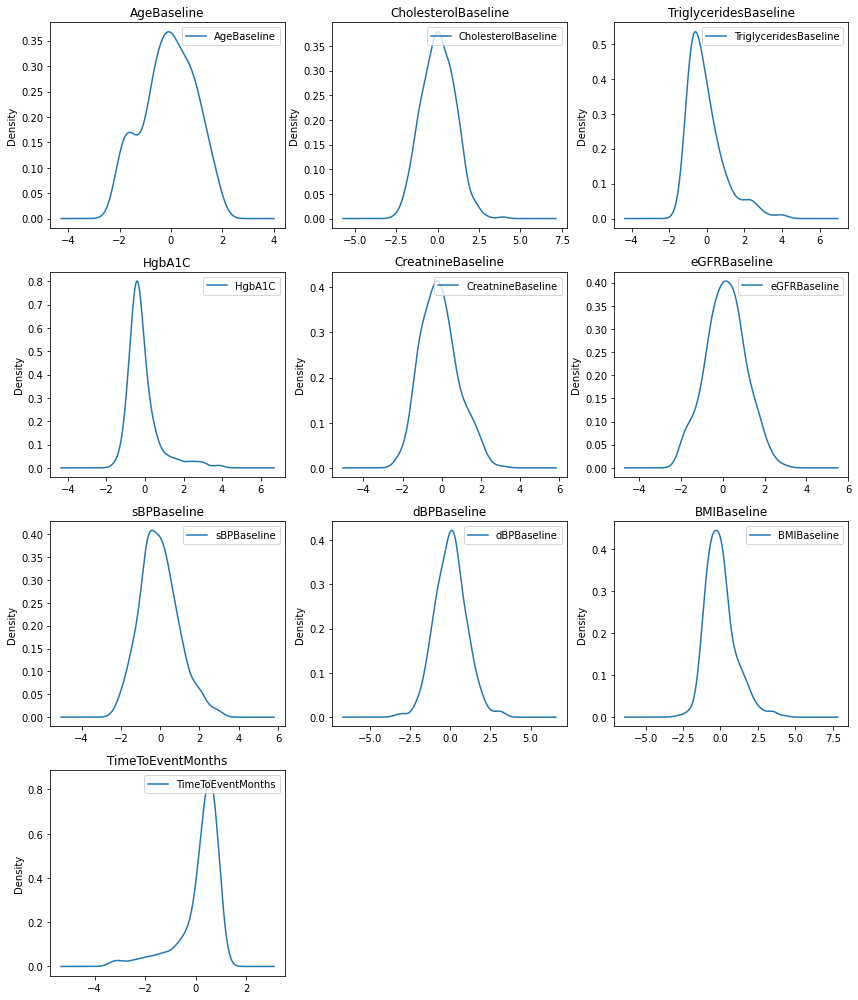

In [68]:
plot_density_matrix(data_0, numeric_col)

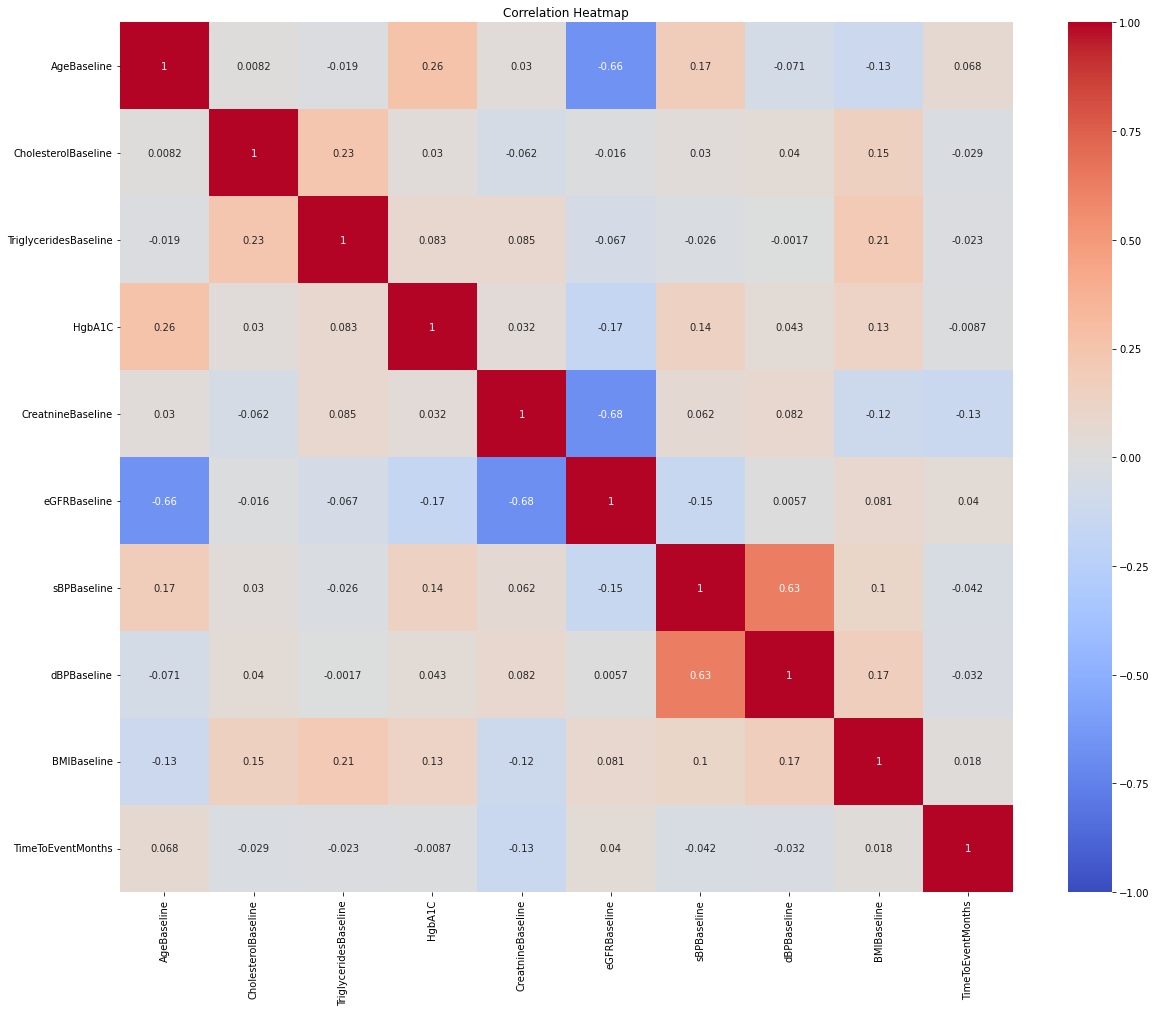

In [69]:
plot_correlation_heatmap(data_0, numeric_col, "pearson")

#### After an in-depth examination of all the binary variables, we came to the conclusion that dividing by the 'EventCKD35' and 'HistoryCHD' columns would give the most optimal correlation (both for the negative and for the positive relationships). 


## Description of Preliminary Conclusions

#### 1. Relationship between Creatinine Levels and Glomerular Filtration Rate (eGFR)
I found a moderate negative correlation between creatinine levels and glomerular filtration rate (eGFR). This means that as creatinine levels increase, eGFR decreases. This finding supports clinical literature reporting a decrease in eGFR as an important measure in the evaluation of chronic kidney disease (CKD). To deepen the understanding of this relationship, we divided the data according to the 'HistoryCHD' column. It can be seen that the rows belonging to the class where the value 'HistoryCHD' = 1 deepens the conclusion regarding the negative relationship between the columns 'CreatnineBaseline' & 'eGFRBaseline' (-0.81). For example, the [first article](https://www.kidney.org/sites/default/files/CKDEndpoints_Reference09.pdf) highlights the importance of monitoring changes in eGFR as a predictor of kidney disease progression.

#### 2. Relationship between Diastolic Blood Pressure (dBP) and Systolic Blood Pressure (sBP)
I found a moderate positive correlation between diastolic blood pressure (dBP) and systolic blood pressure (sBP). This means that as the diastolic blood pressure increases, the systolic blood pressure also increases. This finding is supported by the [second article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11153873/), which highlights the significance of both diastolic and systolic blood pressure in predicting the progression of kidney disease and other kidney outcomes. In addition, the article describes the complex relationship between blood pressure and the risk of various renal outcomes, especially regarding changes in blood pressure over time.

#### 3. Relationship between Glomerular Filtration Rate (eGFR) and Age
I found a moderate negative correlation between eGFR and age. This means that as age increases, eGFR decreases. This finding is consistent with many studies reporting a decline in kidney function with increasing age. For example, the [third article](https://www.ahajournals.org/doi/full/10.1161/HYPERTENSIONAHA.117.09855) highlights the increased risk of chronic kidney disease in older adults and suggests that a decline in eGFR is associated with older age.

#### Summary
The results of our study highlight the importance of measuring variables such as creatinine, blood pressure, and eGFR in predicting and understanding chronic kidney disease. To deepen the understanding of the relationships and following the interim conclusions, we divided the data according to the 'HistoryCHD' column. Additionally, we tried to divide the data according to the target variable ('EventCKD35') to find deeper correlations in the data, but this division did not yield any further conclusions. These findings are supported by clinical literature and reinforce the need for regular monitoring of these variables in a clinical setting.



# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Feature Selection**

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

#### We chose at this stage to split the data into a training set and a test set to avoid overfitting and data leakage.

In [70]:
X = data.drop(columns=['EventCKD35'])
y = data['EventCKD35']
binary_columns = ['HistoryDiabetes', 'HistoryCHD', 'HistoryVascular', 'HistorySmoking', 'HistoryHTN ','HistoryDLD', 'HistoryObesity', 'DLDmeds', 'DMmeds', 'HTNmeds', 'ACEIARB', 'Gender']
numerical_columns = ['AgeBaseline', 'CholesterolBaseline', 'TriglyceridesBaseline', 'HgbA1C', 'CreatnineBaseline','eGFRBaseline', 'sBPBaseline', 'dBPBaseline', 'BMIBaseline', 'TimeToEventMonths']
categorical_columns = ['Age.3.categories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Variable Selection Techniques**

##### **1. Statistical Filtering Approach**

- **Chi-Square Test for Categorical Features**:
  - **Strengths**:
    - **Simplicity**: Easy to implement and interpret.
    - **Efficiency**: Quickly identifies the strength of association between categorical features and the target variable.
  - **Limitations**:
    - **Independence Assumption**: Assumes that features are independent, which may not always hold true in practice.

- **ANOVA F-test for Numerical Features**:
  - **Strengths**:
    - **Interpretability**: Measures how well numerical features correlate with the target variable in a straightforward manner.
    - **Linear Relationships**: Effective for identifying linear relationships between features and the target.
  - **Limitations**:
    - **Linearity Assumption**: Assumes a linear relationship, which might not capture complex or non-linear associations.

##### **2. Wrapper Method**

- **Recursive Feature Elimination (RFE)**:
  - **Strengths**:
    - **Interaction Consideration**: Takes into account interactions between features, which can be beneficial for model performance.
    - **Versatility**: Can be used with various algorithms to select features based on model performance.
  - **Limitations**:
    - **Computational Intensity**: Can be computationally expensive, especially with a large number of features.
    - **Risk of Overfitting**: May overfit if the dataset is small, as it relies heavily on model performance metrics.


Applying Chi-Square Test on binary columns:
Chi-Square Selected Features:
Index(['HistoryDiabetes', 'HistoryCHD', 'HistorySmoking', 'HistoryHTN ',
       'HistoryDLD', 'DLDmeds', 'DMmeds', 'HTNmeds', 'ACEIARB', 'Gender'],
      dtype='object')


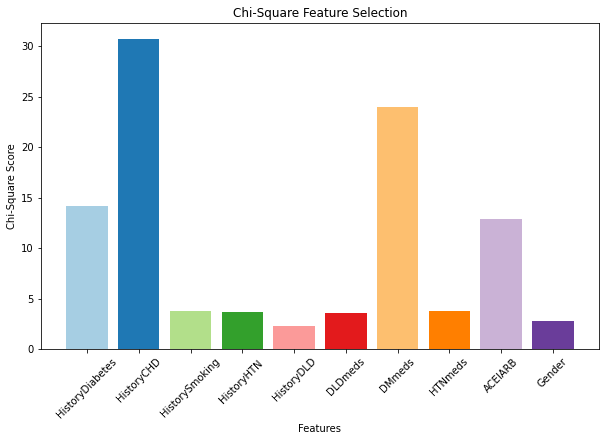

In [71]:
print("Applying Chi-Square Test on binary columns:")
selected_features_chi2 = chi_square_feature_selection(X_train[binary_columns], y_train)

Applying ANOVA F-test on numerical columns:
ANOVA F-test Selected Features:
Index(['AgeBaseline', 'CholesterolBaseline', 'TriglyceridesBaseline', 'HgbA1C',
       'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline', 'dBPBaseline',
       'BMIBaseline', 'TimeToEventMonths'],
      dtype='object')


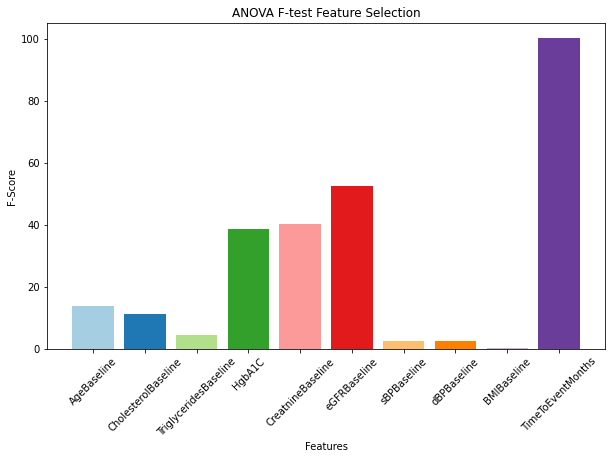

In [72]:
print("Applying ANOVA F-test on numerical columns:")
selected_features_anova = anova_f_test_feature_selection(X_train[numerical_columns], y_train)

Applying RFE on selected columns:
Top features selected by RFE:
['DMmeds', 'eGFRBaseline', 'HistorySmoking', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 'TimeToEventMonths', 'HistoryCHD', 'HgbA1C', 'Age.3.categories']




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



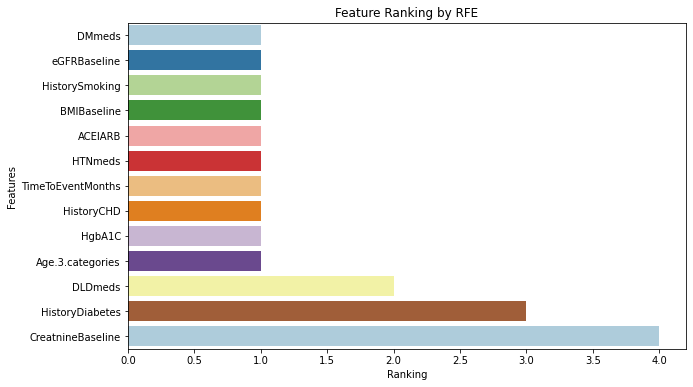

In [73]:
X_train_RFE = X_train[['DMmeds', 'eGFRBaseline', 'HistorySmoking', 
                      'CreatnineBaseline', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 
                      'TimeToEventMonths', 'HistoryCHD', 
                      'HistoryDiabetes', 'HgbA1C','Age.3.categories', 'DLDmeds']]
print("Applying RFE on selected columns:")
selected_features_rfe = rfe_feature_selection(X_train_RFE, y_train)

In [74]:
selected_features = ['DMmeds', 'eGFRBaseline', 'HistorySmoking', 'CholesterolBaseline', 
                      'CreatnineBaseline', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 
                      'TimeToEventMonths', 'HistoryCHD', 'Age.3.categories', 
                      'HistoryDiabetes', 'HgbA1C', 'DLDmeds']

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


# **Class Imbalance**

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


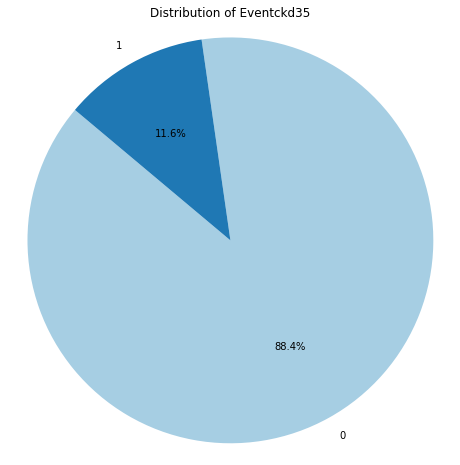

In [75]:
plot_pie_chart( data, 'EventCKD35')

#### **There is an imbalanced distribution in the target variable.**

#### Applying class balancing techniques to the `X_train_selected` dataset is crucial for addressing class imbalance and improving model training. By balancing the training data (`X_train_selected` and `y_train`), we ensure that the model learns from a dataset with equal representation of each class, which helps reduce bias and enhances the model's ability to generalize to the minority class. It is important to keep the test data (`X_test` and `y_test`) unchanged to maintain an unbiased evaluation of the model's performance on real-world data.


### SMOTE (Synthetic Minority Over-sampling Technique)

**Explanation:**
SMOTE generates synthetic samples for the minority class by interpolating between existing minority class samples.

**Advantages:**
- Increases diversity by creating new, synthetic examples.
- Can improve classifier performance by balancing the dataset.

**Disadvantages:**
- Risk of overfitting due to similarity of synthetic samples.
- Computationally intensive.
- May introduce data complexity that isn’t representative.

**Suitable For:**
- Imbalanced datasets with continuous features where interpolation is meaningful.

Original class distribution:
0    347
1     38
Name: EventCKD35, dtype: int64

Resampled class distribution:
0    347
1    347
Name: EventCKD35, dtype: int64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



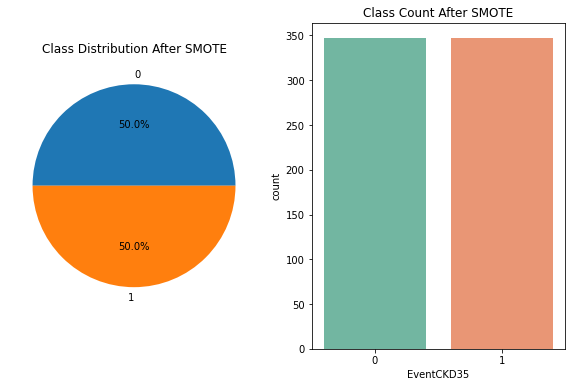

In [76]:
X_train_smote, y_train_smote = apply_smote(X_train_selected, y_train)

### Random Over-Sampling

**Explanation:**
Random Over-Sampling duplicates existing examples from the minority class to balance class distribution.

**Advantages:**
- Simple and easy to implement.
- Effective in improving performance for moderate class imbalance.

**Disadvantages:**
- Risk of overfitting due to duplication of examples.
- Does not increase data diversity.

**Suitable For:**
- Moderate imbalance in small to medium datasets.

Original class distribution:
   Class  Count
0      0    347
1      1     38

Resampled class distribution:
   Class  Count
0      0    347
1      1    347




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



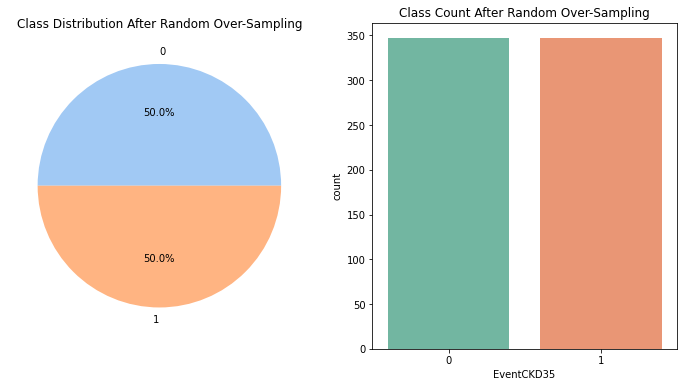

In [77]:
X_train_ros, y_train_ros, original_ros, resampled_ros = apply_random_over_sampling(X_train_selected, y_train)

**Why Use SMOTE?**

SMOTE (Synthetic Minority Over-sampling Technique) is recommended for balancing datasets when you aim to enhance model performance by generating synthetic samples. Unlike simple over-sampling, which duplicates existing samples, SMOTE creates new, synthetic instances by interpolating between existing minority class samples. This approach helps in capturing more nuanced patterns and relationships within the data, especially useful for complex datasets where the creation of additional synthetic data points can significantly improve the learning process of the model. Therefore, using SMOTE (`X_train_smote` and `y_train_smote`) can lead to better model performance and a more robust classifier.

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Model Traning And Evaluation  

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


#### function in use for the next steps:

In [78]:
def evaluate_models_with_cv(X_train_smote, y_train_smote, X_test, y_test, selected_features):
    models = {
        'Logistic Regression': (LogisticRegression(random_state=42), {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2']
        }),
        'Decision Tree': (DecisionTreeClassifier(random_state=42), {
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }),
        'SVM': (SVC(random_state=42, probability=True), {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf']
        }),
        'XGBoost': (xgb.XGBClassifier(random_state=42), {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        })
    }
    results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])
    for name, (model, param_grid) in models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_smote[selected_features], y_train_smote)
        best_model = grid_search.best_estimator_
        y_train_pred = cross_val_predict(best_model, X_train_smote[selected_features], y_train_smote, cv=5, method='predict')
        y_train_proba = cross_val_predict(best_model, X_train_smote[selected_features], y_train_smote, cv=5, method='predict_proba')[:, 1]
        y_test_pred = best_model.predict(X_test[selected_features])
        y_test_proba = best_model.predict_proba(X_test[selected_features])[:, 1]
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, y_test_proba)
        model_results = pd.DataFrame([{
            'Model': name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'ROC-AUC': roc_auc
        }])
        results = pd.concat([results, model_results], ignore_index=True)
    
    return results

def perform_grid_search(X_train_smote, y_train_smote, selected_features):
    models = {
        'Logistic Regression': (LogisticRegression(random_state=42), {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2']
        }),
        'Decision Tree': (DecisionTreeClassifier(random_state=42), {
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }),
        'SVM': (SVC(random_state=42, probability=True), {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf']
        }),
        'XGBoost': (xgb.XGBClassifier(random_state=42), {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.05,1]
        })
    }
    
    best_models = {}
    for name, (model, param_grid) in models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_smote[selected_features], y_train_smote)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    return best_models

def compare_model_performance(models_dict, X_test_data, y_test_data):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for model_name, model in models_dict.items():
        y_probs = model.predict_proba(X_test_data)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_data, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    for model_name, model in models_dict.items():
        y_probs = model.predict_proba(X_test_data)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test_data, y_probs)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

In [79]:
results_df = evaluate_models_with_cv(X_train_smote, y_train_smote, X_test, y_test, selected_features)
results_df

Model  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression   0.714286  0.833333  0.769231  0.942335
1        Decision Tree   0.523810  0.611111  0.564103  0.741210
2                  SVM   0.916667  0.611111  0.733333  0.943741
3              XGBoost   0.916667  0.611111  0.733333  0.938115

### Grid Search for Hyperparameter Tuning
Grid search is a technique for hyperparameter tuning that involves an exhaustive search through a manually specified subset of the hyperparameter space. It systematically works through multiple combinations of parameter values, cross-validating as it goes to determine which set of parameters yields the best performance. The advantages of grid search include its simplicity and thoroughness, as it explores all possible combinations within the provided grid. However, this method can be computationally expensive and time-consuming, especially with large datasets or numerous hyperparameters. Despite these drawbacks, grid search is a robust method to find optimal hyperparameters and enhance model performance when computational resources allow.


In [80]:
best_models = perform_grid_search(X_train_smote, y_train_smote, selected_features)

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


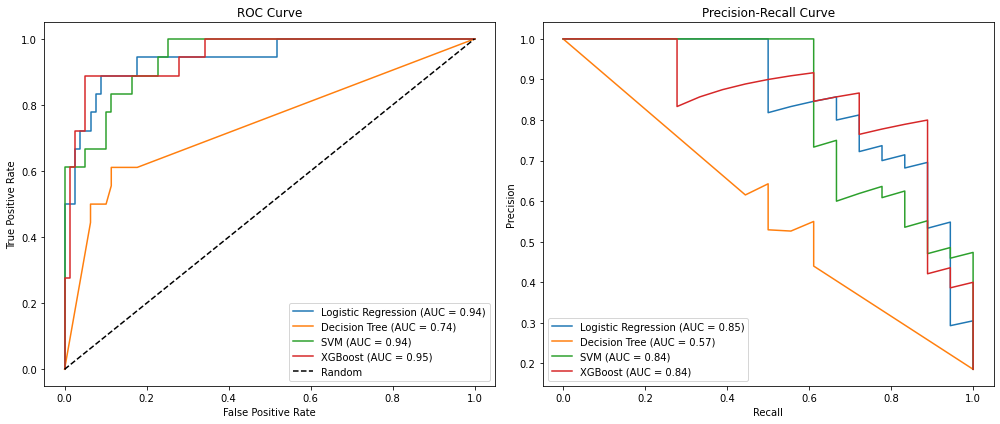

In [81]:
compare_model_performance(best_models, X_test[selected_features], y_test)

### Performance Measures
- **Precision**: Vital in cases where false positives come at an expensive cost.
- **Recall**: Important when the expense of false negatives is significant.
- **F1-Score**: The harmonic mean of precision and recall, useful when dealing with unbalanced classes.
- **ROC-AUC**: Indicates the model's ability to distinguish between classes.
- **Precision-Recall AUC**: More informative when dealing with unbalanced datasets.

### Considerations for Choosing a Model
In medical prediction, the cost of treatment for a wrong diagnosis and the implications of missing a positive case classified as negative are significant. Late detection or failure to detect kidney disease can lead to irreversible damage to the patient. Therefore, based on the above considerations and the plotted curves, we prioritize the recall metric and **choose logistic regression**. This model not only demonstrates optimal performance in terms of recall but also achieves a favorable optimal F1 score, balancing the consideration of false positive alerts.

We looked at the following article ["Machine Learning Techniques for Chronic Kidney Disease
Risk Prediction"](file:///C:/Users/amitf/AppData/Local/Microsoft/Windows/INetCache/IE/83LUYS2L/BDCC-06-00098-v2[1].pdf) which deals with chronic kidney diseases, and according to this article, we chose the evaluation indices.


# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


# Explanatory AI

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


**SHAP** is a unified approach to interpreting machine learning models. It provides a method to explain the output of any machine learning model by assigning each feature an importance value for a particular prediction.

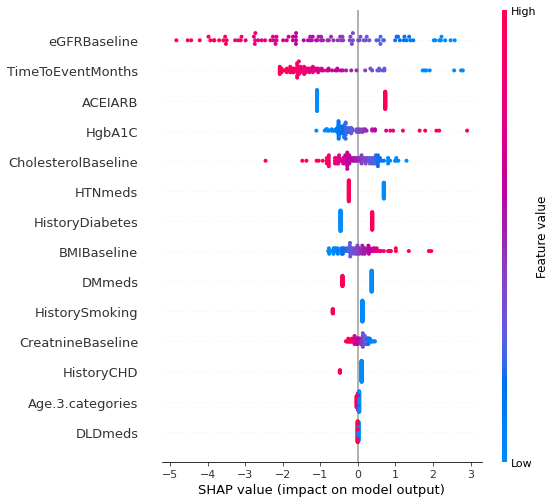

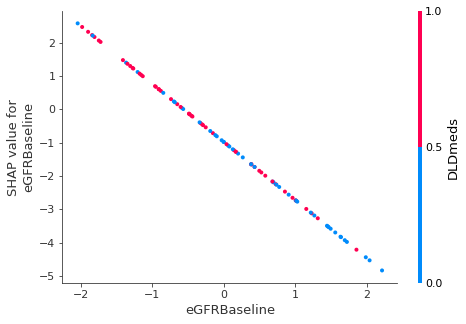

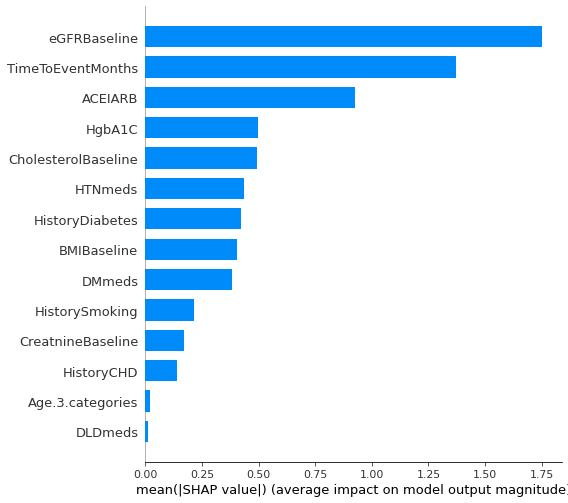

In [82]:
selected_features = ['DMmeds', 'eGFRBaseline', 'HistorySmoking', 'CholesterolBaseline', 
                      'CreatnineBaseline', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 
                      'TimeToEventMonths', 'HistoryCHD', 'Age.3.categories', 
                      'HistoryDiabetes', 'HgbA1C', 'DLDmeds']
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_smote[selected_features], y_train_smote)
explainer = shap.Explainer(log_reg, X_train_smote[selected_features])
shap_values = explainer(X_test[selected_features])
shap.summary_plot(shap_values, X_test[selected_features])
shap.dependence_plot("eGFRBaseline", shap_values.values, X_test[selected_features])
shap.summary_plot(shap_values, X_test[selected_features], plot_type="bar")


### Explanation

- **Summary Plot**: Provides a global view of feature importance and the direction of impact.
- **Dependence Plot**: Shows the relationship between a specific feature and the model output.
- **Bar Plot**: Ranks features based on their importance.



### Interpretation of Top 5 Variables from SHAP Summary Plot

#### 1. `eGFRBaseline`
- **Graph Interpretation**: `eGFRBaseline` is primarily leaning towards the negative side of the SHAP summary plot, with a mix of samples on the positive side. On the positive side, most samples are blue, indicating lower SHAP values, while on the negative side, samples are red, indicating higher SHAP values.
- **Clinical Relevance**: The negative leaning of `eGFRBaseline` suggests that lower `eGFRBaseline` values are associated with higher predictions of the positive outcome, i.e., a higher risk of the disease. This is clinically relevant as `eGFR` (Estimated Glomerular Filtration Rate) is a key indicator of kidney function, and lower values typically signal poorer kidney function and higher risk of chronic kidney disease. The presence of many samples on both sides indicates variability in its effect, with the trend towards negative impacts reinforcing its importance in predicting the risk.

#### 2. `TimeToEventMonths`
- **Graph Interpretation**: `TimeToEventMonths` is predominantly on the negative side with red-tinted samples. This suggests that higher values of `TimeToEventMonths` are associated with a decrease in the model's prediction of the positive outcome.
- **Clinical Relevance**: The negative contribution of `TimeToEventMonths` implies that a longer time to the event decreases the probability of the event occurring or the severity of the condition. Clinically, this could mean that if the time to the critical health event is longer, it might be associated with a reduced likelihood of immediate risk or progression of the disease. This could influence monitoring strategies and the urgency of interventions.

#### 3. `ACEIARB`
- **Graph Interpretation**: `ACEIARB` appears as a vertical line evenly distributed across both sides of the plot. This distribution suggests that `ACEIARB` does not significantly influence the SHAP values in a consistent direction.
- **Clinical Relevance**: Since `ACEIARB` (Angiotensin-Converting Enzyme Inhibitors and Angiotensin Receptor Blockers) shows no clear bias in the SHAP values, it may not be a strong predictor in this model or its effect is not consistent across samples. It’s important to further investigate whether this lack of influence is due to its minimal effect or variability in its impact.

#### 4. `HgbA1C`
- **Graph Interpretation**: `HgbA1C` shows a mixed distribution with both positive and negative side tendencies. Positive samples are red-tinted and spread horizontally, while negative side samples are blue and more concentrated.
- **Clinical Relevance**: The dual influence of `HgbA1C` suggests that its effect on the model’s prediction varies. Higher `HgbA1C` levels, indicative of poorer long-term glucose control, are associated with increased risk of chronic kidney disease, but the effect is not uniform. The concentration of blue-tinted samples on the negative side indicates a potential threshold or level of `HgbA1C` where its influence on risk prediction becomes more pronounced. This variability highlights the need to consider `HgbA1C` levels carefully in patient management and risk assessment.

#### 5. `CholesterolBaseline`
- **Graph Interpretation**: `CholesterolBaseline` shows a balanced distribution across the positive and negative sides, with blue samples on the positive side and red samples on the negative side.
- **Clinical Relevance**: The balanced impact of `CholesterolBaseline` suggests that cholesterol levels have a varying effect on the model's predictions. Both high and low levels are associated with different risks, potentially reflecting complex interactions with other variables. In clinical practice, this implies that cholesterol levels should be monitored and managed in conjunction with other risk factors to provide a comprehensive risk assessment for chronic kidney disease.

### Notes
- **ACEIARB**: Since `ACEIARB` shows uniform distribution and lacks clear influence, it may not be significant for this model's predictions or its effect is inconsistent.



# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


# Sub Group Analysis

# **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


#### To examine the distribution of homogeneous groups in the data, we will first use the elbow method to test the optimal K for distribution in the Kmeans algorithm

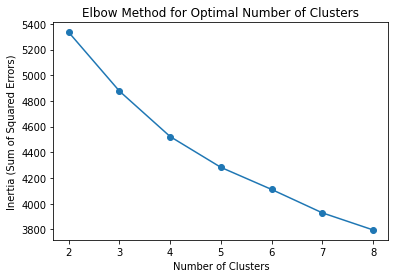

Clusters          SSE  Silhouette  \
0        2  5334.301951    0.143893   
1        3  4876.668964    0.124294   
2        4  4522.902889    0.123965   
3        5  4283.230161    0.124441   
4        6  4111.339028    0.116463   
5        7  3929.192979    0.109281   
6        8  3796.353287    0.111844   

                                        Sample Count Min Count Max Count  
0                     1    258
0    224
dtype: int64       224       258  
1            2    185
0    173
1    124
dtype: int64       124       185  
2   0    158
2    143
1    118
3     63
dtype: int64        63       158  
3  2    142
0    125
3    105
1     60
4     50
d...        50       142  
4  4    121
2    121
0     83
1     62
5     52
3...        43       121  
5  0    96
1    91
3    89
2    78
5    56
6    4...        31        96  
6  3    91
0    84
6    81
4    77
2    55
5    3...        25        91

In [83]:
cluster_and_evaluate(data)

##### it is not possible to unequivocally decide from the graph on an optimal division into clusters, therefore we will use scaled inertia.

##### Mathematical and theoretical explanation:
##### <blockquote>https://towardsdatascience.com/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c</blockquote>

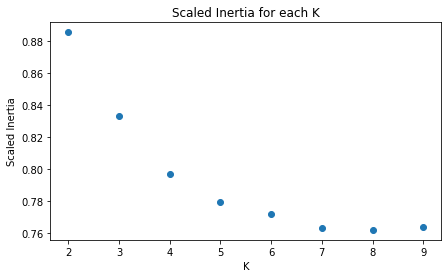

Clusters          SSE  Scaled Inertia  Silhouette  \
0        2  5334.301951        0.885777    0.143893   
1        3  4876.668964        0.833217    0.124294   
2        4  4522.902889        0.797126    0.123965   
3        5  4283.230161        0.779125    0.124441   
4        6  4111.339028        0.771870    0.116463   
5        7  3929.192979        0.762990    0.109281   
6        8  3796.353287        0.761928    0.111844   
7        9  3680.740949        0.763597    0.101638   

                                        Sample Count Min Count Max Count  
0                     1    258
0    224
dtype: int64       224       258  
1            2    185
0    173
1    124
dtype: int64       124       185  
2   0    158
2    143
1    118
3     63
dtype: int64        63       158  
3  2    142
0    125
3    105
1     60
4     50
d...        50       142  
4  4    121
2    121
0     83
1     62
5     52
3...        43       121  
5  0    96
1    91
3    89
2    78
5    56
6    4...        31        96  
6  3    91
0    84
6    81
4    77
2    55
5    3...        25        91  
7  5    84
1    69
0    66
2    58
4    58
8    4...        26        84

In [84]:
cluster_and_evaluate1(data)

#### <blockquote>After using Scaled Inertia and a graphical presentation, it can be seen that the optimum is reached when K=8 with low silhouettes (low separation between the clusters). We'll try to check downsizing and see if we get better results by dividing into clusters afterwards</blockquote>

### We will try to use PCA to make the conclusion more accurate

In [85]:
pipeline = Pipeline(steps=[('pca', PCA(n_components=0.9))])
X_transformed = pipeline.fit_transform(data)
pca_model = pipeline.named_steps['pca']
explained_variance_ratio = pca_model.explained_variance_ratio_
var = 0
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained Variance Ratio for Dimension {i+1}: {ratio:.4f}")
    var += ratio

print("Total Variance Explained: {:.2f}".format(var))

Explained Variance Ratio for Dimension 1: 0.2278
Explained Variance Ratio for Dimension 2: 0.1418
Explained Variance Ratio for Dimension 3: 0.1076
Explained Variance Ratio for Dimension 4: 0.1047
Explained Variance Ratio for Dimension 5: 0.0823
Explained Variance Ratio for Dimension 6: 0.0674
Explained Variance Ratio for Dimension 7: 0.0612
Explained Variance Ratio for Dimension 8: 0.0498
Explained Variance Ratio for Dimension 9: 0.0325
Explained Variance Ratio for Dimension 10: 0.0254
Total Variance Explained: 0.90


#### Examining the silhouettes before applying PCA

Silhouette score for 2 clusters: 0.14389310703318645
Silhouette score for 3 clusters: 0.12429359656276069
Silhouette score for 4 clusters: 0.123964612156135
Silhouette score for 5 clusters: 0.12444120446468837
Silhouette score for 6 clusters: 0.11646317455627309
Silhouette score for 7 clusters: 0.10928071169922801
Silhouette score for 8 clusters: 0.11184377466635721
Silhouette score for 9 clusters: 0.1016383104871477


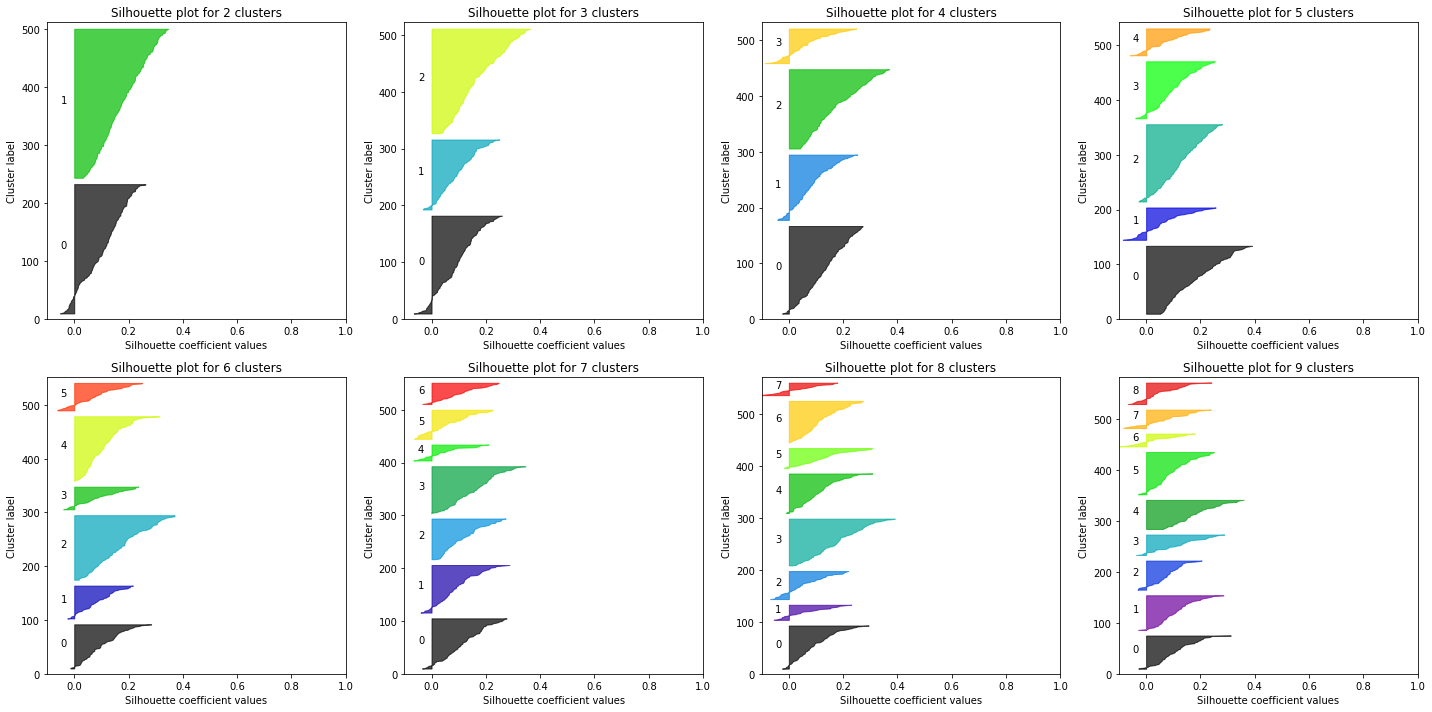

In [86]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  
axs = axs.flatten() 
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for i, n_clusters in enumerate(range_n_clusters):
    silhouette_avg = plot_silhouette(data, n_clusters, axs[i])
    print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg}")
plt.tight_layout()
plt.show()

#### Examining the silhouettes after applying PCA

Silhouette score for 2 clusters: 0.1597674284419177
Silhouette score for 3 clusters: 0.13956197206299817
Silhouette score for 4 clusters: 0.14151577901198514
Silhouette score for 5 clusters: 0.14308897581960897
Silhouette score for 6 clusters: 0.12814823566628902
Silhouette score for 7 clusters: 0.12899500201672542
Silhouette score for 8 clusters: 0.11671705010500272
Silhouette score for 9 clusters: 0.11673849261887105


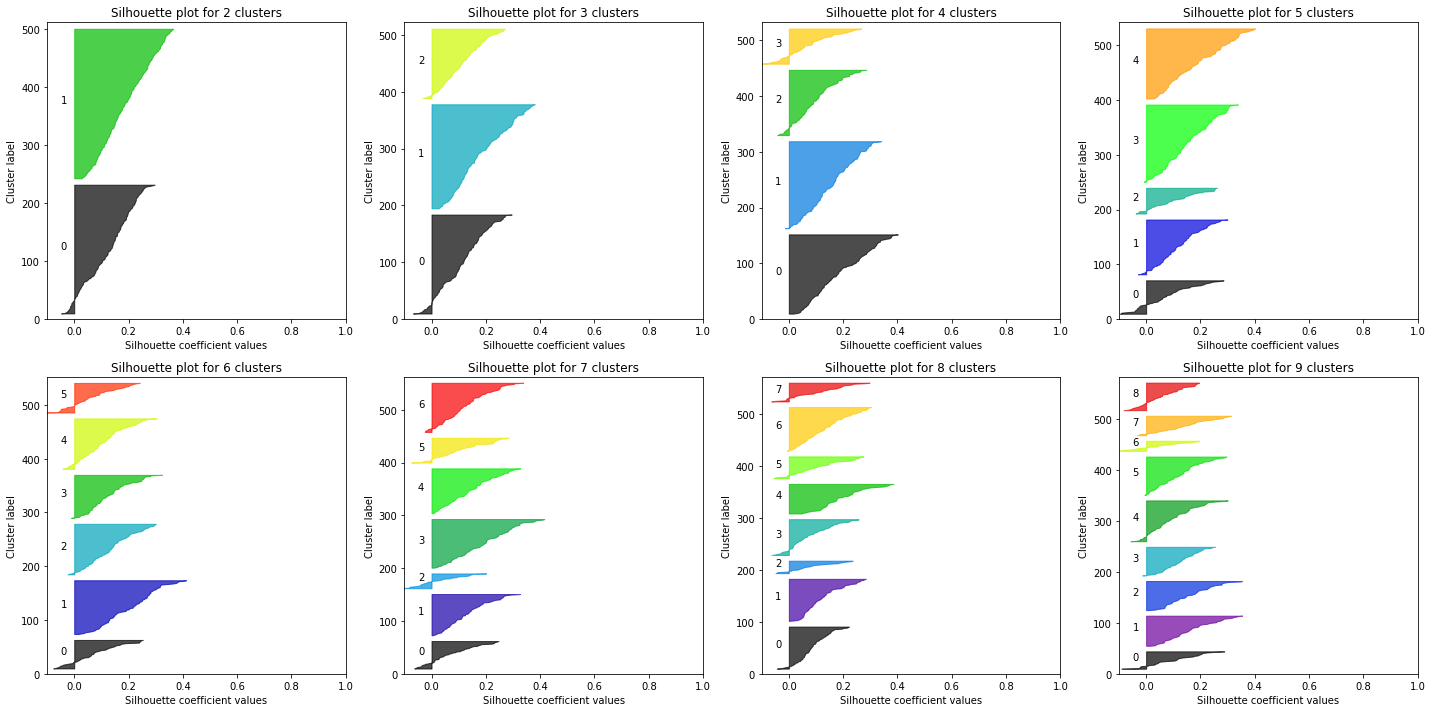

In [87]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  
axs = axs.flatten() 
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for i, n_clusters in enumerate(range_n_clusters):
    silhouette_avg = plot_silhouette(X_transformed, n_clusters, axs[i])
    print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg}")
plt.tight_layout()
plt.show()

In [88]:
kmeans_orig = KMeans(n_clusters=5, random_state=42)
labels_orig = kmeans_orig.fit_predict(data)

kmeans_pca = KMeans(n_clusters=5, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_transformed)

silhouette_orig = silhouette_score(data, labels_orig)
silhouette_pca = silhouette_score(X_transformed, labels_pca)

print("Silhouette Score for Original Data:", silhouette_orig)
print("Silhouette Score for PCA-transformed Data:", silhouette_pca)

Silhouette Score for Original Data: 0.12444120446468837
Silhouette Score for PCA-transformed Data: 0.14308897581960897


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [89]:
kmeans_orig = KMeans(n_clusters=2, random_state=42)
labels_orig = kmeans_orig.fit_predict(data)

kmeans_pca = KMeans(n_clusters=2, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_transformed)

silhouette_orig = silhouette_score(data, labels_orig)
silhouette_pca = silhouette_score(X_transformed, labels_pca)

print("Silhouette Score for Original Data:", silhouette_orig)
print("Silhouette Score for PCA-transformed Data:", silhouette_pca)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Silhouette Score for Original Data: 0.14389310703318645
Silhouette Score for PCA-transformed Data: 0.1597674284419177


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


#### It can be seen that the results after applying PCA improve and the clusters appear clearer. The divisions that stood out were K=2 and K=5. We will examine the divisions in other methods with the data after the PCA.


### Comparing Silhouette Scores with Hierarchical Clustering Using the WARD Method

The WARD method, also known as WARD's minimum variance method, is employed to guide the merging of clusters in hierarchical clustering. This technique focuses on minimizing the total within-cluster variance when combining clusters. By using the WARD method, we aim to achieve clusters with minimal internal variance, which typically results in more cohesive and well-separated clusters. Comparing silhouette scores with hierarchical clustering using the WARD method allows us to evaluate the quality of cluster definitions and ensure that the clusters formed are not only distinct but also compact.


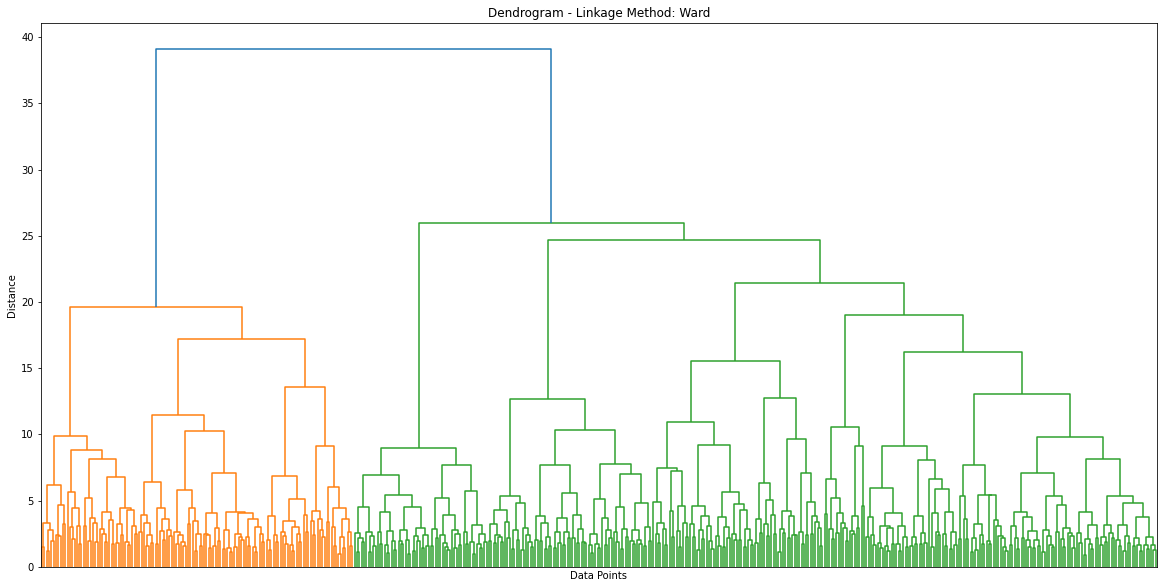

Cluster labels using Ward linkage:
[430 460 286 457 408 385 459 449 473 323 355 318 433 378 432 266 374 467
 425 474 463 290 376 243 249 423 451 409 236 396 471 400 325 294 265 455
 363 395 407 419 453 253 330 361 381 289 375 283 387 420 261 299 427 437
 439 247 431 337 443 465 350 336 372 300 368 314 187 366 399 382 410 319
 251 360 456 388 356 446 346 199 229 466 279 470 464 458 267 242 149 315
 426 258 461 386 326 162 347 481 192 411 429 448 332 307 365 450 244 435
 359 438 362 320 292 296 345 384 341 479 444 353 269 311 273 354 428 327
 282 383 301 349 404 351 324 424 302 413 468 415 338 364 405 293 295 373
 447 480 392 329 403 254 250 268 477 245 445 358 248 201 348 352 159 287
 211 291 452 240 401 397 274 377 321 145 335 213 370 132 262 390 394 393
 179 175 228 441 475 256 454 478 280 204 406 123 422 271 308 150 255 277
 371 331 414 312 389 317 402 130 436 416 224 194 297 200 278 180 379 257
 191 391 442 343 221 313 164 334 193 197 339 421 220 202 215 217  74 418
 303 288 206 238

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


In [90]:
compare_agglomerative_clustering(X_transformed)

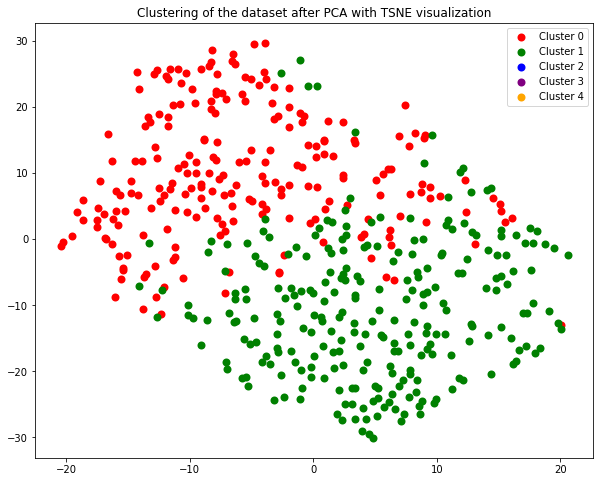

In [91]:
tsne_visualization(X_transformed, labels_pca)

#### We will examine division into 5 and 2 clusters.

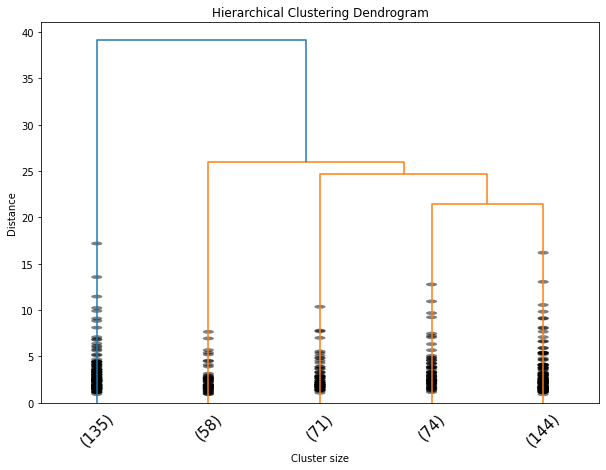

In [92]:
plot_hierarchical_dendrogram(X_transformed, method='ward', p=5)

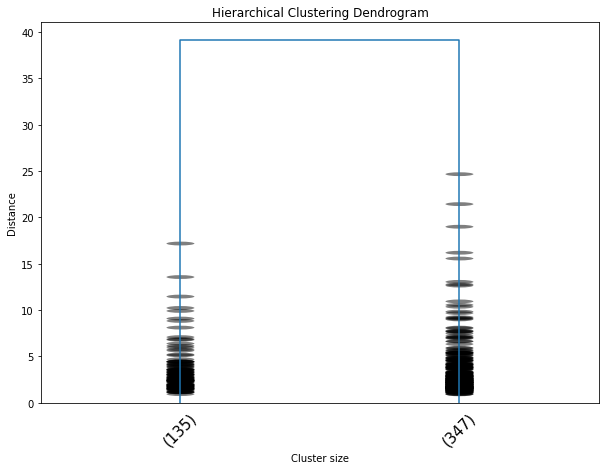

In [93]:
plot_hierarchical_dendrogram(X_transformed, method='ward', p=2)

### Selection of cluster numbers based on silhouette scores, TSNE and hierarchical clustering

It can be seen that the best silhouette scores belong to K=5 and K=2. In addition, according to the hierarchical clusters it can be seen that the most distinct division is into 2 clusters and so is according to the TSNE. **We will continue with K=2**.

In [94]:
K = 2
cluster_data_frames = kmeans_cluster_to_dfs(data, K)
for i in range(K):
    globals()[f'cluster_{i}'] = cluster_data_frames[i]

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [95]:
len(cluster_0)

224

In [96]:
len(cluster_1)

258

In [97]:
numerical_columns = ['AgeBaseline','CholesterolBaseline', 'TriglyceridesBaseline','HgbA1C', 'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline','dBPBaseline', 'BMIBaseline', 'TimeToEventMonths']

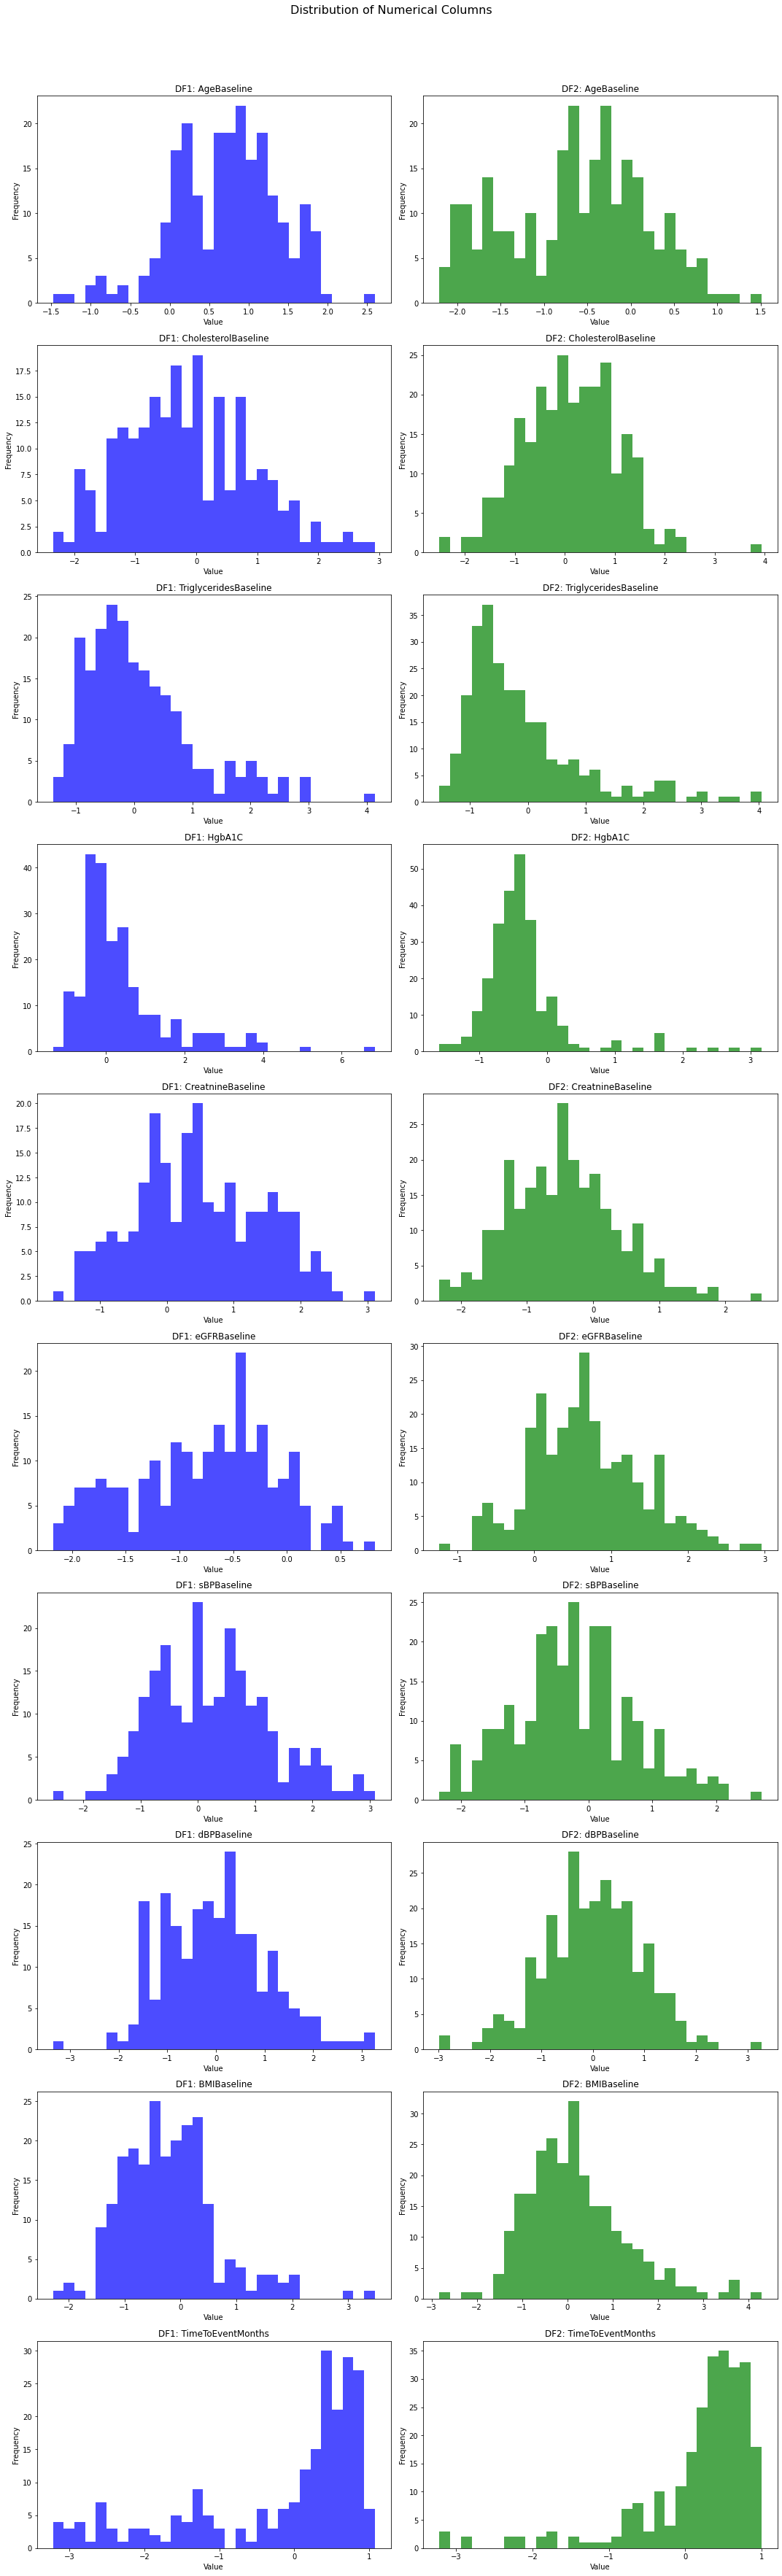

In [98]:
plot_numerical_distributions2(cluster_0, cluster_1)

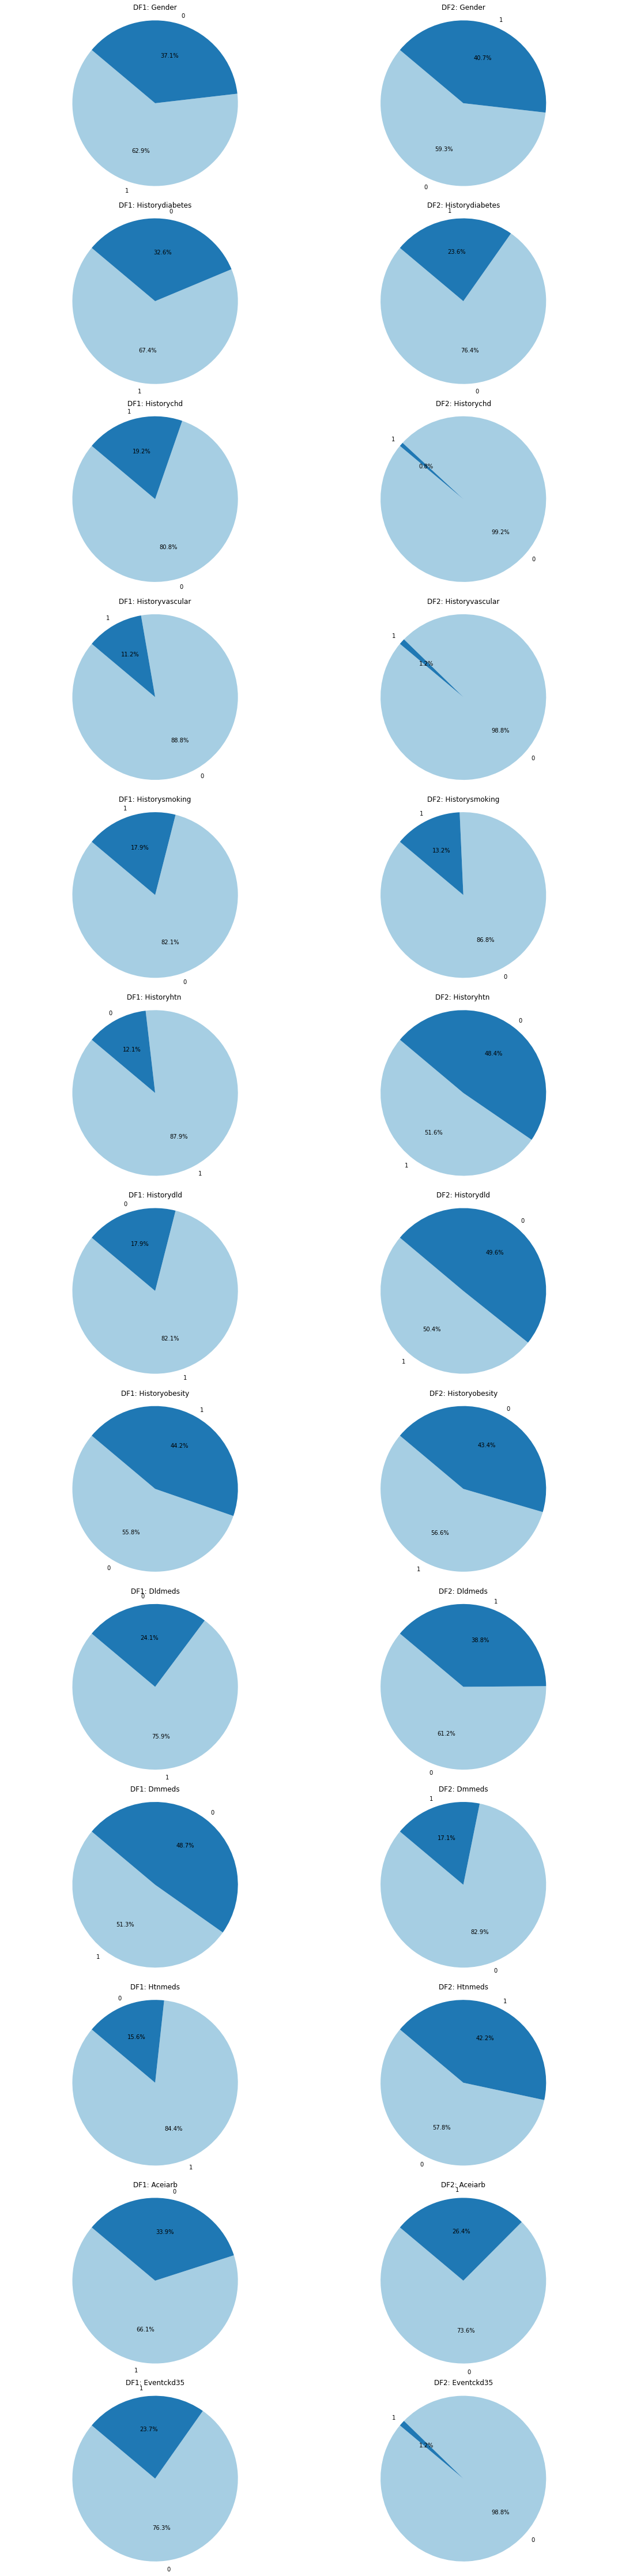

In [99]:
plot_pie_chart_comparison2(cluster_0,cluster_1)

In [100]:
cluster_0['EventCKD35'].value_counts()

0    171
1     53
Name: EventCKD35, dtype: int64

In [101]:
cluster_1['EventCKD35'].value_counts()

0    255
1      3
Name: EventCKD35, dtype: int64

### Reason for Not Testing a Predictive Model for Cluster 1

After performing clustering analysis, we observed that Cluster 1 contains only few positive samples in the 'EventCKD35' column, with the vast majority of the samples being negative. This extreme imbalance poses significant challenges for building a predictive model within this cluster. Specifically, the insufficient number of positive samples means that the model would struggle to learn meaningful patterns associated with the positive class, leading to poor generalization and predictive performance. Additionally, from a statistical standpoint, the very low number of positive cases would result in unreliable and non-representative performance metrics. Therefore, testing a predictive model for Cluster 1 would not be practical or reliable. Instead, we will focus on Cluster 0, which contains the majority of the positive samples, and consider alternative approaches such as combining the clusters or using cluster assignments as an additional feature in our predictive modeling.


In [102]:
binary_columns = ['HistoryDiabetes', 'HistoryCHD', 'HistoryVascular', 'HistorySmoking', 'HistoryHTN ','HistoryDLD', 'HistoryObesity', 'DLDmeds', 'DMmeds', 'HTNmeds', 'ACEIARB', 'Gender']
numerical_columns = ['AgeBaseline', 'CholesterolBaseline', 'TriglyceridesBaseline', 'HgbA1C', 'CreatnineBaseline','eGFRBaseline', 'sBPBaseline', 'dBPBaseline', 'BMIBaseline', 'TimeToEventMonths']
categorical_columns = ['Age.3.categories']

In [103]:
X = cluster_0.drop(columns=['EventCKD35'])
y = cluster_0['EventCKD35']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Applying Chi-Square Test on binary columns:
Chi-Square Selected Features:
Index(['HistoryDiabetes', 'HistoryCHD', 'HistoryVascular', 'HistorySmoking',
       'HistoryHTN ', 'HistoryDLD', 'HistoryObesity', 'DLDmeds', 'DMmeds',
       'ACEIARB'],
      dtype='object')


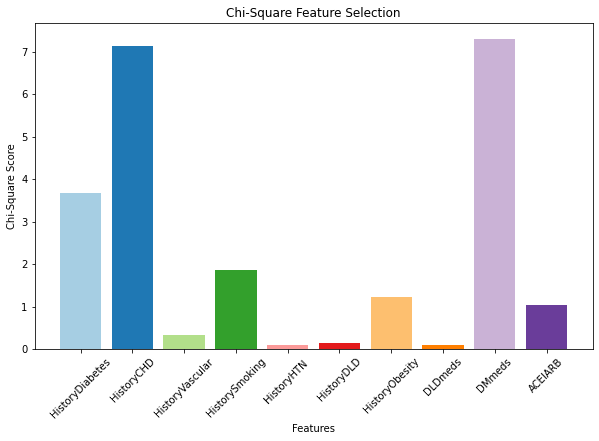

In [105]:
print("Applying Chi-Square Test on binary columns:")
selected_features_chi2 = chi_square_feature_selection(X_train[binary_columns], y_train)

Applying ANOVA F-test on numerical columns:
ANOVA F-test Selected Features:
Index(['AgeBaseline', 'CholesterolBaseline', 'TriglyceridesBaseline', 'HgbA1C',
       'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline', 'dBPBaseline',
       'BMIBaseline', 'TimeToEventMonths'],
      dtype='object')


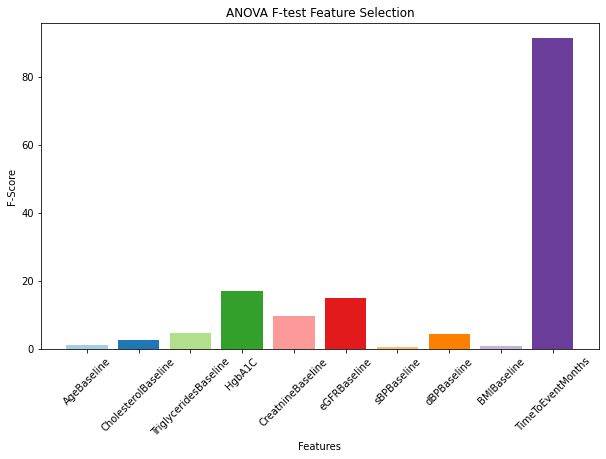

In [106]:
print("Applying ANOVA F-test on numerical columns:")
selected_features_anova = anova_f_test_feature_selection(X_train[numerical_columns], y_train)

Applying RFE on selected columns:
Top features selected by RFE:
['DMmeds', 'eGFRBaseline', 'CreatnineBaseline', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 'TimeToEventMonths', 'HistoryCHD', 'HgbA1C', 'Age.3.categories']




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



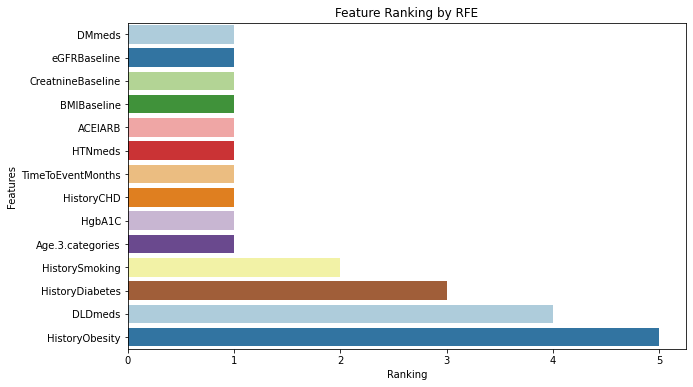

In [107]:
X_train_RFE = X_train[['DMmeds', 'eGFRBaseline', 'HistorySmoking','HistoryObesity', 
                      'CreatnineBaseline', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 
                      'TimeToEventMonths', 'HistoryCHD', 
                      'HistoryDiabetes', 'HgbA1C','Age.3.categories', 'DLDmeds']]
print("Applying RFE on selected columns:")
selected_features_rfe = rfe_feature_selection(X_train_RFE, y_train)

In [108]:
selected_features = ['eGFRBaseline', 'CholesterolBaseline', 
                      'CreatnineBaseline', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 
                      'TimeToEventMonths', 'HistoryCHD', 'Age.3.categories', 
                      'HistoryDiabetes', 'HgbA1C']

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Original class distribution:
0    134
1     45
Name: EventCKD35, dtype: int64

Resampled class distribution:
0    134
1    134
Name: EventCKD35, dtype: int64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



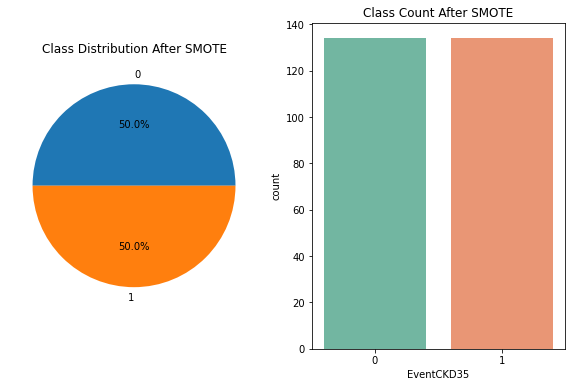

In [109]:
X_train_smote, y_train_smote = apply_smote(X_train_selected, y_train)

In [110]:
results_df = evaluate_models_with_cv(X_train_smote, y_train_smote, X_test, y_test, selected_features)
results_df

Model  Precision  Recall  F1-score   ROC-AUC
0  Logistic Regression   0.500000   0.625  0.555556  0.682432
1        Decision Tree   0.142857   0.125  0.133333  0.567568
2                  SVM   0.444444   0.500  0.470588  0.729730
3              XGBoost   0.375000   0.375  0.375000  0.729730

In [111]:
best_models = perform_grid_search(X_train_smote, y_train_smote, selected_features)


Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}
Best parameters for Decision Tree: {'max_depth': 20, 'min_samples_split': 10}
Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Best parameters for XGBoost: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}


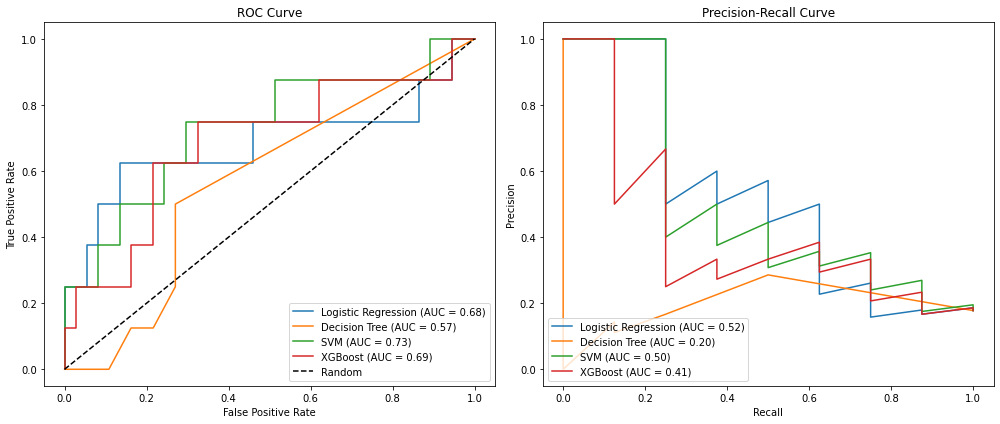

In [112]:
compare_model_performance(best_models, X_test[selected_features], y_test)

### Summary of findings

In our analysis, the K-means clustering algorithm divided the data set into two clusters, revealing clear patterns in the target variable 'EventCKD35':

- **Cluster 0**: This cluster contained a significantly higher proportion of positive cases for 'EventCKD35'. Specifically, 23.7% of rows in cluster 0 had 'EventCKD35' = 1, compared to only 11.6% in the total dataset. Cluster 0 also had a higher prevalence of historical states:
 - **HistoryVascular**: 11.2% of rows in cluster 0 had 'HistoryVascular' = 1, compared to 5.8% in the total dataset.
 - **HistoryCHD**: 19.2% of rows in cluster 0 had 'HistoryCHD' = 1, compared to 9.3% in the total dataset.

- **Cluster 1**: This cluster contained almost no positive cases for 'EventCKD35', with only 3 rows having 'EventCKD35' = 1 (1.2% of rows). Almost all rows (98.8%) in cluster 1 had 'EventCKD35' = 0. As a result, cluster 1 was excluded from the predictive modeling process, focusing solely on cluster 0.

### Performance of predictive models

Models trained on cluster 0 produced lower accuracy scores compared to models trained on the entire data set. This discrepancy can be attributed to several factors:

1. **Class Imbalance**: Despite applying SMOTE to balance the classes, the extreme imbalance in cluster 0 (even after resampling) affected the model performance. The model struggled with the remaining imbalance, leading to lower accuracy.

2. **Data segmentation**: The extreme separation of positive cases in cluster 0 and the absence of positive cases in cluster 1 may have limited the model's ability to generalize well. Models trained on such biased clusters may not perform as strongly as those trained on a more balanced data set.

3. **Cluster-specific features**: The high concentration of CKD events and risk factors associated with cluster 0 may introduce complexity that affects model performance. This can lead to a decrease in accuracy compared to models trained on the entire data set.

#### Following on from the findings we discovered in the division into 2 clusters and since the results of the division did not present optimal accuracy measures, we will also test K=5 to see if it is possible to learn more about the data and deepen the prediction from division into less homogeneous groups with higher variance.

In [114]:
K = 5
clas_lis = []
cluster_data_frames = kmeans_cluster_to_dfs(data, K)
for i in range(K):
    globals()[f'cluster_{i}'] = cluster_data_frames[i]

clas_lis = [cluster_0, cluster_1,cluster_2, cluster_3,cluster_4]

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [115]:
for i in clas_lis:
    print(len(i))

59
122
149
50
102


#### Analysis of differences between binary columns between the clusters

In [116]:
numerical_columns = ['AgeBaseline','CholesterolBaseline', 'TriglyceridesBaseline','HgbA1C', 'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline','dBPBaseline', 'BMIBaseline', 'TimeToEventMonths']

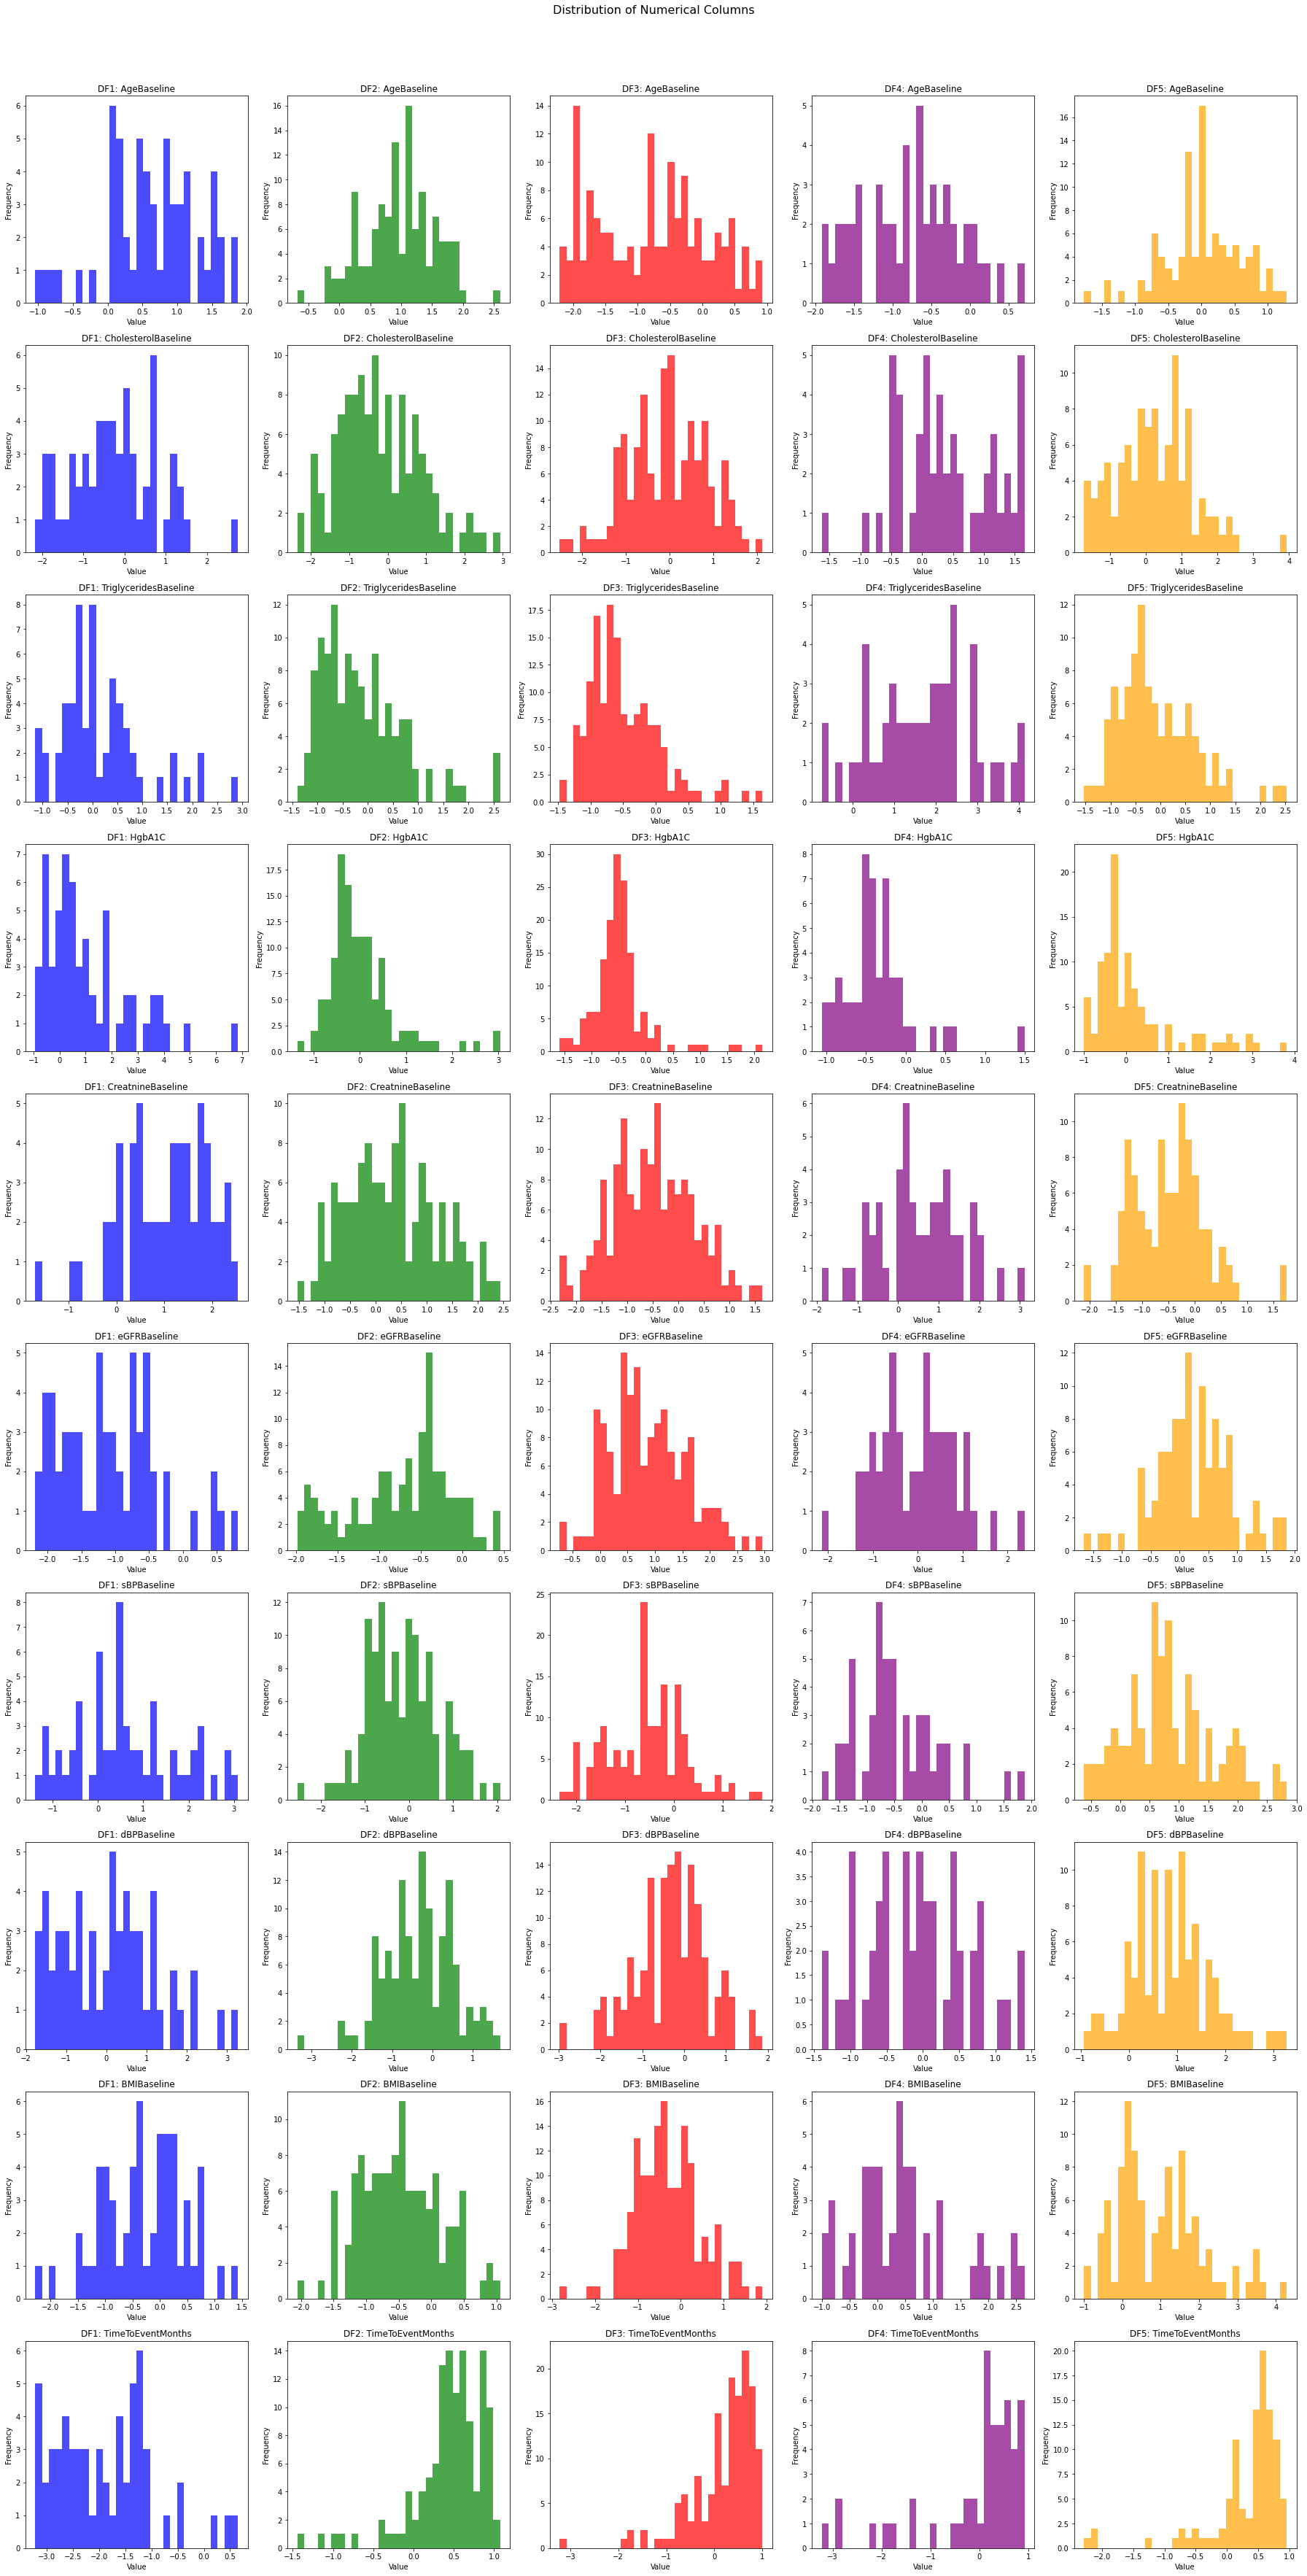

In [117]:
plot_numerical_distributions5(cluster_0, cluster_1,cluster_2, cluster_3,cluster_4)

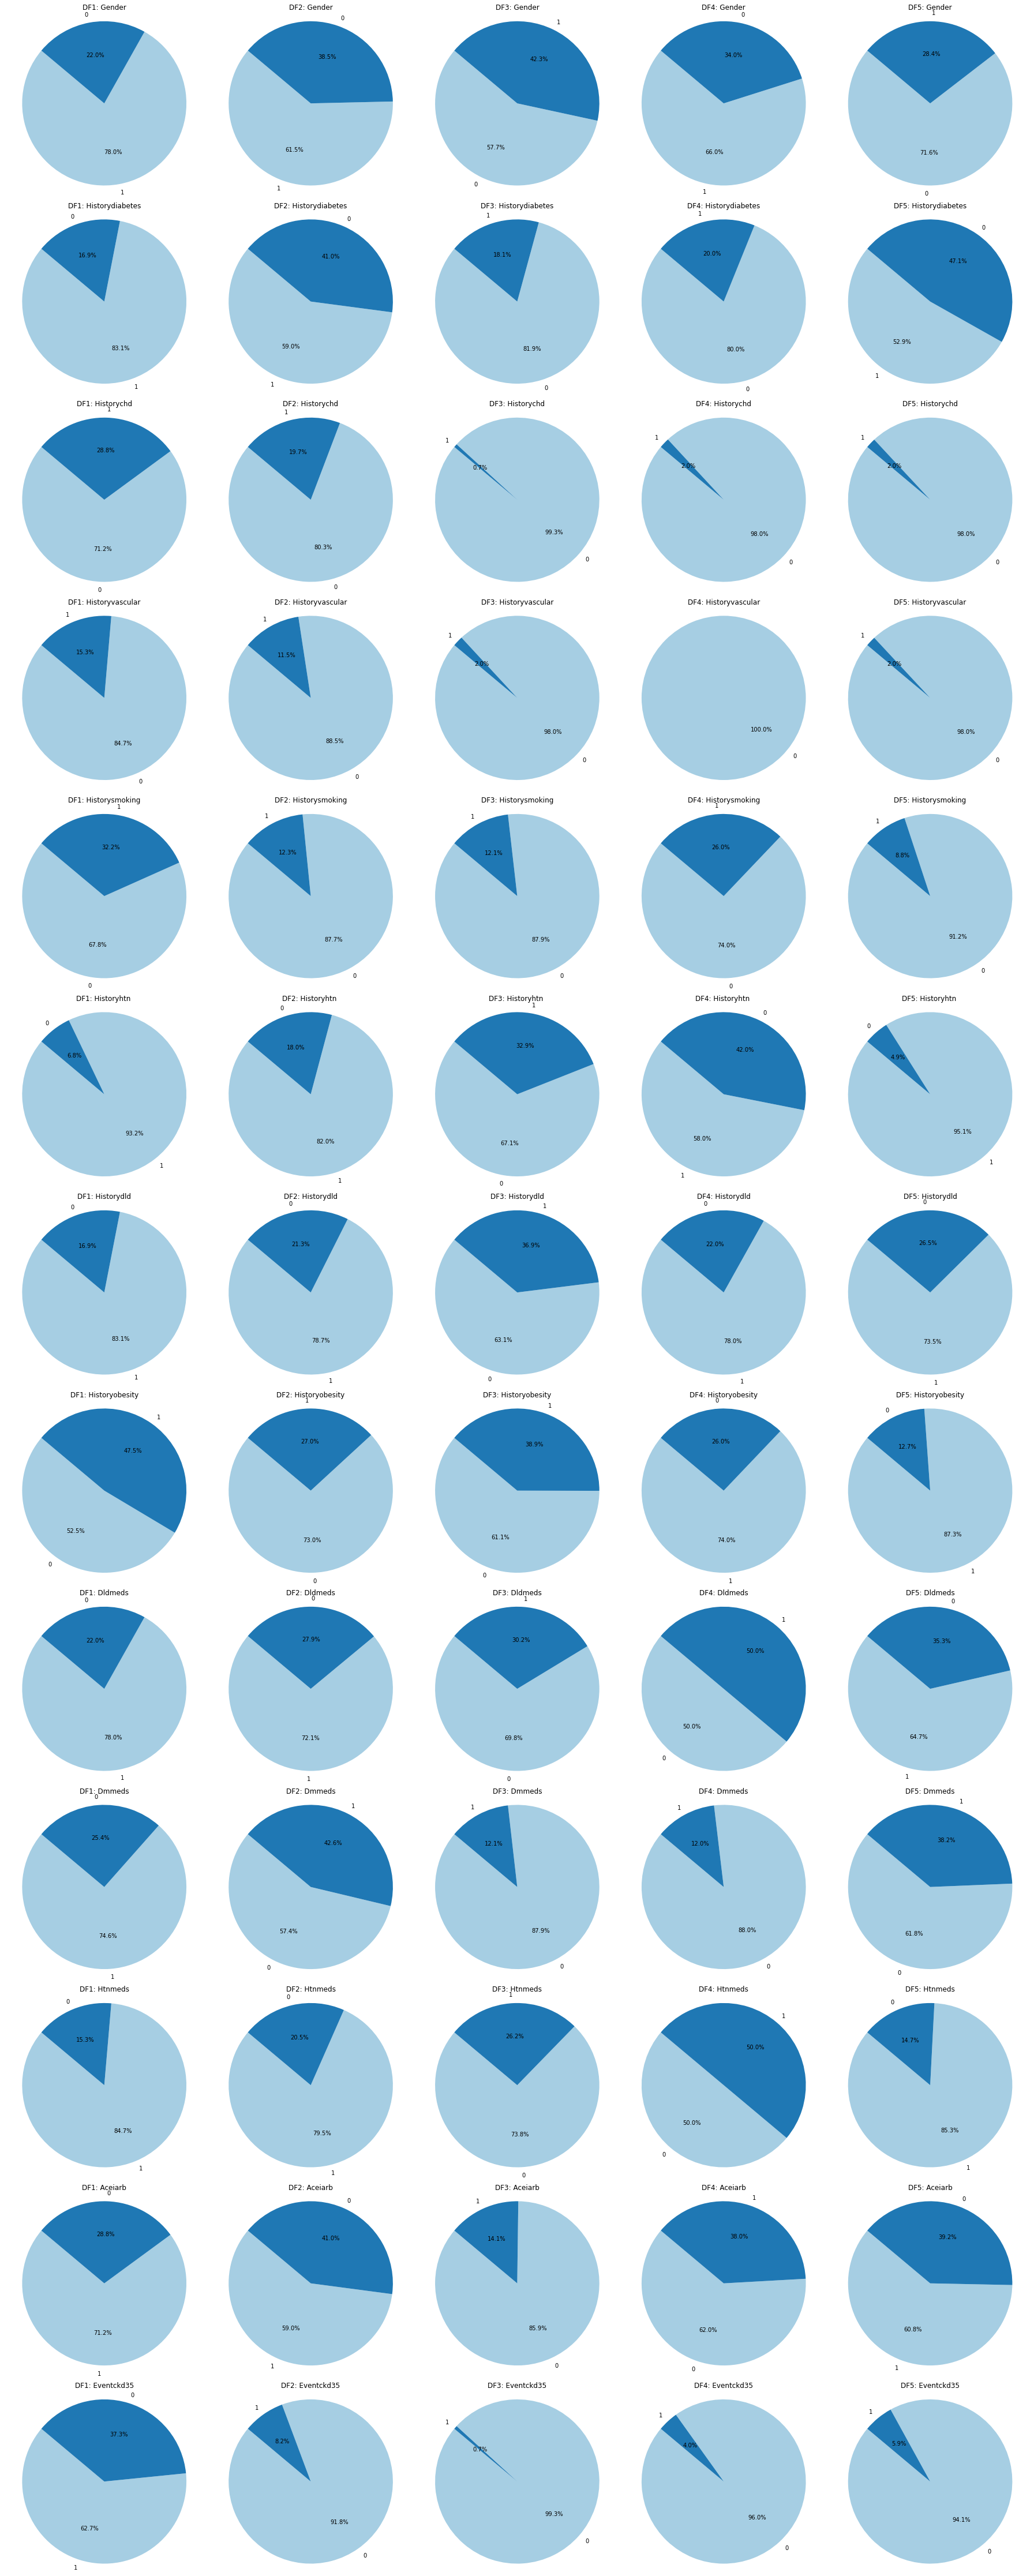

In [118]:
plot_pie_chart_comparison5(cluster_0, cluster_1,cluster_2, cluster_3,cluster_4)

#### It can be seen that most of the positive samples for 'EventCKD35' are in Cluster_0 and Cluster_1. In addition, the columns 'HistoryCHD' and 'HistoryVascular' behave in accordance with the target variable and they also have positive values almost only in the clusters Cluster_0 and Cluster_1

In [119]:
chi_square_test(cluster_0,'HistoryCHD','EventCKD35')

P-value: 0.0040205792142607374
There is a statistically significant association between the two variables.


#### After examining the relationship using a statistical test, you can see a clear relationship between the columns 'HistoryCHD' & 'EventCKD35' in cluster_0.
#### We will continue with Cluster_0 to perform a predictive model since most of the positive samples are in it.

### Analysis and prediction of CKD cluster 0 (cluster_0)

In [120]:
binary_columns = ['HistoryDiabetes', 'HistoryCHD', 'HistoryVascular', 'HistorySmoking', 'HistoryHTN ','HistoryDLD', 'HistoryObesity', 'DLDmeds', 'DMmeds', 'HTNmeds', 'ACEIARB', 'Gender']
numerical_columns = ['AgeBaseline', 'CholesterolBaseline', 'TriglyceridesBaseline', 'HgbA1C', 'CreatnineBaseline','eGFRBaseline', 'sBPBaseline', 'dBPBaseline', 'BMIBaseline', 'TimeToEventMonths']
categorical_columns = ['Age.3.categories']

In [121]:
X = cluster_0.drop(columns=['EventCKD35'])
y = cluster_0['EventCKD35']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Applying Chi-Square Test on binary columns:
Chi-Square Selected Features:
Index(['HistoryDiabetes', 'HistoryCHD', 'HistoryVascular', 'HistorySmoking',
       'HistoryDLD', 'HistoryObesity', 'DMmeds', 'HTNmeds', 'ACEIARB',
       'Gender'],
      dtype='object')


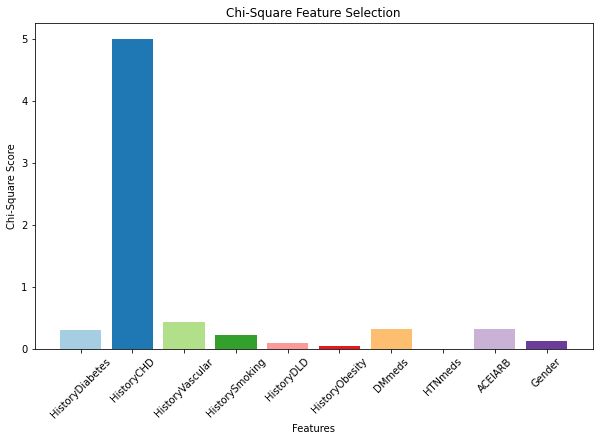

In [123]:
print("Applying Chi-Square Test on binary columns:")
selected_features_chi2 = chi_square_feature_selection(X_train[binary_columns], y_train)

Applying ANOVA F-test on numerical columns:
ANOVA F-test Selected Features:
Index(['AgeBaseline', 'CholesterolBaseline', 'TriglyceridesBaseline', 'HgbA1C',
       'CreatnineBaseline', 'eGFRBaseline', 'sBPBaseline', 'dBPBaseline',
       'BMIBaseline', 'TimeToEventMonths'],
      dtype='object')


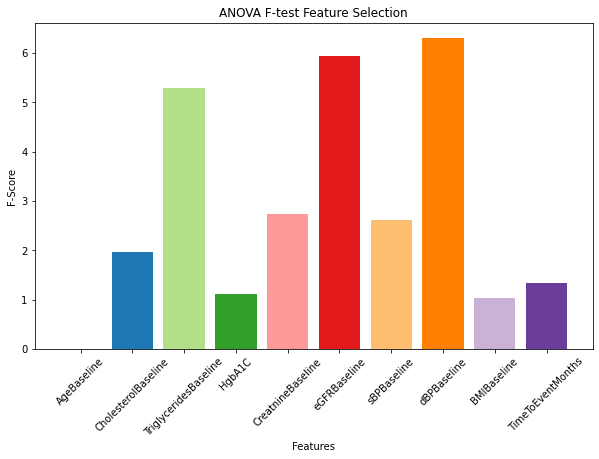

In [124]:
print("Applying ANOVA F-test on numerical columns:")
selected_features_anova = anova_f_test_feature_selection(X_train[numerical_columns], y_train)

Applying RFE on selected columns:
Top features selected by RFE:
['eGFRBaseline', 'HistorySmoking', 'BMIBaseline', 'ACEIARB', 'TimeToEventMonths', 'HistoryCHD', 'HistoryDiabetes', 'HgbA1C', 'Age.3.categories', 'DLDmeds']




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



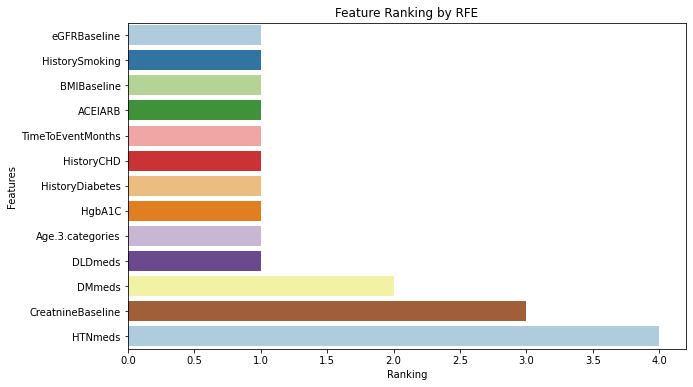

In [125]:
X_train_RFE = X_train[['DMmeds', 'eGFRBaseline', 'HistorySmoking', 
                      'CreatnineBaseline', 'BMIBaseline', 'ACEIARB', 'HTNmeds', 
                      'TimeToEventMonths', 'HistoryCHD', 
                      'HistoryDiabetes', 'HgbA1C','Age.3.categories', 'DLDmeds']]
print("Applying RFE on selected columns:")
selected_features_rfe = rfe_feature_selection(X_train_RFE, y_train)

In [126]:
selected_features = ['DMmeds', 'eGFRBaseline', 'HistorySmoking', 'CholesterolBaseline', 
                      'BMIBaseline', 'ACEIARB', 'HTNmeds','HistoryCHD', 'Age.3.categories', 
                      'HgbA1C', 'DLDmeds']

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

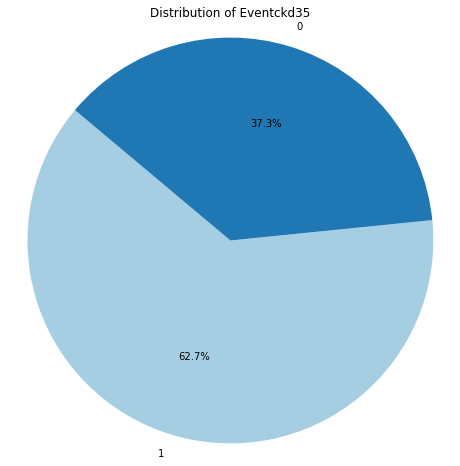

In [127]:
plot_pie_chart(cluster_0, 'EventCKD35')

Original class distribution:
1    31
0    16
Name: EventCKD35, dtype: int64

Resampled class distribution:
0    31
1    31
Name: EventCKD35, dtype: int64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



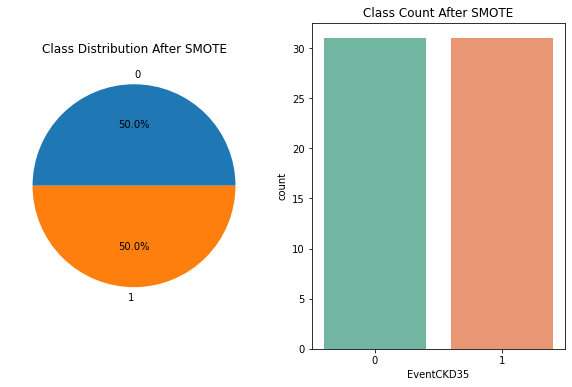

In [128]:
X_train_smote, y_train_smote = apply_smote(X_train_selected, y_train)

In [129]:
results_df = evaluate_models_with_cv(X_train_smote, y_train_smote, X_test, y_test, selected_features)
results_df

Model  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression   0.666667  0.666667  0.666667  0.638889
1        Decision Tree   0.750000  0.500000  0.600000  0.666667
2                  SVM   0.600000  0.500000  0.545455  0.611111
3              XGBoost   0.600000  0.500000  0.545455  0.500000

In [130]:
best_models = perform_grid_search(X_train_smote, y_train_smote, selected_features)


Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
Best parameters for SVM: {'C': 10, 'kernel': 'linear'}
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50}


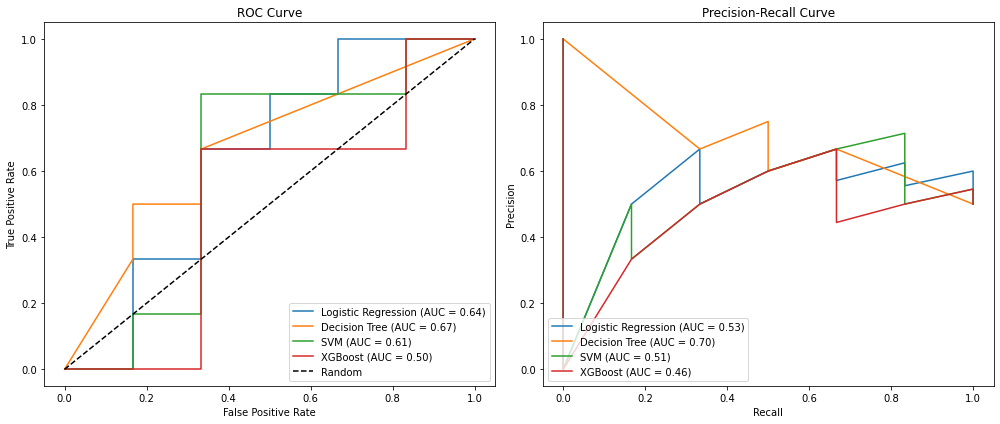

In [131]:
compare_model_performance(best_models, X_test[selected_features], y_test)

### Conclusions

1. **Dimensionality Reduction**: Utilizing PCA for dimensionality reduction improved the clarity of the data, aiding in the subsequent clustering analysis.

2. **Initial Clustering (K=2)**: Dividing the data into 2 clusters using KMeans and hierarchical clustering, visualized by TSNE, showed an optimal silhouette score of 0.1597674284419177. This division revealed a significant concentration of positive values in the 'HistoryCHD', 'HistoryVascular', and 'EventCKD35' columns within cluster_0.

3. **Cluster-Specific Prediction**: Focusing the CKD prediction model on cluster_0, which contained the majority of positive samples, resulted in a lower F1 score (0.555556) compared to previous models. This indicated the need for a more detailed clustering approach.

4. **Further Clustering (K=5)**: 
   - We decided to examine division into K=5 because the results of the prediction model on the cluster with positive samples produced lower accuracy than the prediction model on the entire dataset.
   - Additionally, we wanted to investigate smaller groups that may contain more heterogeneous data.
   - Dividing the data into 5 clusters maintained the direct relationship between 'HistoryCHD' and 'EventCKD35' (as confirmed by chi-square tests).
   - Positive samples continued to be predominantly found in one cluster (cluster_0). Implementing a prediction model on this cluster yielded a better F1 score of 0.666667.
   - We assumed that because the cluster is smaller than the cluster we analyzed by dividing into K=2, the results are better to a greater extent because we still improved the accuracy. This implies that it is possible to learn more about the data by dividing it into 5 clusters.

5. **Implications of Detailed Clustering**: The improved results from the 5-cluster division suggest that smaller, more specific clusters enhance predictive accuracy. This approach allowed for more nuanced insights and better performance.

6. **Future Directions**: Adding more samples and refining the clustering approach could further improve prediction efficiency and provide deeper insights into the data, underscoring the value of detailed clustering in predictive modeling. Additionally, by expanding the dataset, we might create large enough clusters to further improve the prediction efficiency.